In [1]:
libraries = c("dplyr", "magrittr", "tidyr", "gridExtra", "ggplot2", "readxl", "cmdstanr", "IRdisplay",
              "posterior", "bayesplot", "lubridate", "glue")  
for(x in libraries) { suppressMessages(library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)) }

# the cmdpath should be changed if necessary 
set_cmdstan_path('../../../../CmdStan') %>% suppressMessages
# Sys.setlocale("LC_TIME", "C")
'%&%' = function(x,y)paste0(x,y)

R.Version()$version.string

[1] "R version 4.1.2 (2021-11-01)"

In [2]:
generateFigures = TRUE

In [3]:
truncation_date_data = as.Date("2021-08-25")
truncation_date = truncation_date_data#as.Date("2021-06-01")

backup_dir = "../../../Taiwan_Backup"
if (!dir.exists(backup_dir)) dir.create(backup_dir)

stanmaindir = paste0(backup_dir,"/202106-Reff_Wanhua_",format(truncation_date_data, "%Y%m%d"))
if (!dir.exists(stanmaindir)) dir.create(stanmaindir)

figures_main_dir = paste0("../../figures_",format(truncation_date_data, "%Y%m%d"))
if (!dir.exists(figures_main_dir)) dir.create(figures_main_dir)

figures_dir = paste0("../../figures_",format(truncation_date_data, "%Y%m%d"),"/draft")
if (!dir.exists(figures_dir)) dir.create(figures_dir)

results_dir = paste0("../../results_",format(truncation_date_data, "%Y%m%d"))
if (!dir.exists(results_dir)) dir.create(results_dir)

In [4]:
source("GLD_helpers.R")
args("GLD_solver")

function (lower_quartile, median, upper_quartile, other_quantile, 
    alpha, check = TRUE) 
NULL

In [5]:
rstan::expose_stan_functions("quantile_functions.stan")

# Data

In [6]:
df = read.csv(file=format(truncation_date_data, "%Y%m%d")%&%"-data.csv") |>
    mutate(across(c("Onset","Death","Report","Confirm"), ~as.Date(., "%Y-%m-%d"))) |>
    select(-OnsetL, -OnsetR) |> filter(Confirm <= truncation_date)
nrow(df)
head(df)

[1] 14444

ID     SevereL    SevereR    Onset      Report     Confirm    Gender Age
1 案1090 2021-04-22 NA         2021-04-22 2021-04-22 2021-04-23 男     15 
2 案1091 2021-04-16 NA         2021-04-16 2021-04-21 2021-04-23 男     51 
3 案1092 NA         NA         <NA>       2021-04-22 2021-04-24 男     41 
4 案1100 NA         NA         <NA>       2021-04-22 2021-04-25 男     56 
5 案1101 2021-04-26 NA         2021-04-26 2021-04-24 2021-04-25 男     34 
6 案1102 2021-04-24 2021-05-12 2021-04-24 2021-04-25 2021-04-26 男     39 
  ResidArea ResidCounty ⋯ DeathReport Symptoms ReportDay OnsetDay DeathDay
1 北區      桃園市      ⋯ NA          NA       22        22       NA      
2 北區      桃園市      ⋯ NA          NA       21        16       NA      
3 北區      桃園市      ⋯ NA          NA       22        NA       NA      
4 北區      桃園市      ⋯ NA          NA       22        NA       NA      
5 北區      桃園市      ⋯ NA          NA       24        26       NA      
6 台北區    台北市      ⋯ NA          NA       25        24       NA      
  DeathReportDay ConfirmDay ResidCounty_eng Age_group Asymptomatic
1 NA             23         Taoyuan City    10        No          
2 NA             23         Taoyuan City    50        No          
3 NA             24         Taoyuan City    40        Yes         
4 NA             25         Taoyuan City    50        Yes         
5 NA             25         Taoyuan City    30        No          
6 NA             26         Taipei City     30        No

# <font color="purple">Stan for reporting delay</font>

## Using cubic b-spline only for mean

In [7]:
stan_code_delay = 'functions{
    /* Construct B-spline basis functions */
    /* source: https://gist.github.com/chvandorp/f5bd674f7cea39f0b10ffa0f20dac9dc */
    vector build_b_spline(vector t, vector knots, int ind, int order);
    vector build_b_spline(vector t, vector knots, int ind, int order) {
        int n = num_elements(t); int k = num_elements(knots);
        vector[n] b_spline;
        vector[n] w1 = rep_vector(0, n);
        vector[n] w2 = rep_vector(0, n);
        if (order == 1) {
            for (i in 1:n) {
                b_spline[i] = (knots[ind] <= t[i]) && (t[i] < knots[ind+1]);
            }
        } else { // order > 1
            if (knots[ind] != knots[ind+order-1]) {
                w1 = (t - rep_vector(knots[ind], n)) / (knots[ind+order-1] - knots[ind]);
            }
            if (knots[ind+1] != knots[ind+order]) {
                w2 = (rep_vector(knots[ind+order], n) - t) / (knots[ind+order] - knots[ind+1]);
            }
            b_spline = w1 .* build_b_spline(t, knots, ind, order-1) 
                     + w2 .* build_b_spline(t, knots, ind+1, order-1);
        }
        return b_spline;
    }
}

data {
    int<lower=0> N; // number of records
    int<lower = 1> K; // truncation date
    array[N] int<lower=1, upper=K> onset_day; // illness onset left
    array[N] int<lower=1, upper=K> confirm_day; // confirmation left

    int<lower = 0, upper = 1> is_by_onset;

    // b-splining
    int J; //number of knots for b-spline
    vector[J] knots;
    int spline_degree;

    int half_delay_sliding_window;
}

transformed data {
    int D = 3; // number of distributions (Gamma, Weibull, Lognormal)

    vector[K] X;
    for (k in 1:K) X[k] = k;

    int num_basis = J + spline_degree - 1; //total number of B-splines
    matrix[num_basis, K] B; //matrix of B-splines
    vector[spline_degree + J] ext_knots_tmp;
    vector[2*spline_degree + J] ext_knots; //set of extended knots
    ext_knots_tmp = append_row(rep_vector(knots[1], spline_degree), knots);
    ext_knots = append_row(ext_knots_tmp, rep_vector(knots[J], spline_degree));
    for (ind in 1:num_basis)
        B[ind, :] = to_row_vector(build_b_spline(X, ext_knots, ind, spline_degree + 1));
    for(i in 1:K) 
        if(X[i] == ext_knots[J + 2*spline_degree - 1]) B[num_basis, i] = 1;

    array[N] int index_min, index_max;
    for (n in 1:N) {
        int day_ = is_by_onset ? onset_day[n] : confirm_day[n];
        index_min[n] = max({day_ - half_delay_sliding_window, 1}); 
        index_max[n] = min({day_ + half_delay_sliding_window, K});
        if (index_max[n]==K)
            index_min[n] = K - 2*half_delay_sliding_window;
        if (index_min[n]==1)
            index_max[n] = 1 + 2*half_delay_sliding_window;
    }
}

parameters {
    vector<lower=-1, upper=1>[N] delay_raw; 
    real<lower=0> param1_Weibull;

    // b-spline
    row_vector[num_basis] a;

    simplex[D] weight; // mixing proportions
}

transformed parameters {
    row_vector[K] mean_delay = exp(a * B);
    real<lower = 0> cv_delay = sqrt(tgamma(1.0 + 2.0 / param1_Weibull) / square(tgamma(1.0 + 1.0 / param1_Weibull)) - 1.0);

    vector[D] lps = log(weight); // internal component likelihoods 
    {
        vector[N] delay;
        for (i in 1:N) 
            delay[i] = (confirm_day[i] == onset_day[i]) ? (delay_raw[i] + 1.0) / 2.0 : confirm_day[i] - onset_day[i] + delay_raw[i];

        // Weibull distribution
        row_vector[K] param2_Weibull = mean_delay / tgamma(1.0 + 1.0 / param1_Weibull); 
        for (n in 1:N) 
            lps[2] += weibull_lpdf(delay[n] | param1_Weibull, param2_Weibull[index_min[n]:index_max[n]]) 
                    - weibull_lcdf(K + 0.5 - onset_day[n] | param1_Weibull, param2_Weibull[index_min[n]:index_max[n]]);

        // Gamma distribution
        real param1_Gamma = square(1 / cv_delay);
        row_vector[K] param2_Gamma = param1_Gamma ./ mean_delay;
        for (n in 1:N) 
            lps[1] += gamma_lpdf(delay[n] | param1_Gamma, param2_Gamma[index_min[n]:index_max[n]]) 
                    - gamma_lcdf(K + 0.5 - onset_day[n] | param1_Gamma, param2_Gamma[index_min[n]:index_max[n]]);

        // Lognormal distribution
        real param2_lognormal = sqrt(log(square(cv_delay) + 1.0));
        row_vector[K] param1_lognormal = log(mean_delay) - square(param2_lognormal) / 2.0;
        for (n in 1:N) 
            lps[3] += lognormal_lpdf(delay[n] | param1_lognormal[index_min[n]:index_max[n]], param2_lognormal) 
                    - lognormal_lcdf(K + 0.5 - onset_day[n] | param1_lognormal[index_min[n]:index_max[n]], param2_lognormal);
    }
}

model {
    /* priors */
    delay_raw ~ std_normal();

    a ~ std_normal();
    param1_Weibull ~ exponential(0.001);

    target += log_sum_exp(lps);
}

generated quantities {
    vector<lower = 0, upper = 1>[D] q = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(q);
    row_vector[K] reporting_delay;

    {
        if (comp == 2) {
            // Weibull distribution
            row_vector[K] param2_Weibull = mean_delay / tgamma(1.0 + 1.0 / param1_Weibull);
            for (k in 1:K) 
                reporting_delay[k] = weibull_rng(param1_Weibull, param2_Weibull[k]);
        } else if (comp == 1) {
            // Gamma distribution
            real param1_Gamma = square(1 / cv_delay);
            row_vector[K] param2_Gamma = param1_Gamma ./ mean_delay;
            for (k in 1:K)
                reporting_delay[k] = gamma_rng(param1_Gamma, param2_Gamma[k]);
        } else if (comp == 3) {
            // Lognormal distribution
            real param2_lognormal = sqrt(log(square(cv_delay) + 1.0));
            row_vector[K] param1_lognormal = log(mean_delay) - square(param2_lognormal) / 2.0;
            for (k in 1:K)
                reporting_delay[k] = lognormal_rng(param1_lognormal[k], param2_lognormal);
        }
    }
}'

In [8]:
#! change the following variable to TRUE if you want to re-run the simulations 
recalc_delay = F
generateFigures = T    
standistribdir = "../../../../CmdStan"

df %>% filter(!is.na(Onset)) -> df_
    
(mindate = df_$Onset |> min(na.rm=T) - 1)
(truncation_day = as.numeric(truncation_date - mindate))

df_ %<>% mutate(
   ReportDay = as.numeric(Report - mindate),
   OnsetDay = as.numeric(Onset - mindate),
   ConfirmDay = as.numeric(Confirm - mindate))
    
df_ %>% 
    mutate(OnsetDay = if_else(OnsetDay > ConfirmDay, ConfirmDay, OnsetDay), Delay = ConfirmDay - OnsetDay) -> df_delay
    
print("Number of cases: "%&%nrow(df_delay))
    
foo_delay = \(is_by_onset, spline_window, half_delay_sliding_window) {
    standirname_delay_onset = stanmaindir%&%"/delay_mixture_by_onset_window_"%&%spline_window%&%"_"%&%half_delay_sliding_window%&%"_"%&%format(truncation_date,"%Y%m%d")
    standirname_delay_confirm = stanmaindir%&%"/delay_mixture_by_confirm_window_"%&%spline_window%&%"_"%&%half_delay_sliding_window%&%"_"%&%format(truncation_date,"%Y%m%d")
    
    if (is_by_onset)
        standirname_delay = standirname_delay_onset
    else
        standirname_delay = standirname_delay_confirm
    stanscriptdir_delay = "../Dropbox/" %&% substring(standirname_delay,10)

    #unlink(standirname_delay, recursive=T)
    dir.create(standirname_delay)

    ## @data ##
    K = truncation_day; X = 1:K
    spline_degree = 3; J = K %/% spline_window + 1; num_basis = J + spline_degree - 1
    knots = unname(quantile(X, probs=seq(from=0, to=1, length.out = J)))

    N = nrow(df_delay)
    onset_day = df_delay$OnsetDay
    confirm_day = df_delay$ConfirmDay
    rstan::stan_rdump(c("spline_window", "half_delay_sliding_window",
                        "N", "onset_day", "confirm_day", "K", "is_by_onset",
                        "spline_degree", "J", "knots"), file=standirname_delay%&%"/Data.R")

    ## @init ##
    delay_raw = rep(.5, N)
    param1_Weibull = 2.0
    a_raw = rep(0.2, num_basis)
    rstan::stan_rdump(c("delay_raw", "param1_Weibull", "a_raw"), file=standirname_delay%&%"/Init.R")

    ## @stan_script ##
    cat(stan_code_delay, file=standirname_delay %&% "/reporting_delay.stan", sep="", fill=TRUE)

    ## @bash file ##
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    rm "%&%stanscriptdir_delay%&%"/reporting_delay
    make -j6 "%&%stanscriptdir_delay%&%"/reporting_delay
    cd "%&%stanscriptdir_delay%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./reporting_delay \\
            method=sample num_samples=1250 num_warmup=2000 save_warmup=0\\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname_delay%&%"/fit.sh", sep="", fill=TRUE)

    ## @running the bash script ##
    system("bash "%&%standirname_delay%&%"/fit.sh", intern = TRUE)
};

for (spline_window_ in c(5,15))
    for (half_delay_sliding_window_ in c(7))
        if (recalc_delay) {
            foo_delay(0, spline_window_, half_delay_sliding_window_); 
            #foo_delay(0, spline_window_, half_delay_sliding_window_);
        } 

[1] "2021-03-31"

[1] 147

[1] "Number of cases: 8646"


## Processing the traces

## Main figure

In [9]:
baseline_spline_window = 10
baseline_half_delay_sliding_window = 7

## <font color="red">By onset</font>

In [10]:
spline_window_ = baseline_spline_window
half_delay_sliding_window_ = baseline_half_delay_sliding_window
standirname_delay_onset = stanmaindir%&%"/delay_mixture_by_onset_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
output_files = c(); idx = 1
for (fl_ in list.files(standirname_delay_onset, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_onset = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

`summarise()` has grouped output by 't'. You can override using the `.groups` argument.

Joining, by = c("t", "d")



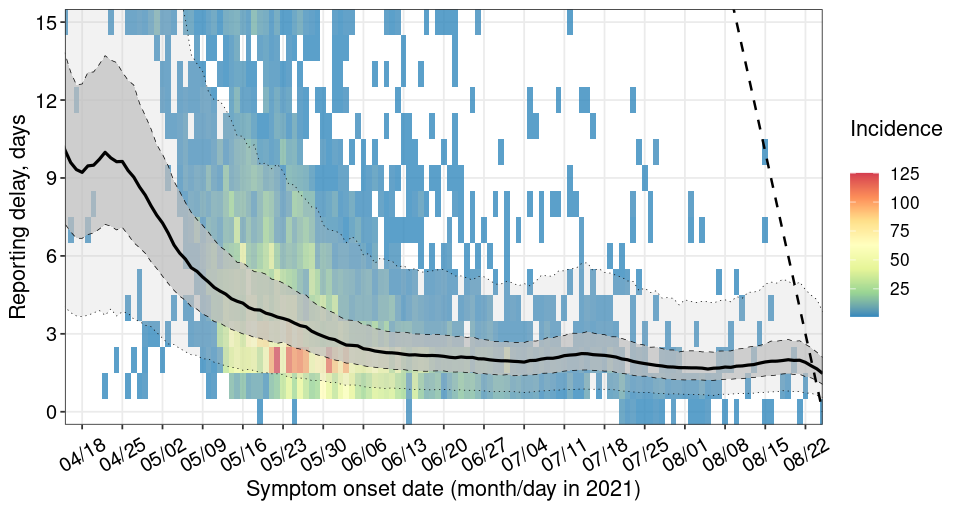

In [11]:
mod_onset$summary(c("reporting_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_onset
names(df_mean_delay_onset) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_mean_delay_onset$variable, "[\\d+(.*)]")
df_mean_delay_onset$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_mean_delay_onset %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                                   select(-variable, -index) %>% filter(d<=truncation_date)
 
maxdelay = 15
Cases = df_ %>%
    mutate(t = OnsetDay, d = ConfirmDay - OnsetDay,
           d = if_else(d>maxdelay, maxdelay, d)) %>% group_by(t,d) %>% summarize(n=n()) %>%
    right_join(expand_grid(t = seq(from = 1, to = truncation_day, by = 1), d = seq(from = 0, to = maxdelay, by = 1))) %>%
    mutate(t_date = t + mindate) %>%
    replace(is.na(.), 0)  
    
mindate_plt = as.Date("2021-04-15")                           
mindate_plt_brks = as.Date("2021-04-18")                           
                             
cs = c(8,4.25)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
date_brks = seq(mindate_plt_brks, truncation_date, by="week")
y_brks = seq(0, maxdelay, by=3)
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        geom_tile(aes(y = d, fill=n), alpha=.8) +
        scale_fill_distiller(palette = "Spectral", direction=-1) +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='Reporting delay, days', fill="Incidence\n") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        geom_ribbon(data = df_mean_delay_onset %>% rename(t_date = d), 
                    aes(ymax=IQR_upper, ymin=IQR_lower), fill="grey", size=0, alpha = .7) +
        geom_ribbon(data = df_mean_delay_onset %>% rename(t_date = d), 
                    aes(ymax=upper, ymin=lower), fill="grey", linetype='dotted', size=0, alpha = .2) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=upper), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=lower), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=IQR_upper), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=IQR_lower), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), 
                  aes(y=median), color="black", size=.9, alpha=1) +
        geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
                          mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks) +
        scale_y_continuous(breaks = y_brks) -> plt1_delay

plt1_delay
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1_delay, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/delay_by_onset_window_",spline_window_,"_",half_delay_sliding_window_,".",filetype_))
                      
    df_mean_delay_onset |> write.csv(file=paste0(results_dir,"/delay_by_onset_window_",spline_window_,"_",half_delay_sliding_window_,".csv"),row.names=FALSE)
}

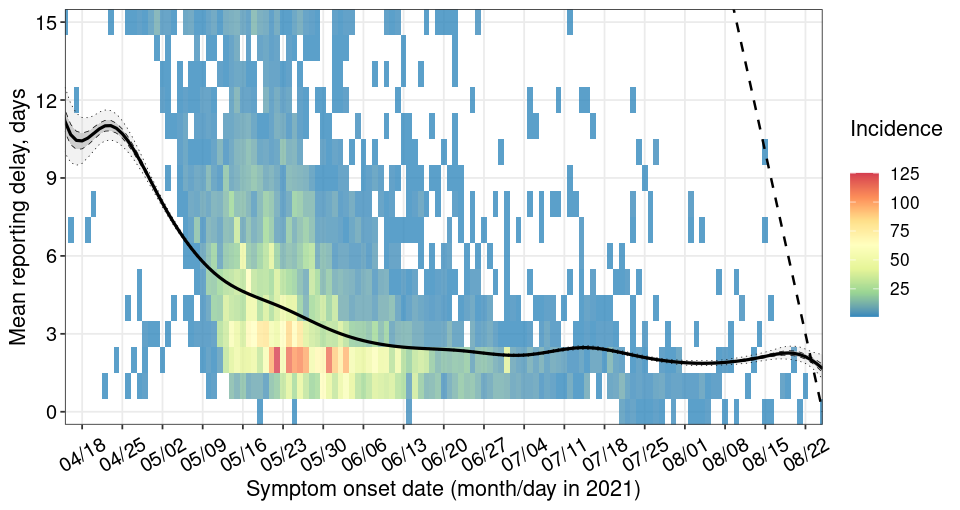

In [12]:
mod_onset$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_onset
names(df_mean_delay_onset) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_mean_delay_onset$variable, "[\\d+(.*)]")
df_mean_delay_onset$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_mean_delay_onset %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                                   select(-variable, -index) %>% filter(d<=truncation_date)
 
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        geom_tile(aes(y = d, fill=n), alpha=.8) +
        scale_fill_distiller(palette = "Spectral", direction=-1) +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='Mean reporting delay, days', fill="Incidence\n") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        geom_ribbon(data = df_mean_delay_onset %>% rename(t_date = d), 
                    aes(ymax=IQR_upper, ymin=IQR_lower), fill="grey", size=0, alpha = .7) +
        geom_ribbon(data = df_mean_delay_onset %>% rename(t_date = d), 
                    aes(ymax=upper, ymin=lower), fill="grey", linetype='dotted', size=0, alpha = .2) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=upper), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=lower), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=IQR_upper), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=IQR_lower), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), 
                  aes(y=median), color="black", size=.9, alpha=1) +
        geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
                          mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks) +
        scale_y_continuous(breaks = y_brks) -> plt1_mean_delay

plt1_mean_delay
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1_mean_delay, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/mean_delay_by_onset_window_",spline_window_,"_",half_delay_sliding_window_,".",filetype_))
                      
    df_mean_delay_onset |> write.csv(file=paste0(results_dir,"/mean_delay_by_onset_window_",spline_window_,"_",half_delay_sliding_window_,".csv"),row.names=FALSE)
}

In [13]:
mod_onset$summary(c("cv_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_cv_delay_onset
names(df_cv_delay_onset) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
df_cv_delay_onset

variable median    lower    upper     IQR_lower IQR_upper
1 cv_delay 0.5013535 0.498544 0.5042971 0.500414  0.5023283

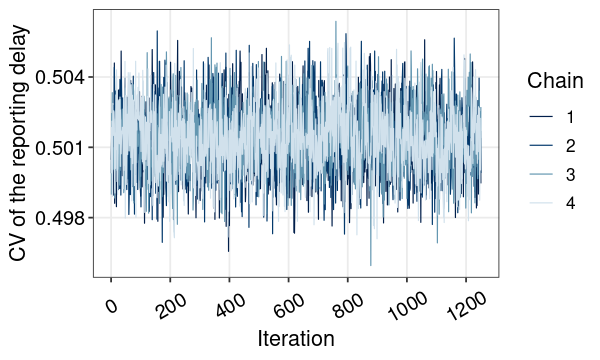

In [14]:
options(repr.plot.width=5, repr.plot.height=3)
mcmc_trace(mod_onset$draws(c("cv_delay"))) +  
    labs(x='Iteration', y='CV of the reporting delay') +
    theme_bw() +
    theme(text = element_text(size=13, family="sans", color="black"),
          axis.text = element_text(size=12, family="sans", color="black"),
          axis.text.x = element_text(angle=30,vjust=.5),
          panel.grid.minor = element_blank()) -> plt1_1

plt1_1 

filetype_ = "pdf"
ggsave(plot=plt1_1, width=5.5, height=3, device = filetype_,
               filename=paste0(figures_dir,"/cv_trace_by_onset.",filetype_))

### Sensitivity analysis

5

10

15



[1] "Finished"


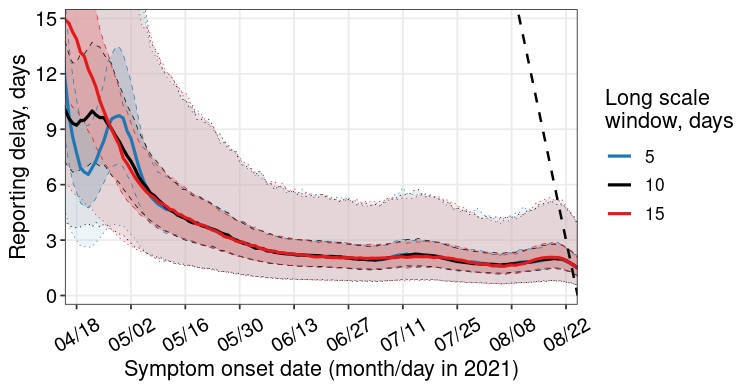

In [15]:
idx_ = TRUE
spline_windows = c(5,10,15)
for (spline_window_ in spline_windows) {
    message(spline_window_)
    half_delay_sliding_window_ = baseline_half_delay_sliding_window
    standirname_delay_onset = stanmaindir%&%"/delay_mixture_by_onset_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_onset, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_onset = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_onset$summary(c("reporting_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_onset
    names(df_mean_delay_onset) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_onset$variable, "[\\d+(.*)]")
    df_mean_delay_onset$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_onset %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_onset_combined = df_mean_delay_onset
        idx_ = FALSE
    } else
        df_mean_delay_onset_combined %<>% rbind(df_mean_delay_onset)
}
        
df_mean_delay_onset_combined %<>% mutate(spline_window = as.factor(spline_window), 
                                         half_delay_sliding_window = as.factor(half_delay_sliding_window))
                             
cs1_sens = cs[1]-1.75; cs2_sens = cs[2]-1
date_brks_sens = seq(mindate_plt_brks, truncation_date, by="2 weeks")
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)
my_palette = RColorBrewer::brewer.pal(name="Paired",n=9)[c(1,3,5)+1]
my_palette[2] = 'black'
my_palette_shades = RColorBrewer::brewer.pal(name="Paired",n=9)[c(1,3,5)]
my_palette_shades[2] = 'darkgrey'
                                    

df_mean_delay_onset_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=spline_window, group=spline_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=spline_window, group=spline_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=spline_window, group=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=spline_window, group=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=spline_window, group=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=spline_window, group=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=spline_window, group=spline_window), size=.9, alpha=1) +
        geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
               mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_colour_manual(values = my_palette) +
        scale_fill_manual(values = my_palette_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='Reporting delay, days', color="Long scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/delay_sensitivity_by_onset_window_long_scale.",filetype_))
}
                                       
print("Finished")

5

10

15



[1] "Finished"


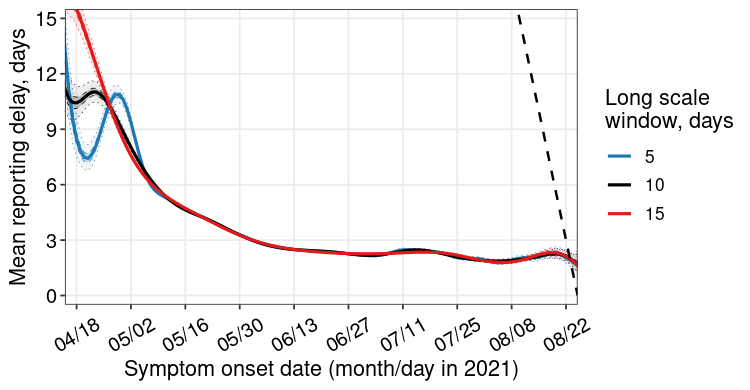

In [16]:
idx_ = TRUE
for (spline_window_ in spline_windows) {
    message(spline_window_)
    half_delay_sliding_window_ = baseline_half_delay_sliding_window
    standirname_delay_onset = stanmaindir%&%"/delay_mixture_by_onset_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_onset, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_onset = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_onset$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_onset
    names(df_mean_delay_onset) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_onset$variable, "[\\d+(.*)]")
    df_mean_delay_onset$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_onset %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_onset_combined = df_mean_delay_onset
        idx_ = FALSE
    } else
        df_mean_delay_onset_combined %<>% rbind(df_mean_delay_onset)
}
        
df_mean_delay_onset_combined %<>% mutate(spline_window = as.factor(spline_window), half_delay_sliding_window = as.factor(half_delay_sliding_window))
                                       
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)
df_mean_delay_onset_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=spline_window, group=spline_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=spline_window, group=spline_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=spline_window, group=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=spline_window, group=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=spline_window, group=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=spline_window, group=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=spline_window, group=spline_window), size=.9, alpha=1) +
        geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
               mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_colour_manual(values = my_palette) +
        scale_fill_manual(values = my_palette_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='Mean reporting delay, days', color="Long scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/mean_delay_sensitivity_by_onset_window_long_scale.",filetype_))
}
                                       
print("Finished")

3

7

11



[1] "Finished"


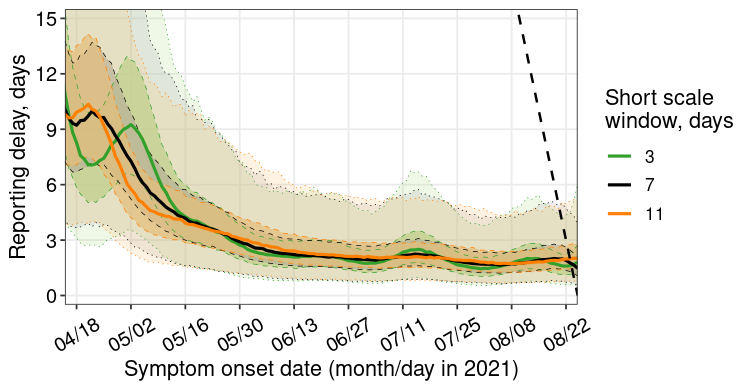

In [17]:
idx_ = TRUE
half_delay_sliding_windows = c(3,7,11)
for (half_delay_sliding_window_ in half_delay_sliding_windows) {
    message(half_delay_sliding_window_)
    spline_window_ = baseline_spline_window
    standirname_delay_onset = stanmaindir%&%"/delay_mixture_by_onset_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_onset, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_onset = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_onset$summary(c("reporting_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_onset
    names(df_mean_delay_onset) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_onset$variable, "[\\d+(.*)]")
    df_mean_delay_onset$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_onset %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_onset_combined = df_mean_delay_onset
        idx_ = FALSE
    } else
        df_mean_delay_onset_combined %<>% rbind(df_mean_delay_onset)
}
        
df_mean_delay_onset_combined %<>% mutate(spline_window = as.factor(spline_window), half_delay_sliding_window = as.factor(half_delay_sliding_window))
                                       
print("Finished")
                     
my_palette2 = RColorBrewer::brewer.pal(name="Paired",n=9)[c(3,3,7)+1]
my_palette2[2] = 'black'
my_palette2_shades = RColorBrewer::brewer.pal(name="Paired",n=9)[c(3,3,7)]
my_palette2_shades[2] = 'darkgrey'                                       
                                       
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)

df_mean_delay_onset_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=half_delay_sliding_window, group=half_delay_sliding_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=half_delay_sliding_window, group=half_delay_sliding_window), size=.9, alpha=1) +
        geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
               mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_colour_manual(values = my_palette2) +
        scale_fill_manual(values = my_palette2_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='Reporting delay, days', color="Short scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/delay_sensitivity_by_onset_short_scale.",filetype_))
}

3

7

11



[1] "Finished"


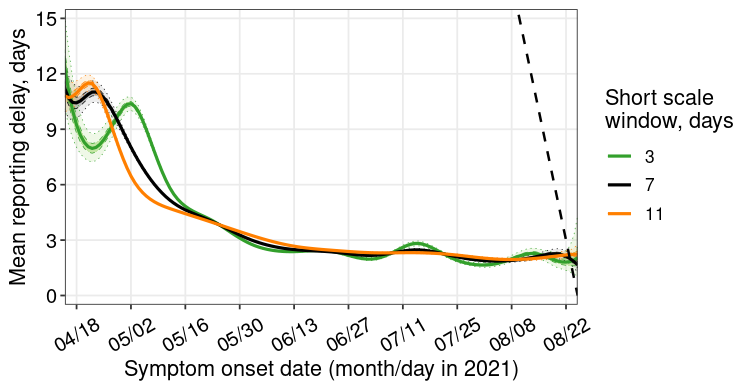

In [18]:
idx_ = TRUE
for (half_delay_sliding_window_ in half_delay_sliding_windows) {
    message(half_delay_sliding_window_)
    spline_window_ = baseline_spline_window
    standirname_delay_onset = stanmaindir%&%"/delay_mixture_by_onset_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_onset, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_onset = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_onset$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_onset
    names(df_mean_delay_onset) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_onset$variable, "[\\d+(.*)]")
    df_mean_delay_onset$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_onset %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_onset_combined = df_mean_delay_onset
        idx_ = FALSE
    } else
        df_mean_delay_onset_combined %<>% rbind(df_mean_delay_onset)
}
        
df_mean_delay_onset_combined %<>% mutate(spline_window = as.factor(spline_window), half_delay_sliding_window = as.factor(half_delay_sliding_window))
                                       
print("Finished")
                                       
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)
df_mean_delay_onset_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=half_delay_sliding_window, group=half_delay_sliding_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=half_delay_sliding_window, group=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=half_delay_sliding_window, group=half_delay_sliding_window), size=.9, alpha=1) +
        geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
               mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_colour_manual(values = my_palette2) +
        scale_fill_manual(values = my_palette2_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='Mean reporting delay, days', color="Short scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/mean_delay_sensitivity_by_onset_short_scale.",filetype_))
}

## <font color="red">By confirmation</font>

In [19]:
standirname_delay_confirm = stanmaindir%&%"/delay_mixture_by_confirm_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
output_files = c(); idx = 1
for (fl_ in list.files(standirname_delay_confirm, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_confirm = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

`summarise()` has grouped output by 't'. You can override using the `.groups` argument.

Joining, by = c("t", "d")



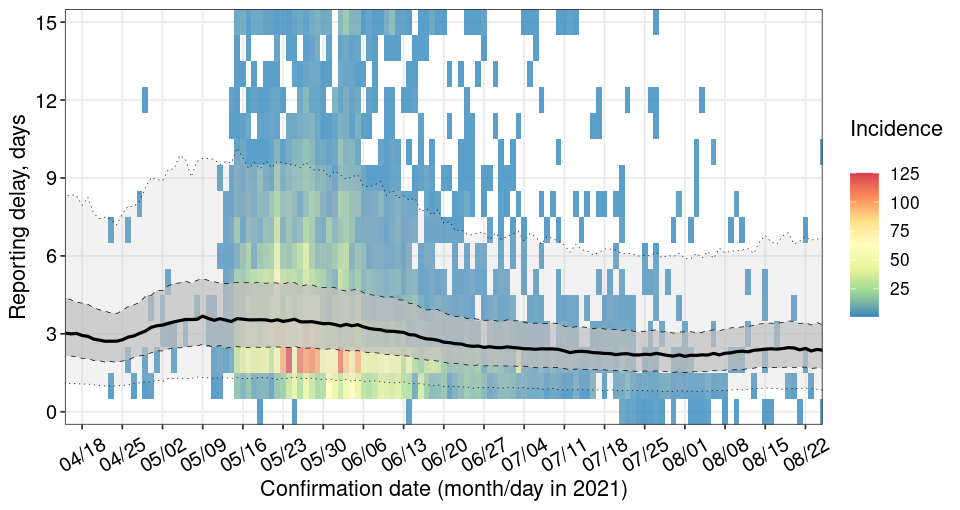

In [20]:
mod_confirm$summary(c("reporting_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_confirm
names(df_mean_delay_confirm) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_mean_delay_confirm$variable, "[\\d+(.*)]")
df_mean_delay_confirm$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_mean_delay_confirm %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                                   select(-variable, -index) %>% filter(d<=truncation_date)
 
maxdelay = 15
Cases = df_ %>%
    mutate(t = ConfirmDay, d = ConfirmDay - OnsetDay,
           d = if_else(d>maxdelay, maxdelay, d)) %>% group_by(t,d) %>% summarize(n=n()) %>%
    right_join(expand_grid(t = seq(from = 1, to = truncation_day, by = 1), d = seq(from = 0, to = maxdelay, by = 1))) %>%
    mutate(t_date = t + mindate) %>%
    replace(is.na(.), 0) 

options(repr.plot.width=cs[1],repr.plot.height=cs[2])
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        geom_tile(aes(y = d, fill=n), alpha=.8) +
        scale_fill_distiller(palette = "Spectral", direction=-1) +
        coord_cartesian(expand=F, ylim=c(-.5,maxdelay+0.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Confirmation date (month/day in 2021)', y='Reporting delay, days', fill="Incidence\n") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        geom_ribbon(data = df_mean_delay_confirm %>% rename(t_date = d), 
                    aes(ymax=IQR_upper, ymin=IQR_lower), fill="grey", size=0, alpha = .7) +
        geom_ribbon(data = df_mean_delay_confirm %>% rename(t_date = d), 
                    aes(ymax=upper, ymin=lower), fill="grey", linetype='dotted', size=0, alpha = .2) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=upper), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=lower), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=IQR_upper), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=IQR_lower), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), 
                  aes(y=median), color="black", size=.9, alpha=1) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks) +
        scale_y_continuous(breaks = y_brks)  -> plt2_delay

plt2_delay
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt2_delay, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/delay_by_confirm_window_",spline_window_,"_",half_delay_sliding_window_,".",filetype_))
                      
    df_mean_delay_confirm |> write.csv(file=paste0(results_dir,"/delay_by_confirm_window_",spline_window_,"_",half_delay_sliding_window_,".csv"),row.names=FALSE)
}

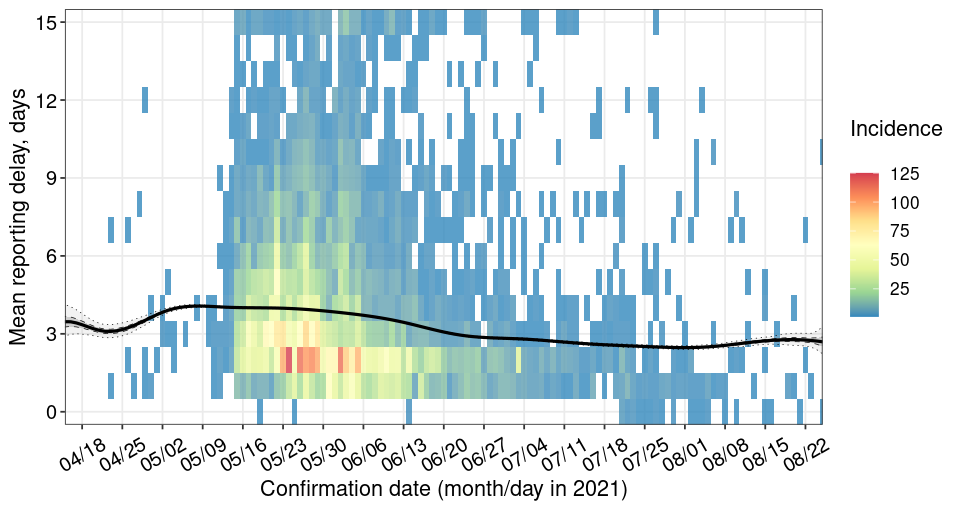

In [21]:
mod_confirm$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_confirm
names(df_mean_delay_confirm) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_mean_delay_confirm$variable, "[\\d+(.*)]")
df_mean_delay_confirm$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_mean_delay_confirm %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                                   select(-variable, -index) %>% filter(d<=truncation_date)                         
                             
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        geom_tile(aes(y = d, fill=n), alpha=.8) +
        scale_fill_distiller(palette = "Spectral", direction=-1) +
        coord_cartesian(expand=F, ylim=c(-.5,maxdelay+.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Confirmation date (month/day in 2021)', y='Mean reporting delay, days', fill="Incidence\n") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        geom_ribbon(data = df_mean_delay_confirm %>% rename(t_date = d), 
                    aes(ymax=IQR_upper, ymin=IQR_lower), fill="grey", size=0, alpha = .7) +
        geom_ribbon(data = df_mean_delay_confirm %>% rename(t_date = d), 
                    aes(ymax=upper, ymin=lower), fill="grey", linetype='dotted', size=0, alpha = .2) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=upper), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=lower), 
                  linetype='dotted', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=IQR_upper), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), aes(y=IQR_lower), 
                  linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_confirm %>% rename(t_date = d), 
                  aes(y=median), color="black", size=.9, alpha=1) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks) +
        scale_y_continuous(breaks = y_brks) -> plt2_mean_delay

plt2_mean_delay
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt2_mean_delay, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/mean_delay_by_confirm_window_",spline_window_,"_",half_delay_sliding_window_,".",filetype_))
                      
    df_mean_delay_confirm |> write.csv(file=paste0(results_dir,"/mean_delay_by_confirm_window_",spline_window_,"_",half_delay_sliding_window_,".csv"),row.names=FALSE)
}

In [22]:
mod_confirm$summary(c("cv_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_cv_delay_confirm
names(df_cv_delay_confirm) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
df_cv_delay_confirm

variable median   lower     upper     IQR_lower IQR_upper
1 cv_delay 0.546386 0.5438019 0.5490011 0.54549   0.5472693

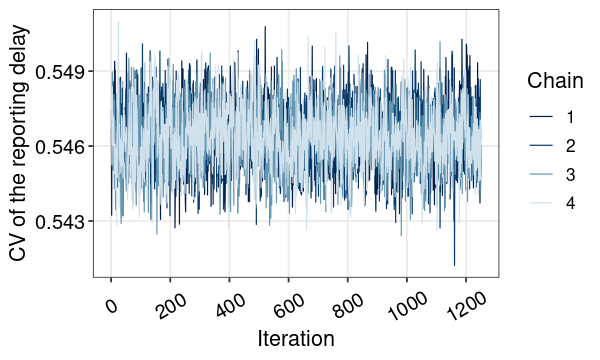

In [23]:
options(repr.plot.width=5, repr.plot.height=3)
mcmc_trace(mod_confirm$draws(c("cv_delay"))) +     
    labs(x='Iteration', y='CV of the reporting delay') +
    theme_bw() +
    theme(text = element_text(size=13, family="sans", color="black"),
          axis.text = element_text(size=12, family="sans", color="black"),
          axis.text.x = element_text(angle=30,vjust=.5),
          panel.grid.minor = element_blank())  -> plt2_1

plt2_1

filetype_ = "pdf"
ggsave(plot=plt2_1, width=5.5, height=3, device = filetype_,
               filename=paste0(figures_dir,"/cv_trace_by_confirmation.",filetype_))

### Sensitivity analysis

5

10

15



[1] "Finished"


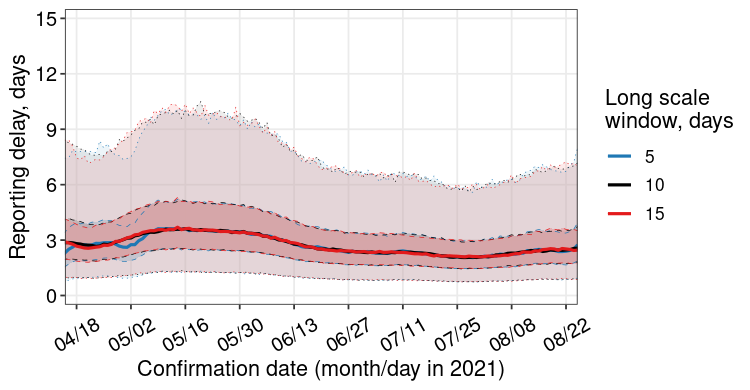

In [24]:
idx_ = TRUE
for (spline_window_ in spline_windows) {
    message(spline_window_)
    half_delay_sliding_window_ = baseline_half_delay_sliding_window
    standirname_delay_confirm = stanmaindir%&%"/delay_mixture_by_confirm_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_confirm, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_confirm = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_confirm$summary(c("reporting_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_confirm
    names(df_mean_delay_confirm) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_confirm$variable, "[\\d+(.*)]")
    df_mean_delay_confirm$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_confirm %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_confirm_combined = df_mean_delay_confirm
        idx_ = FALSE
    } else
        df_mean_delay_confirm_combined %<>% rbind(df_mean_delay_confirm)
}
        
df_mean_delay_confirm_combined %<>% mutate(spline_window = as.factor(spline_window), half_delay_sliding_window = as.factor(half_delay_sliding_window))
                                       
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)
df_mean_delay_confirm_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date, group=spline_window)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=spline_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=spline_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=spline_window), size=.9, alpha=1) +
        scale_colour_manual(values = my_palette) +
        scale_fill_manual(values = my_palette_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Confirmation date (month/day in 2021)', y='Reporting delay, days', color="Long scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/delay_sensitivity_by_confirm_window_long_scale.",filetype_))
}
                                       
print("Finished")

5

10

15



[1] "Finished"


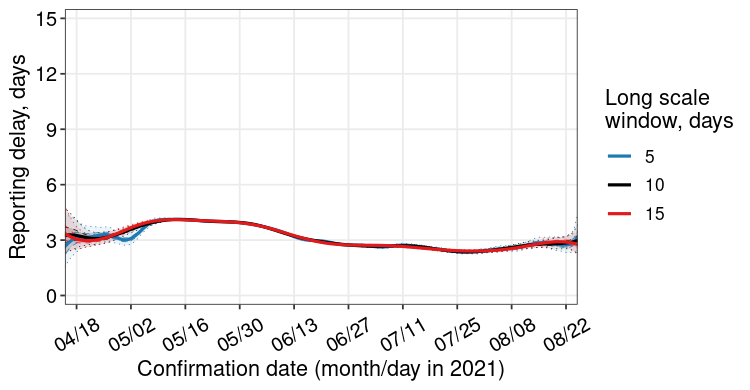

In [25]:
idx_ = TRUE
for (spline_window_ in spline_windows) {
    message(spline_window_)
    half_delay_sliding_window_ = baseline_half_delay_sliding_window
    standirname_delay_confirm = stanmaindir%&%"/delay_mixture_by_confirm_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_confirm, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_confirm = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_confirm$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_confirm
    names(df_mean_delay_confirm) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_confirm$variable, "[\\d+(.*)]")
    df_mean_delay_confirm$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_confirm %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_confirm_combined = df_mean_delay_confirm
        idx_ = FALSE
    } else
        df_mean_delay_confirm_combined %<>% rbind(df_mean_delay_confirm)
}
        
df_mean_delay_confirm_combined %<>% mutate(spline_window = as.factor(spline_window), half_delay_sliding_window = as.factor(half_delay_sliding_window))
                                       
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)
df_mean_delay_confirm_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date, group=spline_window)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=spline_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=spline_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=spline_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=spline_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=spline_window), size=.9, alpha=1) +
        #geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
        #        mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_colour_manual(values = my_palette) +
        scale_fill_manual(values = my_palette_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Confirmation date (month/day in 2021)', y='Reporting delay, days', color="Long scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/mean_delay_sensitivity_by_confirm_window_long_scale.",filetype_))
}
                                       
print("Finished")

3

7

11



[1] "Finished"


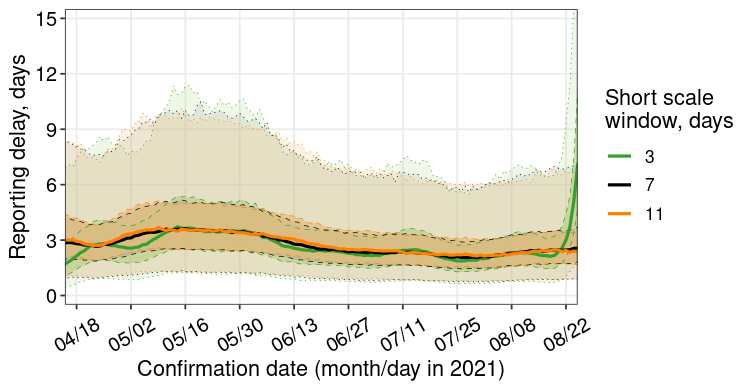

In [26]:
idx_ = TRUE
for (half_delay_sliding_window_ in half_delay_sliding_windows) {
    message(half_delay_sliding_window_)
    spline_window_ = baseline_spline_window
    standirname_delay_confirm = stanmaindir%&%"/delay_mixture_by_confirm_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_confirm, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_confirm = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_confirm$summary(c("reporting_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_confirm
    names(df_mean_delay_confirm) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_confirm$variable, "[\\d+(.*)]")
    df_mean_delay_confirm$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_confirm %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_confirm_combined = df_mean_delay_confirm
        idx_ = FALSE
    } else
        df_mean_delay_confirm_combined %<>% rbind(df_mean_delay_confirm)
}
        
df_mean_delay_confirm_combined %<>% mutate(spline_window = as.factor(spline_window), half_delay_sliding_window = as.factor(half_delay_sliding_window))
                                       
print("Finished")
                                       
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)
df_mean_delay_confirm_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date, group=half_delay_sliding_window)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=half_delay_sliding_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=half_delay_sliding_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=half_delay_sliding_window), size=.9, alpha=1) +
        scale_colour_manual(values = my_palette2) +
        scale_fill_manual(values = my_palette2_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Confirmation date (month/day in 2021)', y='Reporting delay, days', color="Short scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/delay_sensitivity_by_confirm_short_scale.",filetype_))
}

3

7

11



[1] "Finished"


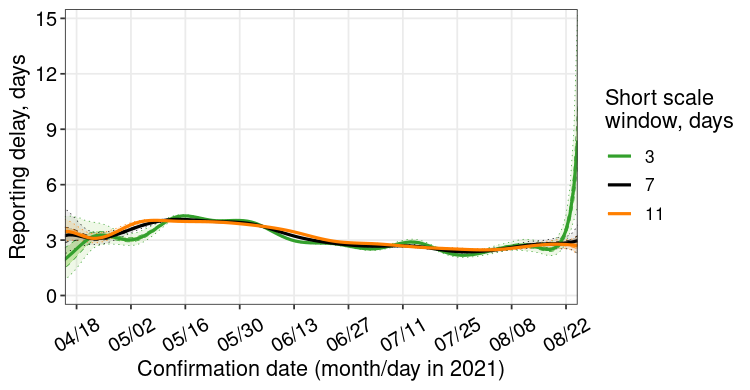

In [27]:
idx_ = TRUE
for (half_delay_sliding_window_ in half_delay_sliding_windows) {
    message(half_delay_sliding_window_)
    spline_window_ = baseline_spline_window
    standirname_delay_confirm = stanmaindir%&%"/delay_mixture_by_confirm_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname_delay_confirm, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    mod_confirm = as_cmdstan_fit(output_files, check_diagnostics=FALSE)
    
    mod_confirm$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay_confirm
    names(df_mean_delay_confirm) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
    out = stringr::str_match_all(df_mean_delay_confirm$variable, "[\\d+(.*)]")
    df_mean_delay_confirm$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
    df_mean_delay_confirm %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date) %>%
                             mutate(spline_window = spline_window_, half_delay_sliding_window = half_delay_sliding_window_)
     
    if (idx_) {
        df_mean_delay_confirm_combined = df_mean_delay_confirm
        idx_ = FALSE
    } else
        df_mean_delay_confirm_combined %<>% rbind(df_mean_delay_confirm)
}
        
df_mean_delay_confirm_combined %<>% mutate(spline_window = as.factor(spline_window), half_delay_sliding_window = as.factor(half_delay_sliding_window))
                                       
print("Finished")
                                       
options(repr.plot.width=cs1_sens,repr.plot.height=cs2_sens)
df_mean_delay_confirm_combined %>% rename(t_date = d) %>%
    ggplot(aes(x=t_date, group=half_delay_sliding_window)) +
        geom_ribbon(aes(ymax=IQR_upper, ymin=IQR_lower, fill=half_delay_sliding_window), size=0, alpha = .7) +
        geom_ribbon(aes(ymax=upper, ymin=lower, fill=half_delay_sliding_window), linetype='dotted', size=0, alpha = .2) +
        geom_line(aes(y=upper, color=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=lower, color=half_delay_sliding_window), linetype='dotted', size=.2, alpha=1) +
        geom_line(aes(y=IQR_upper, color=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=IQR_lower, color=half_delay_sliding_window), linetype='dashed', size=.2, alpha=1) +
        geom_line(aes(y=median, color=half_delay_sliding_window), size=.9, alpha=1) +
        #geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
        #        mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_colour_manual(values = my_palette2) +
        scale_fill_manual(values = my_palette2_shades) +
        guides(fill = "none") +
        coord_cartesian(expand=F, ylim=c(-0.5,maxdelay+0.5), xlim=c(mindate_plt, truncation_date)) +
        labs(x='Confirmation date (month/day in 2021)', y='Reporting delay, days', color="Short scale\nwindow, days") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks_sens) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1
                                   
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs1_sens, height=cs2_sens, device = filetype_,
               filename=paste0(figures_dir,"/mean_delay_sensitivity_by_confirm_short_scale.",filetype_))
}

### Combined plots

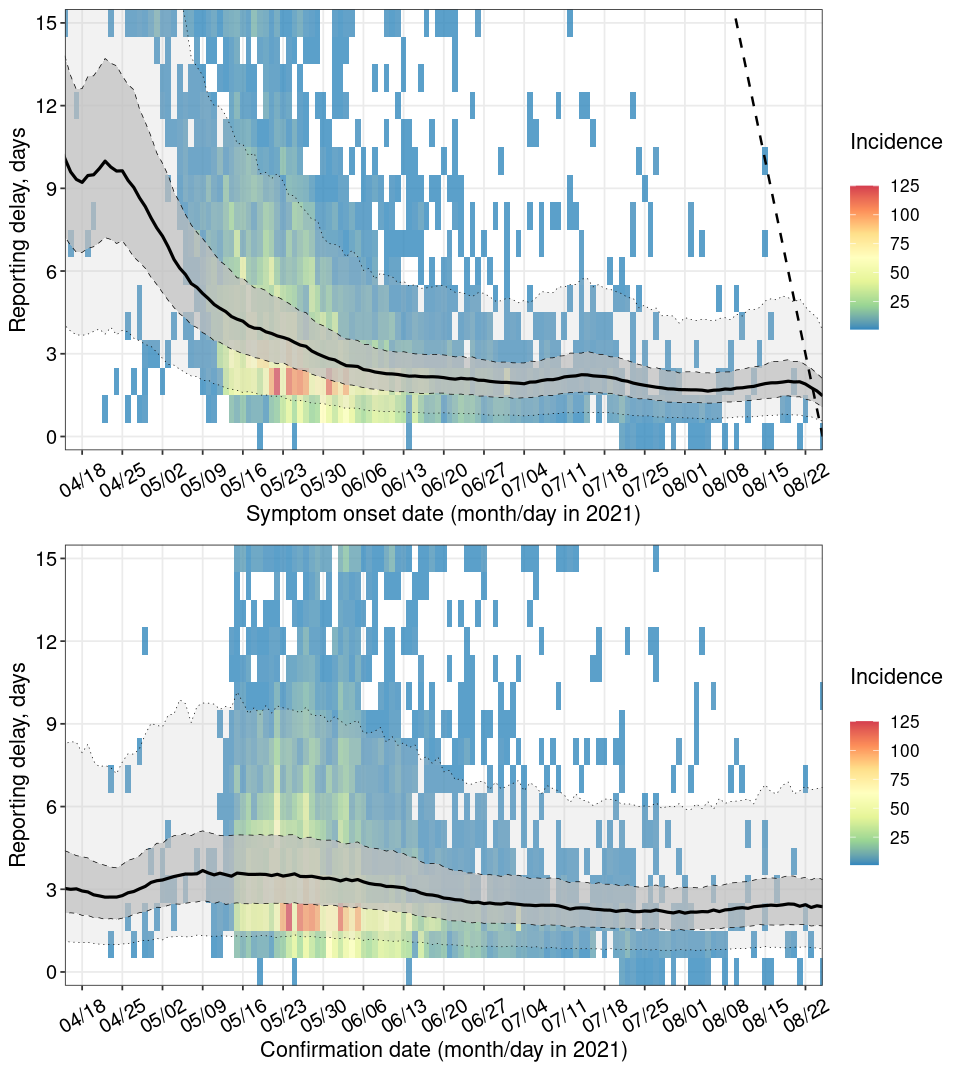

In [28]:
options(repr.plot.width=cs[1],repr.plot.height=2.1*cs[2])
plt = grid.arrange(plt1_delay, plt2_delay)

if (generateFigures) { for (filetype_ in c("pdf", "png"))
    ggsave(plot=plt, width=cs[1], height=2.1*cs[2], device = filetype_,
           filename=paste0(figures_dir,"/delay_combined_plot.",filetype_))
}

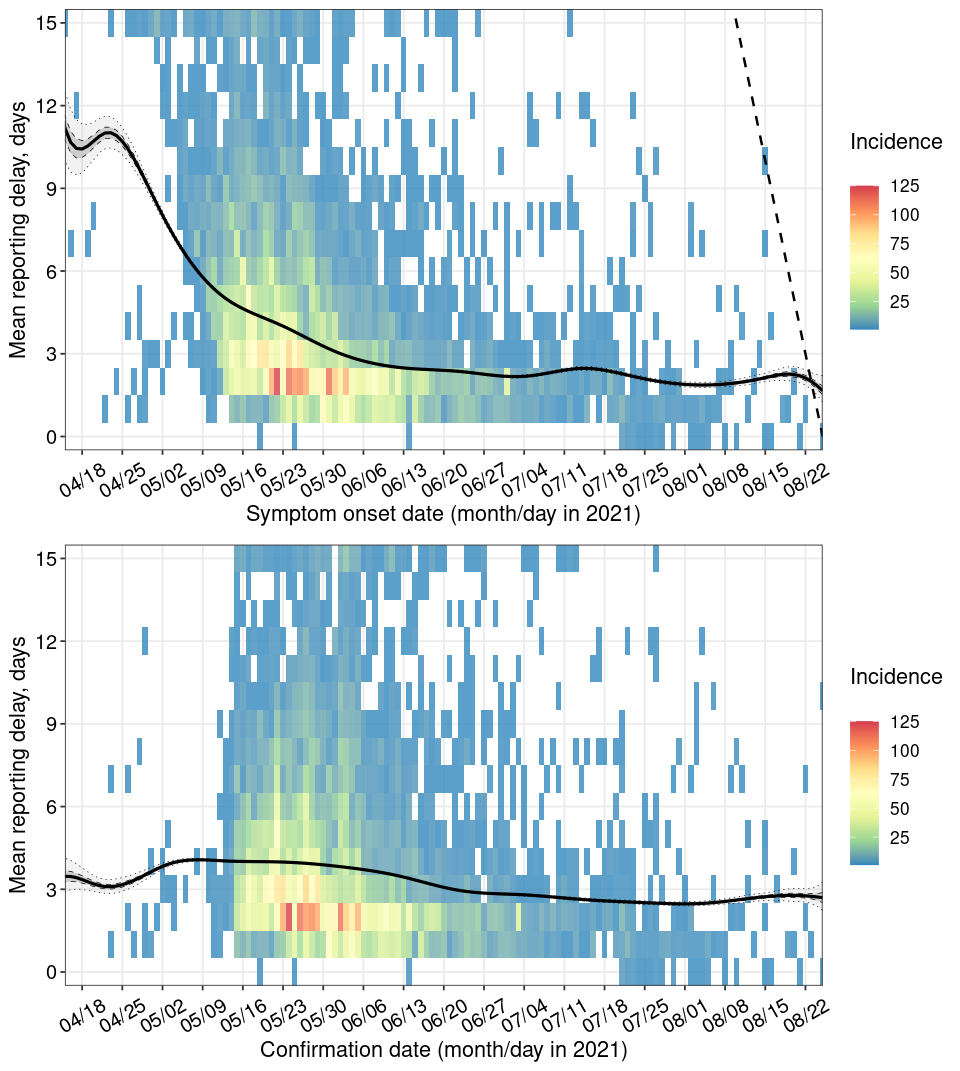

In [29]:
options(repr.plot.width=cs[1],repr.plot.height=2.1*cs[2])
plt = grid.arrange(plt1_mean_delay, plt2_mean_delay)

if (generateFigures) { for (filetype_ in c("pdf", "png"))
    ggsave(plot=plt, width=cs[1], height=2.1*cs[2], device = filetype_,
           filename=paste0(figures_dir,"/mean_delay_combined_plot.",filetype_))
}

## Using piecewise constant delay

In [30]:
stan_code_delay_piecewise_constant = 'data {
    int<lower=0> N; // number of records
    int<lower = 1> K; // truncation date
    int<lower = 1, upper=K> Kmax;
    array[N] int<lower=1, upper=K> onset_day; // illness onset left
    array[N] int<lower=1, upper=K> confirm_day; // confirmation left

    int<lower = 0, upper = 1> is_by_onset;

    int window; //window when Rt is constant
}

transformed data {
    array[Kmax] int index;
    for (day in 1:Kmax) 
        index[day] = (day - 1) %/% window + 1;
    int M = max(index);

    array[N] int delay_index;
    for (n in 1:N) {
        int day_ = is_by_onset ? onset_day[n] : confirm_day[n];
        delay_index[n] = index[day_];
    }
}

parameters {
    vector<lower=0, upper=1>[N] onset_raw, confirm_raw; 

    vector<lower = 0>[M] mean_delay, cv_delay;
}

model {
    /* priors */
    onset_raw ~ beta(1, 1);
    confirm_raw ~ beta(1, 1);

    mean_delay ~ normal(5, 5);
    cv_delay ~ std_normal();

    vector[N] onset = to_vector(onset_day) + onset_raw;
    vector[N] confirm;
    for (i in 1:N) 
        confirm[i] = (confirm_day[i] <= onset[i]) ? 
                        fma(confirm_day[i] + 1 - onset[i], confirm_raw[i], onset[i]) : 
                        confirm_day[i] + confirm_raw[i];
    vector[N] delay = confirm - onset;

    // Lognormal distribution is used for reporting delay as it was selected previously
    vector[M] param2_delay = sqrt(log(square(cv_delay) + 1.0)),
        param1_delay = log(mean_delay) - square(param2_delay) / 2.0;

    target += lognormal_lpdf(delay | param1_delay[delay_index], param2_delay[delay_index]) 
            - lognormal_lcdf(K + 0.5 - onset | param1_delay[delay_index], param2_delay[delay_index]);
}

generated quantities {
    vector[M] sd_delay = cv_delay .* mean_delay;
}'

In [31]:
#! change the following variable to TRUE if you want to re-run the simulations 
recalc_delay = F
generateFigures = T    
standistribdir = "../../../../CmdStan"

df %>% filter(!is.na(Onset)) -> df_
    
(mindate = df_$Onset |> min(na.rm=T) - 1)
(truncation_day = as.numeric(truncation_date - mindate))

df_ %<>% mutate(
   ReportDay = as.numeric(Report - mindate),
   OnsetDay = as.numeric(Onset - mindate),
   ConfirmDay = as.numeric(Confirm - mindate))
    
df_ %>% 
    mutate(OnsetDay = if_else(OnsetDay > ConfirmDay, ConfirmDay, OnsetDay), Delay = ConfirmDay - OnsetDay) -> df_delay
    
print("Number of cases: "%&%nrow(df_delay))
    
foo_delay = \(is_by_onset, window) {
    standirname_delay_onset = stanmaindir%&%"/delay_by_onset_piecewise_constant_window_"%&%window%&%"_"%&%format(truncation_date,"%Y%m%d")
    standirname_delay_confirm = stanmaindir%&%"/delay_by_confirm_piecewise_constant_window_"%&%window%&%"_"%&%format(truncation_date,"%Y%m%d")
    
    if (is_by_onset)
        standirname_delay = standirname_delay_onset
    else
        standirname_delay = standirname_delay_confirm
    stanscriptdir_delay = "../Dropbox/" %&% substring(standirname_delay,10)

    #unlink(standirname_delay, recursive=T)
    dir.create(standirname_delay)

    ## @data ##
    K = truncation_day
    Kmax = truncation_day - 1
    
    N = nrow(df_delay)
    onset_day = df_delay$OnsetDay
    confirm_day = df_delay$ConfirmDay
    rstan::stan_rdump(c("N", "onset_day", "confirm_day", "is_by_onset", "window", "K", "Kmax"), file=standirname_delay%&%"/Data.R")

    ## @init ##
    onset_raw = rep(.4, N)
    confirm_raw = rep(.7, N)
    rstan::stan_rdump(c("onset_raw", "confirm_raw"), file=standirname_delay%&%"/Init.R")

    ## @stan_script ##
    cat(stan_code_delay_piecewise_constant, file=standirname_delay %&% "/reporting_delay_piecewise_constant.stan", sep="", fill=TRUE)

    ## @bash file ##
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    rm "%&%stanscriptdir_delay%&%"/reporting_delay_piecewise_constant
    make -j6 "%&%stanscriptdir_delay%&%"/reporting_delay_piecewise_constant
    cd "%&%stanscriptdir_delay%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./reporting_delay_piecewise_constant \\
            method=sample num_samples=1250 num_warmup=2000 save_warmup=0\\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname_delay%&%"/fit_piecewise_constant.sh", sep="", fill=TRUE)

    ## @running the bash script ##
    system("bash "%&%standirname_delay%&%"/fit_piecewise_constant.sh", intern = TRUE)
};

window = 14
if (recalc_delay) {
    foo_delay(1, window); 
    foo_delay(0, window);
} 

[1] "2021-03-31"

[1] 147

[1] "Number of cases: 8646"


## Processing the traces

In [32]:
# by onset
window_ = 14
standirname_delay_onset = stanmaindir%&%"/delay_by_onset_piecewise_constant_window_"%&%window_%&%"_"%&%format(truncation_date,"%Y%m%d")
output_files = c(); idx = 1
for (fl_ in list.files(standirname_delay_onset, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_onset_piecewise_constant = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

In [33]:
mod_onset_piecewise_constant$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% 
    as.data.frame -> df_delay_piecewise_constant
names(df_delay_piecewise_constant) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_delay_piecewise_constant$variable, "[\\d+(.*)]")
df_delay_piecewise_constant$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_delay_piecewise_constant$OnsetDay = (df_delay_piecewise_constant$index - 1) * window + 1
                                           
# df_delay_piecewise_constant$OnsetDay = truncation_day - (df_delay_piecewise_constant$index - 1) * window
df_delay_piecewise_constant$Onset = mindate+df_delay_piecewise_constant$OnsetDay
# df_delay_piecewise_constant = df_delay_piecewise_constant |> select(-variable) |> arrange(Onset)
                                           
df_delay_piecewise_constant_ = df_delay_piecewise_constant |> tail(1)
df_delay_piecewise_constant_$OnsetDay = df_delay_piecewise_constant_$OnsetDay + window                      
df_delay_piecewise_constant_$Onset = df_delay_piecewise_constant_$Onset + window                      
df_delay_piecewise_constant = rbind(df_delay_piecewise_constant, df_delay_piecewise_constant_) |> select(-variable) |> arrange(Onset)
df_delay_piecewise_constant

median    lower    upper     IQR_lower IQR_upper index OnsetDay Onset     
1   14.918200 7.967077 22.962030 12.444200 17.700625  1      1      2021-04-01
2   10.847350 6.525890 16.713302  9.250585 12.753550  2     15      2021-04-15
3    7.771615 7.360838  8.246287  7.619438  7.926580  3     29      2021-04-29
4    4.563900 4.463506  4.663534  4.528643  4.598165  4     43      2021-05-13
5    2.995735 2.914718  3.083455  2.967952  3.024890  5     57      2021-05-27
6    2.585725 2.461862  2.716691  2.541585  2.629960  6     71      2021-06-10
7    2.302955 2.150153  2.469081  2.247397  2.356820  7     85      2021-06-24
8    2.716230 2.400658  3.113640  2.595623  2.840630  8     99      2021-07-08
9    2.732785 1.988224  4.207880  2.423848  3.124532  9    113      2021-07-22
10   2.711195 1.537347  6.162015  2.166035  3.481967 10    127      2021-08-05
11   2.214645 0.589214 10.569612  1.286245  4.256005 11    141      2021-08-19
111  2.214645 0.589214 10.569612  1.286245  4.256005 11    155      2021-09-02

`summarise()` has grouped output by 't'. You can override using the `.groups` argument.

Joining, by = c("t", "d")



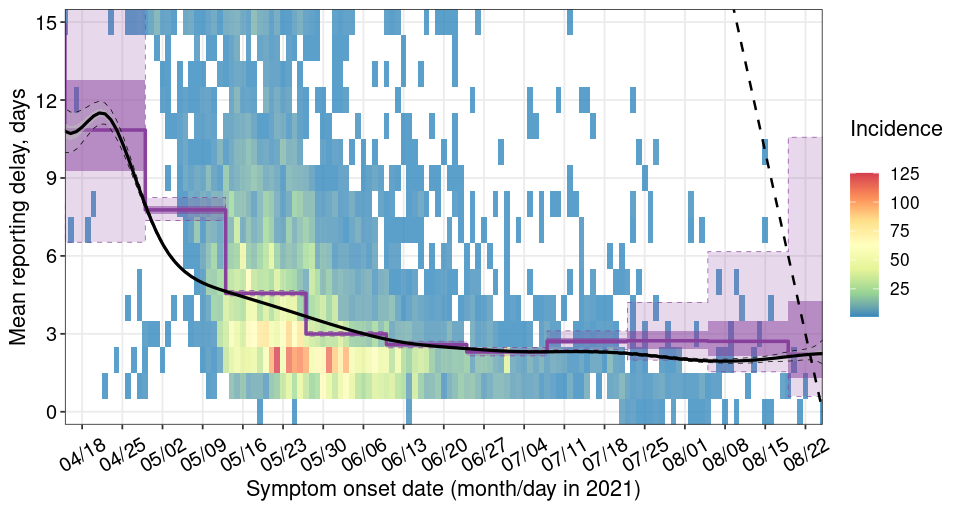

In [34]:
maxdelay = 15
Cases = df_ %>%
    mutate(t = OnsetDay, d = ConfirmDay - OnsetDay,
           d = if_else(d>maxdelay, maxdelay, d)) %>% group_by(t,d) %>% summarize(n=n()) %>%
    right_join(expand_grid(t = seq(from = 1, to = truncation_day, by = 1), d = seq(from = 0, to = maxdelay, by = 1))) %>%
    mutate(t_date = t + mindate) %>%
    replace(is.na(.), 0) 

cl_ = "#88419d"
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        geom_tile(aes(y = d, fill=n), alpha=.8) +
        scale_fill_distiller(palette = "Spectral", direction=-1) +
        coord_cartesian(expand=F, ylim=c(-.5,maxdelay+0.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='Mean reporting delay, days', fill="Incidence\n") +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +

        geom_step(data = df_delay_piecewise_constant, 
                  aes(x=Onset,y=median), color=cl_, linetype="solid", size=1, alpha=1) +
        geom_step(data = df_delay_piecewise_constant, aes(x=Onset,y=upper), color=cl_, linetype="dashed", size=.2, alpha=1) +
        geom_step(data = df_delay_piecewise_constant, aes(x=Onset,y=lower), color=cl_, linetype="dashed", size=.2, alpha=1) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_delay_piecewise_constant, aes(x=Onset, ymax=IQR_upper, ymin=IQR_lower), fill=cl_, 
                    size=0, alpha = .5) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_delay_piecewise_constant, aes(x=Onset, ymax=upper, ymin=lower), fill=cl_, 
                    size=0, alpha = .2) +

        geom_ribbon(data = df_mean_delay_onset %>% rename(t_date = d), aes(ymax=IQR_upper, ymin=IQR_lower), fill="grey", 
                    size=0, alpha = .5) +
        geom_ribbon(data = df_mean_delay_onset %>% rename(t_date = d), aes(ymax=upper, ymin=lower), fill="grey", 
                    linetype='dotted', size=0, alpha = .2) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=upper), linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=lower), linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay_onset %>% rename(t_date = d), aes(y=median), color="black", size=.9, alpha=1) +

        geom_line(data=data.frame(t=seq(from = 1, to = truncation_day, by = 1)) %>% 
                          mutate(d = truncation_day-t, t_date = mindate + t), aes(y=d), color="black", linetype='dashed', size=.7) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks) +
        scale_y_continuous(breaks = y_brks) -> plt1

plt1

if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/delay_all_by_onset.",filetype_))
}

In [35]:
mod_onset_piecewise_constant$summary(c("cv_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% 
    as.data.frame -> df_cv_delay_piecewise_constant
names(df_cv_delay_piecewise_constant) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_cv_delay_piecewise_constant$variable, "[\\d+(.*)]")
df_cv_delay_piecewise_constant$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_cv_delay_piecewise_constant$OnsetDay = (df_cv_delay_piecewise_constant$index - 1) * window + 1
                                           
df_cv_delay_piecewise_constant$Onset = mindate+df_cv_delay_piecewise_constant$OnsetDay
                                           
df_cv_delay_piecewise_constant_ = df_cv_delay_piecewise_constant |> tail(1)
df_cv_delay_piecewise_constant_$OnsetDay = df_cv_delay_piecewise_constant_$OnsetDay + window                      
df_cv_delay_piecewise_constant_$Onset = df_cv_delay_piecewise_constant_$Onset + window                      
df_cv_delay_piecewise_constant = rbind(df_cv_delay_piecewise_constant, df_cv_delay_piecewise_constant_) |> select(-variable) |> arrange(Onset)
df_cv_delay_piecewise_constant

median    lower     upper     IQR_lower IQR_upper index OnsetDay Onset     
1   1.2686950 0.6107953 2.5617558 0.9757153 1.6267650  1      1      2021-04-01
2   1.9064950 1.2906297 2.8800637 1.6584725 2.1951600  2     15      2021-04-15
3   0.6135640 0.5675790 0.6652974 0.5972515 0.6306870  3     29      2021-04-29
4   0.7087325 0.6890827 0.7296984 0.7015705 0.7157982  4     43      2021-05-13
5   0.7027620 0.6766349 0.7305143 0.6934455 0.7127133  5     57      2021-05-27
6   0.7510385 0.7037381 0.8068461 0.7344000 0.7684462  6     71      2021-06-10
7   0.6535685 0.5900428 0.7293826 0.6295610 0.6780865  7     85      2021-06-24
8   0.8132665 0.6969578 0.9686232 0.7684767 0.8613748  8     99      2021-07-08
9   1.9661900 1.4033995 2.9450010 1.7372950 2.2374100  9    113      2021-07-22
10  1.7744150 1.0236750 3.1626475 1.4477900 2.1697025 10    127      2021-08-05
11  1.3921500 0.3734243 2.8237410 0.9670965 1.8500375 11    141      2021-08-19
111 1.3921500 0.3734243 2.8237410 0.9670965 1.8500375 11    155      2021-09-02

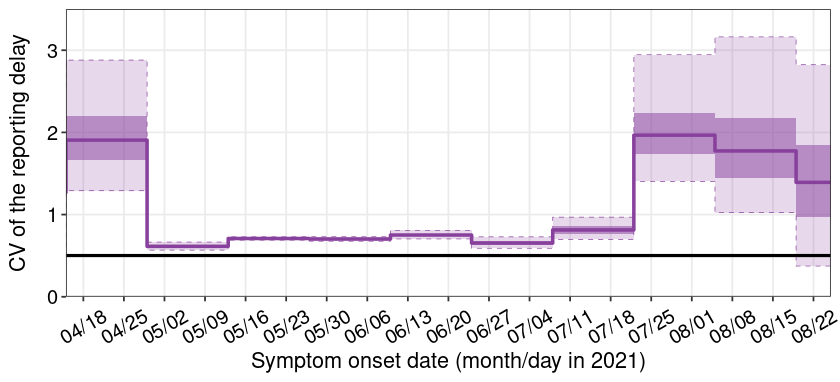

In [36]:
df_cv_delay_onset |> rbind(df_cv_delay_onset) |>
    mutate(Onset = c(min(df_cv_delay_piecewise_constant$Onset), max(df_cv_delay_piecewise_constant$Onset))) -> df_cv_delay_onset_

cs1_cv = cs[1]-1
cs2_cv = .75*cs[2]
options(repr.plot.width=cs1_cv,repr.plot.height=cs2_cv)
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        coord_cartesian(expand=F, ylim=c(0,3.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Symptom onset date (month/day in 2021)', y='CV of the reporting delay') +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
              panel.grid.minor = element_blank()) +

        geom_step(data = df_cv_delay_piecewise_constant, 
                  aes(x=Onset,y=median), color=cl_, linetype="solid", size=1, alpha=1) +
        geom_step(data = df_cv_delay_piecewise_constant, aes(x=Onset,y=upper), color=cl_, linetype="dashed", size=.2, alpha=1) +
        geom_step(data = df_cv_delay_piecewise_constant, aes(x=Onset,y=lower), color=cl_, linetype="dashed", size=.2, alpha=1) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_cv_delay_piecewise_constant, aes(x=Onset, ymax=IQR_upper, ymin=IQR_lower), fill=cl_, 
                    size=0, alpha = .5) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_cv_delay_piecewise_constant, aes(x=Onset, ymax=upper, ymin=lower), fill=cl_, 
                    size=0, alpha = .2) +
        geom_line(data = df_cv_delay_onset_ %>% rename(t_date = Onset), aes(y=median), color="black", size=.9, alpha=1) +

        scale_x_date(date_labels="%m/%d", breaks = date_brks) -> plt1_cv

plt1_cv

if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt1_cv, width=cs1_cv, height=cs2_cv, device = filetype_,
               filename=paste0(figures_dir,"/cv_delay_all_by_onset.",filetype_))
}

In [37]:
# by confirmation
standirname_delay_confirm = stanmaindir%&%"/delay_by_confirm_piecewise_constant_window_"%&%window_%&%"_"%&%format(truncation_date,"%Y%m%d")
output_files = c(); idx = 1
for (fl_ in list.files(standirname_delay_confirm, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_confirm_piecewise_constant = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

In [38]:
mod_confirm_piecewise_constant$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% 
    as.data.frame -> df_delay_piecewise_constant
names(df_delay_piecewise_constant) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_delay_piecewise_constant$variable, "[\\d+(.*)]")
df_delay_piecewise_constant$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_delay_piecewise_constant$OnsetDay = (df_delay_piecewise_constant$index - 1) * window + 1
                                           
# df_delay_piecewise_constant$OnsetDay = truncation_day - (df_delay_piecewise_constant$index - 1) * window
df_delay_piecewise_constant$Onset = mindate+df_delay_piecewise_constant$OnsetDay
# df_delay_piecewise_constant = df_delay_piecewise_constant |> select(-variable) |> arrange(Onset)
                                           
df_delay_piecewise_constant_ = df_delay_piecewise_constant |> tail(1)
df_delay_piecewise_constant_$OnsetDay = df_delay_piecewise_constant_$OnsetDay + window                      
df_delay_piecewise_constant_$Onset = df_delay_piecewise_constant_$Onset + window                      
df_delay_piecewise_constant = rbind(df_delay_piecewise_constant, df_delay_piecewise_constant_) |> select(-variable) |> arrange(Onset)
df_delay_piecewise_constant

median   lower     upper     IQR_lower IQR_upper index OnsetDay Onset     
1   6.071165 0.5254344 14.882742 3.451055  9.116095   1      1      2021-04-01
2   4.665445 2.0568930 10.466462 3.521280  6.182677   2     15      2021-04-15
3   3.274240 2.6326575  4.327712 3.018610  3.555415   3     29      2021-04-29
4   4.207680 4.1148897  4.305491 4.173598  4.241020   4     43      2021-05-13
5   4.124360 4.0117585  4.241982 4.086985  4.163615   5     57      2021-05-27
6   3.151285 3.0038172  3.316004 3.099570  3.205863   6     71      2021-06-10
7   2.939875 2.7134197  3.193194 2.856197  3.026568   7     85      2021-06-24
8   3.177600 2.7742238  3.682608 3.033988  3.340517   8     99      2021-07-08
9   2.860335 2.1557853  4.167876 2.574390  3.213955   9    113      2021-07-22
10  4.016045 2.3413805  8.160485 3.234703  5.032265  10    127      2021-08-05
11  4.017565 1.4788550 11.457422 2.725298  6.086900  11    141      2021-08-19
111 4.017565 1.4788550 11.457422 2.725298  6.086900  11    155      2021-09-02

`summarise()` has grouped output by 't'. You can override using the `.groups` argument.

Joining, by = c("t", "d")



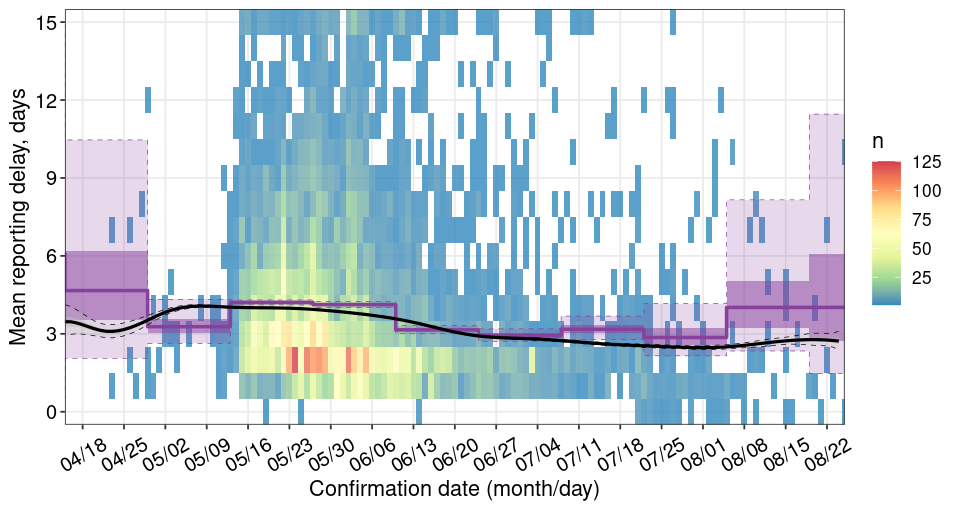

In [39]:
mod_confirm$summary(c("mean_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_mean_delay
names(df_mean_delay) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_mean_delay$variable, "[\\d+(.*)]")
df_mean_delay$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_mean_delay %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d=mindate+index) %>% 
                             select(-variable, -index) %>% filter(d<=truncation_date-1)
 
maxdelay = 15
Cases = df_ %>%
    mutate(t = ConfirmDay, d = ConfirmDay - OnsetDay,
           d = if_else(d>maxdelay, maxdelay, d)) %>% group_by(t,d) %>% summarize(n=n()) %>%
    right_join(expand_grid(t = seq(from = 1, to = truncation_day, by = 1), d = seq(from = 0, to = maxdelay, by = 1))) %>%
    mutate(t_date = t + mindate) %>%
    replace(is.na(.), 0) 
    
mindate_plt = as.Date("2021-04-15")                           
                             
options(repr.plot.width=cs[1],repr.plot.height=cs[2])
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        geom_tile(aes(y = d, fill=n), alpha=.8) +
        scale_fill_distiller(palette = "Spectral", direction=-1) +
        coord_cartesian(expand=F, ylim=c(-.5,maxdelay+.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Confirmation date (month/day)', y='Mean reporting delay, days') +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              panel.grid.minor = element_blank()) +
                             
        geom_step(data = df_delay_piecewise_constant, 
                  aes(x=Onset,y=median), color=cl_, linetype="solid", size=1, alpha=1) +
        geom_step(data = df_delay_piecewise_constant, aes(x=Onset,y=upper), color=cl_, linetype="dashed", size=.2, alpha=1) +
        geom_step(data = df_delay_piecewise_constant, aes(x=Onset,y=lower), color=cl_, linetype="dashed", size=.2, alpha=1) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_delay_piecewise_constant, aes(x=Onset, ymax=IQR_upper, ymin=IQR_lower), fill=cl_, 
                    size=0, alpha = .5) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_delay_piecewise_constant, aes(x=Onset, ymax=upper, ymin=lower), fill=cl_, 
                    size=0, alpha = .2) +
                             
        geom_ribbon(data = df_mean_delay %>% rename(t_date = d), aes(ymax=IQR_upper, ymin=IQR_lower), fill="grey", size=0, alpha = .5) +
        geom_ribbon(data = df_mean_delay %>% rename(t_date = d), aes(ymax=upper, ymin=lower), fill="grey", linetype='dotted', size=0, alpha = .2) +
        geom_line(data = df_mean_delay %>% rename(t_date = d), aes(y=upper), linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay %>% rename(t_date = d), aes(y=lower), linetype='dashed', color="black", size=.2, alpha=1) +
        geom_line(data = df_mean_delay %>% rename(t_date = d), aes(y=median), color="black", size=.9, alpha=1) +
        scale_x_date(date_labels="%m/%d", breaks = date_brks) +
        scale_y_continuous(breaks = y_brks) -> plt2

plt2
                             
if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt2, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/delay_all_by_confirmation.",filetype_))
}

In [40]:
mod_confirm_piecewise_constant$summary(c("cv_delay"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% 
    as.data.frame -> df_cv_delay_piecewise_constant
names(df_cv_delay_piecewise_constant) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_cv_delay_piecewise_constant$variable, "[\\d+(.*)]")
df_cv_delay_piecewise_constant$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_cv_delay_piecewise_constant$OnsetDay = (df_cv_delay_piecewise_constant$index - 1) * window + 1
                                           
df_cv_delay_piecewise_constant$Onset = mindate+df_cv_delay_piecewise_constant$OnsetDay
                                           
df_cv_delay_piecewise_constant_ = df_cv_delay_piecewise_constant |> tail(1)
df_cv_delay_piecewise_constant_$OnsetDay = df_cv_delay_piecewise_constant_$OnsetDay + window                      
df_cv_delay_piecewise_constant_$Onset = df_cv_delay_piecewise_constant_$Onset + window                      
df_cv_delay_piecewise_constant = rbind(df_cv_delay_piecewise_constant, df_cv_delay_piecewise_constant_) |> select(-variable) |> arrange(Onset)
df_cv_delay_piecewise_constant

median    lower      upper     IQR_lower IQR_upper index OnsetDay
1   0.6895940 0.02433676 2.2702585 0.3262808 1.1575600  1      1     
2   1.6046500 0.87441342 2.8100605 1.2962350 1.9952575  2     15     
3   0.6900560 0.50024765 1.0168325 0.6085567 0.7777840  3     29     
4   0.6559620 0.63500932 0.6779972 0.6486278 0.6634225  4     43     
5   0.8600880 0.83233310 0.8897563 0.8502923 0.8699188  5     57     
6   0.8668135 0.81645960 0.9218353 0.8492995 0.8853755  6     71     
7   0.8837015 0.80616715 0.9762664 0.8549857 0.9137157  7     85     
8   0.9200890 0.78877788 1.0999147 0.8698577 0.9756915  8     99     
9   1.7886050 1.32324700 2.5538708 1.5956625 2.0050600  9    113     
10  2.0569750 1.26849775 3.2419250 1.7398800 2.4197150 10    127     
11  1.6569650 0.82533130 2.8687430 1.3218250 2.0401675 11    141     
111 1.6569650 0.82533130 2.8687430 1.3218250 2.0401675 11    155     
    Onset     
1   2021-04-01
2   2021-04-15
3   2021-04-29
4   2021-05-13
5   2021-05-27
6   2021-06-10
7   2021-06-24
8   2021-07-08
9   2021-07-22
10  2021-08-05
11  2021-08-19
111 2021-09-02

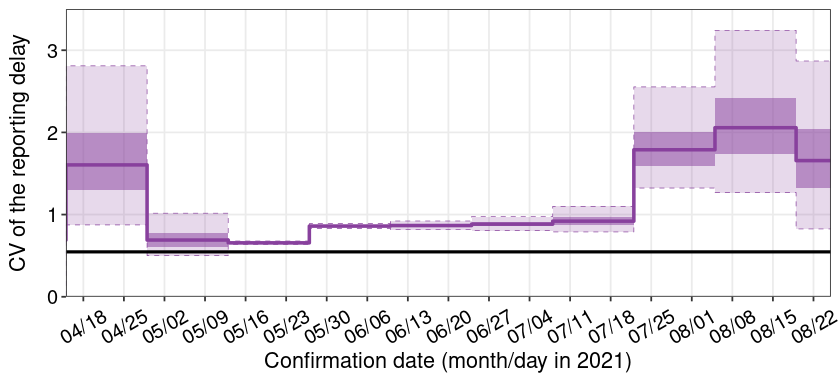

In [41]:
df_cv_delay_confirm |> rbind(df_cv_delay_confirm) |>
    mutate(Onset = c(min(df_cv_delay_piecewise_constant$Onset), max(df_cv_delay_piecewise_constant$Onset))) -> df_cv_delay_onset_

options(repr.plot.width=cs1_cv,repr.plot.height=cs2_cv)
Cases %>% filter(n>0) %>%
    ggplot(aes(x=t_date)) + 
        coord_cartesian(expand=F, ylim=c(0,3.5), xlim=c(mindate_plt,truncation_date)) +
        labs(x='Confirmation date (month/day in 2021)', y='CV of the reporting delay') +
        theme_bw() +
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text = element_text(size=12, family="sans", color="black"),
              axis.text.x = element_text(angle=30,vjust=.5),
              axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
              panel.grid.minor = element_blank()) +

        geom_step(data = df_cv_delay_piecewise_constant, 
                  aes(x=Onset,y=median), color=cl_, linetype="solid", size=1, alpha=1) +
        geom_step(data = df_cv_delay_piecewise_constant, aes(x=Onset,y=upper), color=cl_, linetype="dashed", size=.2, alpha=1) +
        geom_step(data = df_cv_delay_piecewise_constant, aes(x=Onset,y=lower), color=cl_, linetype="dashed", size=.2, alpha=1) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_cv_delay_piecewise_constant, aes(x=Onset, ymax=IQR_upper, ymin=IQR_lower), fill=cl_, 
                    size=0, alpha = .5) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = df_cv_delay_piecewise_constant, aes(x=Onset, ymax=upper, ymin=lower), fill=cl_, 
                    size=0, alpha = .2) +
        geom_line(data = df_cv_delay_onset_ %>% rename(t_date = Onset), aes(y=median), color="black", size=.9, alpha=1) +

        scale_x_date(date_labels="%m/%d", breaks = date_brks) -> plt2_cv

plt2_cv

if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt2_cv, width=cs1_cv, height=cs2_cv, device = filetype_,
               filename=paste0(figures_dir,"/cv_delay_all_by_confirm.",filetype_))
}

# Rt estimation

In [42]:
df %>% mutate(t = OnsetDay) %>% count(t) %>% rename(Onset = n) -> df_cases
df_cases$t = as.numeric(df_cases$t)
df_cases %<>% 
    right_join(expand_grid(t = seq(from = 1, to = truncation_day, by = 1)), by="t")

df %>% filter(is.na(OnsetDay)) %>% mutate(t=ConfirmDay) %>% count(t) %>% rename(n_unobs = n) %>%
    right_join(df_cases %>% rename(n = Onset), by='t') %>% replace(is.na(.), 0) %>% arrange(t) -> df_cases

df_cases %<>% mutate(d = mindate + t)

df_cases %>% t

[,1]       [,2]       [,3]       [,4]       [,5]       [,6]      
t         1          2          3          4          5          6       
n_unobs   0          0          0          0          0          0       
n         1          0          0          0          1          1       
d       2021-04-01 2021-04-02 2021-04-03 2021-04-04 2021-04-05 2021-04-06
        [,7]       [,8]       [,9]       [,10]      [,11] [,12]      [,13]     
t         7          8          9         10        ⋯     138        139       
n_unobs   0          0          0          0        ⋯       3          5       
n         0          0          0          0        ⋯       2          0       
d       2021-04-07 2021-04-08 2021-04-09 2021-04-10 ⋯     2021-08-16 2021-08-17
        [,14]      [,15]      [,16]      [,17]      [,18]      [,19]     
t       140        141        142        143        144        145       
n_unobs   1          3          0          5          2          0       
n         3          1          1          1          1          0       
d       2021-08-18 2021-08-19 2021-08-20 2021-08-21 2021-08-22 2021-08-23
        [,20]      [,21]     
t       146        147       
n_unobs   0          0       
n         0          1       
d       2021-08-24 2021-08-25

In [43]:
## will be required later
# by onset
spline_window_ = baseline_spline_window
half_delay_sliding_window_ = baseline_half_delay_sliding_window
standirname_delay_onset = stanmaindir%&%"/delay_mixture_by_onset_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
output_files = c(); idx = 1
for (fl_ in list.files(standirname_delay_onset, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_onset = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

In [ ]:
log_mean_delay_onset_median = c()
log_mean_delay_onset_IQR = c()
log_mean_delay_onset_asymmetry = c()
log_mean_delay_onset_steepness = c()
for (k in 1:truncation_day) {
    log_mean_delay_onset_median = c(log_mean_delay_onset_median, log(median(mod_onset$draws(paste0("mean_delay[",k,"]")))))
    log_mean_delay_onset_IQR = c(log_mean_delay_onset_IQR, log(as.numeric(quantile(mod_onset$draws(paste0("mean_delay[",k,"]")), 0.75))) - log(as.numeric(quantile(mod_onset$draws(paste0("mean_delay[",k,"]")), 0.25))))
    options(warn=-1)
    a_s_log_mean_delay_onset = GLD_solver(lower_quartile = log(as.numeric(quantile(mod_onset$draws(paste0("mean_delay[",k,"]")), 0.25))), 
              median = log_mean_delay_onset_median[k], 
              upper_quartile = log(as.numeric(quantile(mod_onset$draws(paste0("mean_delay[",k,"]")), 0.75))),
              other_quantile = log(as.numeric(quantile(mod_onset$draws(paste0("mean_delay[",k,"]")), 0.10))), alpha = 0.10)
    options(warn=0)
    log_mean_delay_onset_asymmetry = c(log_mean_delay_onset_asymmetry, a_s_log_mean_delay_onset[['asymmetry']])
    log_mean_delay_onset_steepness = c(log_mean_delay_onset_steepness, a_s_log_mean_delay_onset[['steepness']])
}

In [45]:
options(warn=-1)
log_cv_delay_onset_median = log(median(mod_onset$draws("cv_delay")))
log_cv_delay_onset_IQR = log(as.numeric(quantile(mod_onset$draws("cv_delay"), 0.75))) - log(as.numeric(quantile(mod_onset$draws("cv_delay"), 0.25)))
a_s_log_cv_delay_onset = GLD_solver(lower_quartile = log(as.numeric(quantile(mod_onset$draws("cv_delay"), 0.25))), 
          median = log_cv_delay_onset_median, 
          upper_quartile = log(as.numeric(quantile(mod_onset$draws("cv_delay"), 0.75))),
          other_quantile = log(as.numeric(quantile(mod_onset$draws("cv_delay"), 0.10))), alpha = 0.10)
options(warn=0)
(log_cv_delay_onset_median)
(log_cv_delay_onset_IQR)
(a_s_log_cv_delay_onset)
log_cv_delay_onset_asymmetry = a_s_log_cv_delay_onset[['asymmetry']]
log_cv_delay_onset_steepness = a_s_log_cv_delay_onset[['steepness']]

[1] -0.6904438

[1] 0.003818035

asymmetry  steepness 
0.07327653 0.50223550

In [46]:
## by confirmation
standirname_delay_confirm = stanmaindir%&%"/delay_mixture_by_confirm_window_"%&%spline_window_%&%"_"%&%half_delay_sliding_window_%&%"_"%&%format(truncation_date,"%Y%m%d")
output_files = c(); idx = 1
for (fl_ in list.files(standirname_delay_confirm, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_confirm = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

In [ ]:
log_mean_delay_confirm_median = c()
log_mean_delay_confirm_IQR = c()
log_mean_delay_confirm_asymmetry = c()
log_mean_delay_confirm_steepness = c()
for (k in 1:truncation_day) {
    log_mean_delay_confirm_median = c(log_mean_delay_confirm_median, log(median(mod_confirm$draws(paste0("mean_delay[",k,"]")))))
    log_mean_delay_confirm_IQR = c(log_mean_delay_confirm_IQR, log(as.numeric(quantile(mod_confirm$draws(paste0("mean_delay[",k,"]")), 0.75))) - log(as.numeric(quantile(mod_confirm$draws(paste0("mean_delay[",k,"]")), 0.25))))
    options(warn=-1)
    a_s_log_mean_delay_confirm = GLD_solver(lower_quartile = log(as.numeric(quantile(mod_confirm$draws(paste0("mean_delay[",k,"]")), 0.25))), 
              median = log(median(mod_confirm$draws(paste0("mean_delay[",k,"]")))), 
              upper_quartile = log(as.numeric(quantile(mod_confirm$draws(paste0("mean_delay[",k,"]")), 0.75))),
              other_quantile = log(as.numeric(quantile(mod_confirm$draws(paste0("mean_delay[",k,"]")), 0.10))), alpha = 0.10)
    options(warn=0)
    log_mean_delay_confirm_asymmetry = c(log_mean_delay_confirm_asymmetry, a_s_log_mean_delay_confirm[['asymmetry']])
    log_mean_delay_confirm_steepness = c(log_mean_delay_confirm_steepness, a_s_log_mean_delay_confirm[['steepness']])
}

In [48]:
log_cv_delay_confirm_median = log(median(mod_confirm$draws("cv_delay")))
log_cv_delay_confirm_IQR = log(as.numeric(quantile(mod_confirm$draws("cv_delay"), 0.75))) - log(as.numeric(quantile(mod_confirm$draws("cv_delay"), 0.25)))
options(warn=-1)
a_s_log_cv_delay_confirm = GLD_solver(lower_quartile = log(as.numeric(quantile(mod_confirm$draws("cv_delay"), 0.25))), 
          median = log(median(mod_confirm$draws("cv_delay"))), 
          upper_quartile = log(as.numeric(quantile(mod_confirm$draws("cv_delay"), 0.75))),
          other_quantile = log(as.numeric(quantile(mod_confirm$draws("cv_delay"), 0.10))), alpha = 0.10)
options(warn=0)
(log_cv_delay_confirm_median)
(log_cv_delay_confirm_IQR)
(a_s_log_cv_delay_confirm)
log_cv_delay_confirm_asymmetry = a_s_log_cv_delay_confirm[['asymmetry']]
log_cv_delay_confirm_steepness = a_s_log_cv_delay_confirm[['steepness']]

[1] -0.5798622

[1] 0.004027487

asymmetry   steepness 
-0.04564972  0.33372776

In [49]:
foo = \(x, phi) {
    f = \(rate) { pgamma(x, rate*x + 1, rate) - phi }
    return(uniroot(f, lower = 1, upper = 100)$root) }

(param2_lambda = foo(12.3, 0.44))
(param1_lambda = param2_lambda*12.3 + 1)   

[1] 1.576576

[1] 20.39189

# <font color="purple">Stan for Rt by time of onset / time of infection</font>

## Effective reproduction number by date of symptom onset

In [50]:
window_ = 3
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_onset_nbinom_window-"%&%(2*window_+1)
#unlink(standirname, recursive=T)
dir.create(standirname)

fileName = "qfunctions.stan"
qfunctions_txt = readChar(fileName, file.info(fileName)$size)

stan_code_Rt = 'functions {
    '%&%qfunctions_txt%&%'

    /* discretized version of gamma distribution used for generation time */
    vector pgamma(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(gamma_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of lognormal distribution used for the reporting delay */
    vector plognormal(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }
}

data {
    int<lower = 1> K; // truncation date
    array[K] int<lower = 0> cases_onset, // number of cases with symptoms onset on given days 1...K
                            cases_unobs; // number of cases with unknown symptoms onset on given days of confirmation 1..K

    // serial interval (modeled by gamma distribution)
    real<lower = 0> mu_SI, sigma_SI; 

    // delay
    array[K] real log_mean_delay_onset_median, log_mean_delay_onset_IQR, log_mean_delay_onset_asymmetry, log_mean_delay_onset_steepness,
                  log_mean_delay_confirm_median, log_mean_delay_confirm_IQR, log_mean_delay_confirm_asymmetry, log_mean_delay_confirm_steepness;
    real log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness,
         log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness;

    int window;
}

transformed data {
    // Serial interval (modeled by gamma distribution)
    real<lower = 0> param1_SI = square(mu_SI / sigma_SI), param2_SI = mu_SI / square(sigma_SI);
    vector[K] gt = pgamma(param1_SI, param2_SI, K),
              gt_rev = reverse(gt);    

    // for smoothing
    array[K] int index_min_Rt_onset, index_max_Rt_onset;
    for (day in 1:K) {
        index_min_Rt_onset[day] = day - window >= 2 ? day - window : 2;
        index_max_Rt_onset[day] = day + window <= K - 1 ? day + window : K-1;
    }
}

parameters {
    vector<lower = 0, upper = 1>[K] p_mean_delay_onset, p_mean_delay_confirm;
    real<lower = 0, upper = 1> p_cv_delay_onset, p_cv_delay_confirm;

    vector<lower = 0>[K-2] Rt_onset;
    real<lower = 0> phi_onset;
}

transformed parameters {
    row_vector<lower = 0>[K] mean_delay_onset, mean_delay_confirm;
    real<lower = 0> cv_delay_onset, cv_delay_confirm;
    for (k in 1:K) {
        mean_delay_onset[k] = exp(GLD_icdf(p_mean_delay_onset[k], log_mean_delay_onset_median[k], log_mean_delay_onset_IQR[k], log_mean_delay_onset_asymmetry[k], log_mean_delay_onset_steepness[k]));
        mean_delay_confirm[k] = exp(GLD_icdf(p_mean_delay_confirm[k], log_mean_delay_confirm_median[k], log_mean_delay_confirm_IQR[k], log_mean_delay_confirm_asymmetry[k], log_mean_delay_confirm_steepness[k]));
    }
    cv_delay_onset = exp(GLD_icdf(p_cv_delay_onset, log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness));
    cv_delay_confirm = exp(GLD_icdf(p_cv_delay_confirm, log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness));

    // Lognormal distribution is used for reporting delay as it was selected previously
    real param2_delay_onset = sqrt(log(square(cv_delay_onset) + 1.0)),
         param2_delay_confirm = sqrt(log(square(cv_delay_confirm) + 1.0));
    row_vector[K] param1_delay_onset = log(mean_delay_onset) - square(param2_delay_onset) / 2.0,
                  param1_delay_confirm = log(mean_delay_confirm) - square(param2_delay_confirm) / 2.0;
}

model {
    /* priors */
    Rt_onset ~ normal(5, 5);
    phi_onset ~ cauchy(0, 5);

    vector[K] cases_predicted = to_vector(cases_onset);
    // (1) backprojection of cases with unknown dates of symptom onset 
    //// in this case we use the delay by date of confirmation
    array[K] vector[K] delay_by_confirm;
    for (day in 1:K)
        delay_by_confirm[day] = plognormal(param1_delay_confirm[day], param2_delay_confirm, K);
    //// adding to the case count
    for (day in 1:K-1)
        for (k in (day+1):K)
            cases_predicted[day] += cases_unobs[k] * delay_by_confirm[k, k - day];
    // (2) nowcasting of all cases
    //// in this case we use the delay by date of symptoms onset
    vector[K] cases_nowcasted;
    for (day in 1:K)
        cases_nowcasted[day] = cases_predicted[day] / exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));

    // Rt by date of symptoms onset
    for (day in 2:K-1) if (cases_nowcasted[day] > 0) {
        vector[index_max_Rt_onset[day]-index_min_Rt_onset[day]+1] Rts = Rt_onset[index_min_Rt_onset[day]-1:index_max_Rt_onset[day]-1];
        real conv_Rt_onset = (day==2) ? cases_nowcasted[1] * gt[1] : dot_product(head(cases_nowcasted, day - 1), tail(gt_rev, day - 1));
        vector[index_max_Rt_onset[day]-index_min_Rt_onset[day]+1] mu_onset = Rts * conv_Rt_onset;
        vector[index_max_Rt_onset[day]-index_min_Rt_onset[day]+1] r_onset = phi_onset ./ (phi_onset + mu_onset);
        vector[index_max_Rt_onset[day]-index_min_Rt_onset[day]+1] a_onset = mu_onset .* r_onset;
        target += gamma_lpdf(cases_nowcasted[day] | a_onset, r_onset);
    }
}

generated quantities {  
    array[K-1] int cases_backprj = rep_array(0, K-1), 
                   cases_nowcasted = rep_array(0, K-1), 
                   cases_predicted; 
    {
        for (day in 2:K) if (cases_unobs[day] > 0) {
            vector[day-1] delay_by_confirm = plognormal(param1_delay_confirm[day], param2_delay_confirm, day-1);
            vector[day-1] probs = reverse(delay_by_confirm) ./ sum(delay_by_confirm);
            array[day-1] int counts = multinomial_rng(probs, cases_unobs[day]);
            for (i in 1:day-1) 
                cases_backprj[i] += counts[i];
        }
        for (day in 1:K-1) {
            int cases = cases_onset[day] + cases_backprj[day];
            real F = exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));
            cases_nowcasted[day] = (cases > 0) ? neg_binomial_2_rng(cases * (1 - F) / F + 1e-8, cases) : 0;
            cases_predicted[day] = cases + cases_nowcasted[day];
        }
    }
}'

stan_code_Rt %>% cat(file=standirname %&% "/model_Rt.stan", sep="", fill=TRUE)

stan_file_Rt = write_stan_file(stan_code_Rt)

Warning message in dir.create(standirname):
“'../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_onset_nbinom_window-7' already exists”


In [51]:
recalc_Rt = F
foo_Rt = \() {
    ## @data ##
    K = truncation_day
    cases_onset = df_cases$n
    cases_unobs = df_cases$n_unobs
    # serial interval
    mu_SI = 4.43 
    sigma_SI = 3.30
    window = window_

    rstan::stan_rdump(c("K", "cases_onset", "cases_unobs", "mu_SI", "sigma_SI", "window",
                        "log_mean_delay_onset_median", "log_mean_delay_onset_IQR", "log_mean_delay_onset_asymmetry", "log_mean_delay_onset_steepness",
                        "log_cv_delay_onset_median", "log_cv_delay_onset_IQR", "log_cv_delay_onset_asymmetry", "log_cv_delay_onset_steepness", 
                        "log_mean_delay_confirm_median", "log_mean_delay_confirm_IQR", "log_mean_delay_confirm_asymmetry", "log_mean_delay_confirm_steepness",
                        "log_cv_delay_confirm_median", "log_cv_delay_confirm_IQR", "log_cv_delay_confirm_asymmetry", "log_cv_delay_confirm_steepness"), 
                      file=standirname%&%"/Data.R")
    
    Rt_onset = rep(2., nrow(df_cases)-2)
    rstan::stan_rdump(c("Rt_onset"), file=standirname%&%"/Init.R")
    
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)
    
    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model_Rt
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model_Rt \\
            method=sample num_samples=1250 num_warmup=2000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts max_depth=12 \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

if (recalc_Rt) foo_Rt()

In [52]:
output_files = c(); idx = 1
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_Rt_onset = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

variable  mean     median   sd       mad     q5      q95      rhat    
1 phi_onset 35.49156 35.39745 3.149667 3.07343 30.4131 40.73447 1.000797
  ess_bulk ess_tail
1 6110.622 3300.647

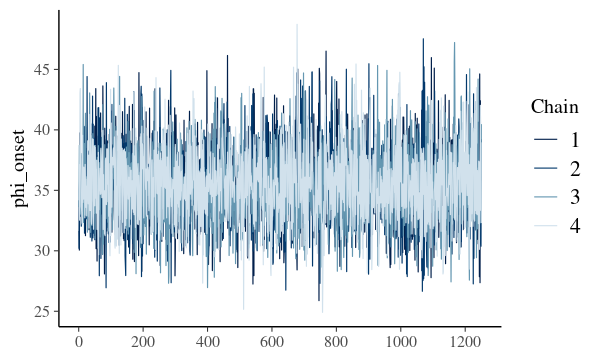

In [53]:
mod_Rt_onset$summary(c("phi_onset"))

options(repr.plot.width=5, repr.plot.height=3)
mcmc_trace(mod_Rt_onset$draws(c("phi_onset")))

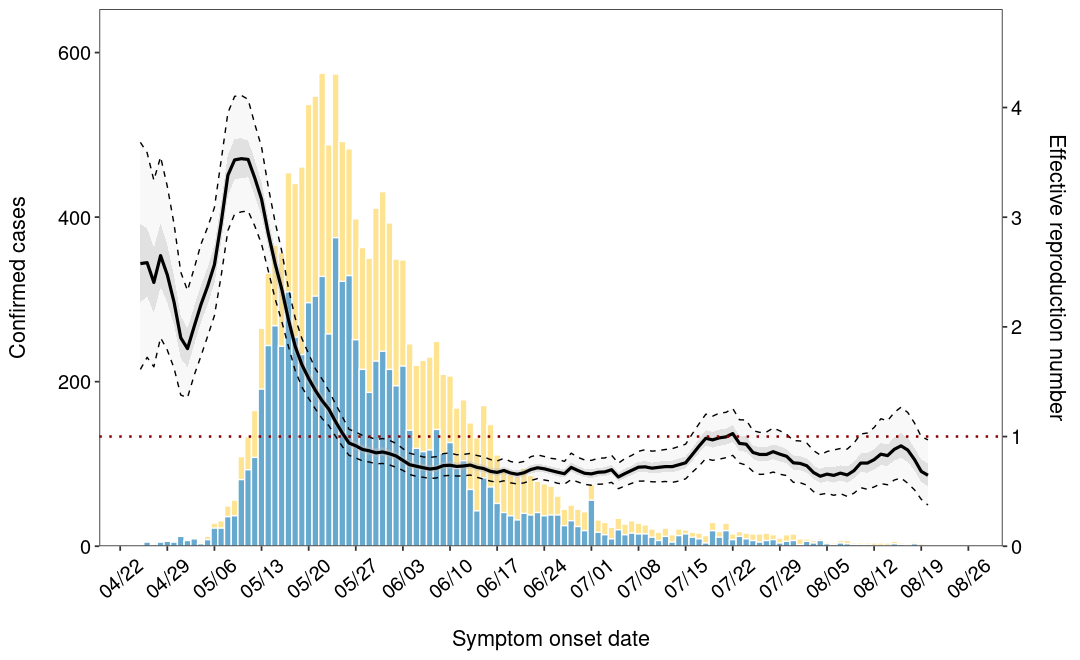

In [54]:
cs = c(9, 5.5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

## Rt by date of onset
output_ = mod_Rt_onset$summary(c("Rt_onset"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
out = stringr::str_match_all(output_$variable, "[\\d+(.*)]")
output_$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
output_ %>% 
    mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), Onset = mindate + index + 1) %>% # + 1 because Rt is shifted to the left by one index
    rename(OnsetDay = index, Rt = `50%`, Rt_lower = `2.5%`, Rt_upper = `97.5%`, Rt_IQR_lower = `25%`, Rt_IQR_upper = `75%`) %>%
    select(Onset, OnsetDay, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) -> output
                       
## backprojected counts
mod_Rt_onset$summary(c("cases_backprj"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_cases_backprj; 
names(df_cases_backprj) = c(names(df_cases_backprj[1]), "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_cases_backprj$variable, "[\\d+(.*)]")
df_cases_backprj$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_cases_backprj %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d = mindate + index) %>% select(-variable, -index) %>%
    left_join(df_cases, by='d')
           
## nowcasted counts
mod_Rt_onset$summary(c("cases_predicted"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame -> df_cases_predicted; 
names(df_cases_predicted) = c("variable", "median", "lower", "upper", "IQR_lower", "IQR_upper")
out = stringr::str_match_all(df_cases_predicted$variable, "[\\d+(.*)]")
df_cases_predicted$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
df_cases_predicted %<>% mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), d = mindate + index) %>% select(-variable, -index) 
                      
Rt_max = 4.8
ymax = 640#max(df_Y$median)
scaling_parameter=Rt_max/ymax
clr_ = c("grey","#67a9cf", "#fee391", "#bcbddc")#"#1380A1", #fec44f
                       
mindate_Rt = as.Date("2021-04-25")
maxdate_Rt = truncation_date - 5
                       
truncation_of_Rt = 1
output %>% 
    ggplot(aes(x=Onset)) +
        geom_bar(data = df_cases_predicted, aes(x=d, y=median), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj, aes(x=d, y=(n+median)), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
        # Rt by onset
        geom_ribbon(data = output %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                   aes(ymax=Rt_IQR_upper/scaling_parameter, ymin=Rt_IQR_lower/scaling_parameter), fill=clr_[1], alpha = 0.4) +
        geom_ribbon(data = output %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                   aes(ymax=Rt_upper/scaling_parameter, ymin=Rt_lower/scaling_parameter), fill=clr_[1], alpha = 0.1) +
        geom_line(data = output %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_upper/scaling_parameter), color="black", linetype="dashed", size=.4, alpha=1) +
        geom_line(data = output %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_lower/scaling_parameter), color="black", linetype="dashed", size=.4, alpha=1) +
        geom_line(data = output %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt/scaling_parameter), color="black", size=.9, alpha=1) +
        geom_hline(yintercept=1/scaling_parameter, linetype="dotted", color = "darkred", size = 0.7) + 
        #labs(x="\n發病日", y="新病例數\n") +
        labs(x="\nSymptom onset date", y="Confirmed cases\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "7 days") +
        scale_y_continuous(expand = expansion(mult = c(0, .02)),
                    #sec.axis = sec_axis(~.*scaling_parameter, name = "有效再生數\n")) +
                    sec.axis = sec_axis(~.*scaling_parameter, name = "Effective reproduction number\n")) +
        coord_cartesian(ylim=c(0,ymax), xlim=c(mindate_Rt, truncation_date)) +
        scale_fill_brewer(palette="Set2") + 
        theme(axis.text.x = element_text(angle=40,vjust=.5),
              text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt
plt
                    
if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/rt_by_onset_window_",(2*window_+1),".",filetype_))
                      
    output %>% select(Onset, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) %>%
        write.csv(file=paste0(results_dir,"/rt_by_onset_window_",(2*window_+1),".csv"),row.names=FALSE)
                      
    df_cases_predicted %>%
        write.csv(file=paste0(results_dir,"/cases_predicted.csv"),row.names=FALSE)
                      
    df_cases_backprj %>%
        write.csv(file=paste0(results_dir,"/cases_backprj.csv"),row.names=FALSE)
}

## Effective reproduction number by date of infection

In [55]:
Rt_window = 7
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_piecewise_constant_window_"%&%Rt_window%&%"_nbinom"
#unlink(standirname, recursive=T)
dir.create(standirname)

fileName = "qfunctions.stan"
qfunctions_txt = readChar(fileName, file.info(fileName)$size)

stan_code_Rt = 'functions {
    '%&%qfunctions_txt%&%'

    /* discretized version of gamma distribution used for generation time */
    vector pgamma(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(gamma_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of lognormal distribution used for the reporting delay */
    vector plognormal(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }
}

data {
    int<lower = 1> K; // truncation date
    int<lower = 1, upper=K> Kmax;
    array[K] int<lower = 0> cases_onset, // number of cases with symptoms onset on given days 1...K
                            cases_unobs; // number of cases with unknown symptoms onset on given days of confirmation 1..K
    int window; //window when Rt is constant

    // infectiousness profile (modeled by shifted gamma distribution)
    real<lower = 0> shift_lambda; 
    int<lower = 0> X; //floor of the shift
    real<lower = 0> param1_lambda, param2_lambda;

    // incubation period (modeled by lognormal distribution)
    real param1_IP, param2_IP; 

    // delay
    array[K] real log_mean_delay_onset_median, log_mean_delay_onset_IQR, log_mean_delay_onset_asymmetry, log_mean_delay_onset_steepness,
                  log_mean_delay_confirm_median, log_mean_delay_confirm_IQR, log_mean_delay_confirm_asymmetry, log_mean_delay_confirm_steepness;
    real log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness,
         log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness;
}

// Likelihood type
// 1: negative binomial 2 (NB2) = overdispersion is constant
// 2: negative binomial 1 (NB1) = overdispersion is proportional to the mean
// 3: negative binomial sqrt (NBsqrt) = overdispersion is proportional to the square root of the mean
// 4: Poisson

transformed data {
    int llk_types = 4;

    // Infectiousness profile (modeled by shifted gamma distribution, He et al NatMed 2020)
    vector[K+X] lambda, lambda_rev;
    {
        vector[K+X] res;
        for (k in 1:K+X)
            res[k] = exp(gamma_lcdf(shift_lambda - X + k | param1_lambda, param2_lambda));
        lambda = append_row(res[1], res[2:K+X]-res[1:K+X-1]);
    }
    lambda_rev = reverse(lambda);

    // Incubation period (modeled by lognormal distribution, Li et al 2020 NEJM)
    vector[K] ht = plognormal(param1_IP, param2_IP, K),
              ht_rev = reverse(ht);

    array[Kmax] int Rt_index;
    for (day in 1:Kmax) 
        Rt_index[day] = (day - 1) %/% window + 1;
    int M = max(Rt_index);
}

parameters {
    vector<lower = 0, upper = 1>[K] p_mean_delay_onset, p_mean_delay_confirm;
    real<lower = 0, upper = 1> p_cv_delay_onset, p_cv_delay_confirm;

    vector<lower = 0>[M] Rt_infection;
    array[3] real<lower = 0> phi;

    simplex[llk_types] weight; // mixing proportions
}

transformed parameters {
    row_vector<lower = 0>[K] mean_delay_onset, mean_delay_confirm;
    real<lower = 0> cv_delay_onset, cv_delay_confirm;
    for (k in 1:K) {
        mean_delay_onset[k] = exp(GLD_icdf(p_mean_delay_onset[k], log_mean_delay_onset_median[k], log_mean_delay_onset_IQR[k], log_mean_delay_onset_asymmetry[k], log_mean_delay_onset_steepness[k]));
        mean_delay_confirm[k] = exp(GLD_icdf(p_mean_delay_confirm[k], log_mean_delay_confirm_median[k], log_mean_delay_confirm_IQR[k], log_mean_delay_confirm_asymmetry[k], log_mean_delay_confirm_steepness[k]));
    }
    cv_delay_onset = exp(GLD_icdf(p_cv_delay_onset, log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness));
    cv_delay_confirm = exp(GLD_icdf(p_cv_delay_confirm, log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness));

    // Lognormal distribution is used for reporting delay as it was selected previously
    real param2_delay_onset = sqrt(log(square(cv_delay_onset) + 1.0)),
         param2_delay_confirm = sqrt(log(square(cv_delay_confirm) + 1.0));
    row_vector[K] param1_delay_onset = log(mean_delay_onset) - square(param2_delay_onset) / 2.0,
                  param1_delay_confirm = log(mean_delay_confirm) - square(param2_delay_confirm) / 2.0;

    vector[llk_types] lps = log(weight);
    for (llk_type in 1:llk_types) {
        vector[K] cases_predicted = to_vector(cases_onset);
        // (1) backprojection of cases with unknown dates of symptom onset 
        //// in this case we use the delay by date of confirmation
        array[K] vector[K] delay_by_confirm;
        for (day in 1:K)
            delay_by_confirm[day] = plognormal(param1_delay_confirm[day], param2_delay_confirm, K);
        //// adding to the case count
        for (day in 1:K-1)
            for (k in (day+1):K)
                cases_predicted[day] += cases_unobs[k] * delay_by_confirm[k, k - day];
        // (2) nowcasting of all cases
        //// in this case we use the delay by date of symptoms onset
        vector[K] cases_nowcasted;
        for (day in 1:K)
            cases_nowcasted[day] = cases_predicted[day] / exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));

        // Rt by date of infection
        vector[K] infections; // infections per day
        vector[K + X] cases_nowcasted_ext = append_row(cases_nowcasted, rep_vector(0, X));
        for (day in 1:Kmax) 
            infections[day] = Rt_infection[Rt_index[day]] * dot_product(head(cases_nowcasted_ext, day + X), tail(lambda_rev, day + X));
        real r_infection, a_infection;
        for (day in 2:Kmax) if (cases_nowcasted[day] > 0) {
            real mu_infection = (day == 2) ? infections[1] * ht_rev[1] : dot_product(head(infections, day-1), tail(ht_rev, day-1));
            if (llk_type==1)
                r_infection = phi[1] / (phi[1] + mu_infection);
            else if (llk_type==2)
                r_infection = phi[2] / (phi[2] + 1.0);
            else if (llk_type==3)
                r_infection = phi[3] / (phi[3] + sqrt(mu_infection));
            else if (llk_type==4)
                r_infection = 1.0;
            a_infection = mu_infection * r_infection;
            lps[llk_type] += gamma_lpdf(cases_nowcasted[day] | a_infection, r_infection);
        }
    }
}

model {
    /* priors */
    Rt_infection ~ normal(5, 5);
    phi ~ cauchy(0, 5);

    target += log_sum_exp(lps);
}

generated quantities {  
    array[K-1] int cases_backprj = rep_array(0, K-1), 
                   cases_nowcasted = rep_array(0, K-1), 
                   cases_predicted; 
    {
        for (day in 2:K) if (cases_unobs[day] > 0) {
            vector[day-1] delay_by_confirm = plognormal(param1_delay_confirm[day], param2_delay_confirm, day-1);
            vector[day-1] probs = reverse(delay_by_confirm) ./ sum(delay_by_confirm);
            array[day-1] int counts = multinomial_rng(probs, cases_unobs[day]);
            for (i in 1:day-1) 
                cases_backprj[i] += counts[i];
        }
        for (day in 1:Kmax) {
            int cases = cases_onset[day] + cases_backprj[day];
            real F = exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));
            cases_nowcasted[day] = (cases > 0) ? neg_binomial_2_rng(cases * (1 - F) / F + 1e-8, cases) : 0;
            cases_predicted[day] = cases + cases_nowcasted[day];
        }
    }

    array[K] int index;
    for (day in 1:K) 
        index[day] = (day - 1) %/% window + 1;

    vector[llk_types] q = exp(lps - log_sum_exp(lps));
    int llk_type_selected = categorical_rng(q);
}'

stan_code_Rt %>% cat(file=standirname %&% "/model_Rt.stan", sep="", fill=TRUE)

stan_file_Rt = write_stan_file(stan_code_Rt)

Warning message in dir.create(standirname):
“'../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_piecewise_constant_window_7_nbinom' already exists”


In [56]:
recalc_Rt = F
foo_Rt = \() {
    ## @data ##
    K = truncation_day
    Kmax = truncation_day - 1
    cases_onset = df_cases$n
    cases_unobs = df_cases$n_unobs
    # infectiousness profile
    shift_lambda = 12.3
    X = 13
    param1_lambda = param1_lambda
    param2_lambda = param2_lambda
    # incubation period
    param1_IP = 1.434065
    param2_IP = 0.6612
    # window when Rt is constant
    window = Rt_window

    rstan::stan_rdump(c("K", "cases_onset", "cases_unobs", "shift_lambda", "X", "param1_lambda", "param2_lambda",
                        "param1_IP", "param2_IP", "window", "Kmax",
                        "log_mean_delay_onset_median", "log_mean_delay_onset_IQR", "log_mean_delay_onset_asymmetry", "log_mean_delay_onset_steepness",
                        "log_cv_delay_onset_median", "log_cv_delay_onset_IQR", "log_cv_delay_onset_asymmetry", "log_cv_delay_onset_steepness", 
                        "log_mean_delay_confirm_median", "log_mean_delay_confirm_IQR", "log_mean_delay_confirm_asymmetry", "log_mean_delay_confirm_steepness",
                        "log_cv_delay_confirm_median", "log_cv_delay_confirm_IQR", "log_cv_delay_confirm_asymmetry", "log_cv_delay_confirm_steepness"), 
                      file=standirname%&%"/Data.R")
    
    Rt_infection = rep(2., (K - 1) %/% window + 1)
    rstan::stan_rdump(c("Rt_infection"), file=standirname%&%"/Init.R")
    
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)
    
    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j6 "%&%stanscriptdir%&%"/model_Rt
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model_Rt \\
            method=sample num_samples=1250 num_warmup=2000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts max_depth=12 \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

if (recalc_Rt) foo_Rt()

In [57]:
output_files = c(); idx = 1
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_Rt_infection = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

variable mean         median       sd           mad          q5          
1 phi[1]   5.223447e+01 9.638780e+00 4.813941e+02 1.277331e+01 5.573937e-01
2 phi[2]   1.822382e+01 4.811710e+00 1.328180e+02 5.116682e+00 4.057121e-01
3 phi[3]   3.563502e+01 7.525115e+00 7.860017e+02 2.625492e+00 1.620821e+00
4 q[1]     2.819731e-01 1.549820e-16 4.342383e-01 2.297763e-16 4.449467e-81
5 q[2]     7.239794e-06 1.522110e-10 1.124853e-04 2.256680e-10 1.621615e-18
6 q[3]     7.180197e-01 1.000000e+00 4.342348e-01 0.000000e+00 2.519876e-14
7 q[4]     7.731947e-12 3.211210e-14 7.071751e-11 4.760933e-14 6.458404e-20
  q95          rhat     ess_bulk  ess_tail 
1 1.362080e+02 1.005700  864.9620 2501.3260
2 5.277710e+01 1.001587 6515.6237 2887.5888
3 1.950174e+01 1.006250 1453.1594  885.7189
4 1.000000e+00 1.005369  657.9767        NA
5 6.847805e-06 1.000624 2227.2069 2201.9104
6 1.000000e+00 1.009105  472.6190        NA
7 2.280984e-11 1.000323 1543.5209 1766.9174

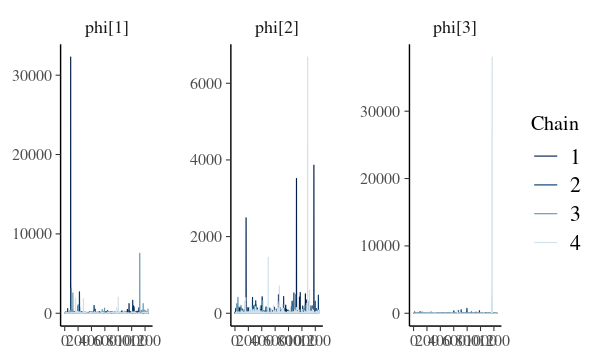

In [58]:
mod_Rt_infection$summary(c("phi", "q"))

options(repr.plot.width=5, repr.plot.height=3)
mcmc_trace(mod_Rt_infection$draws(c("phi")))

Joining, by = "Onset"



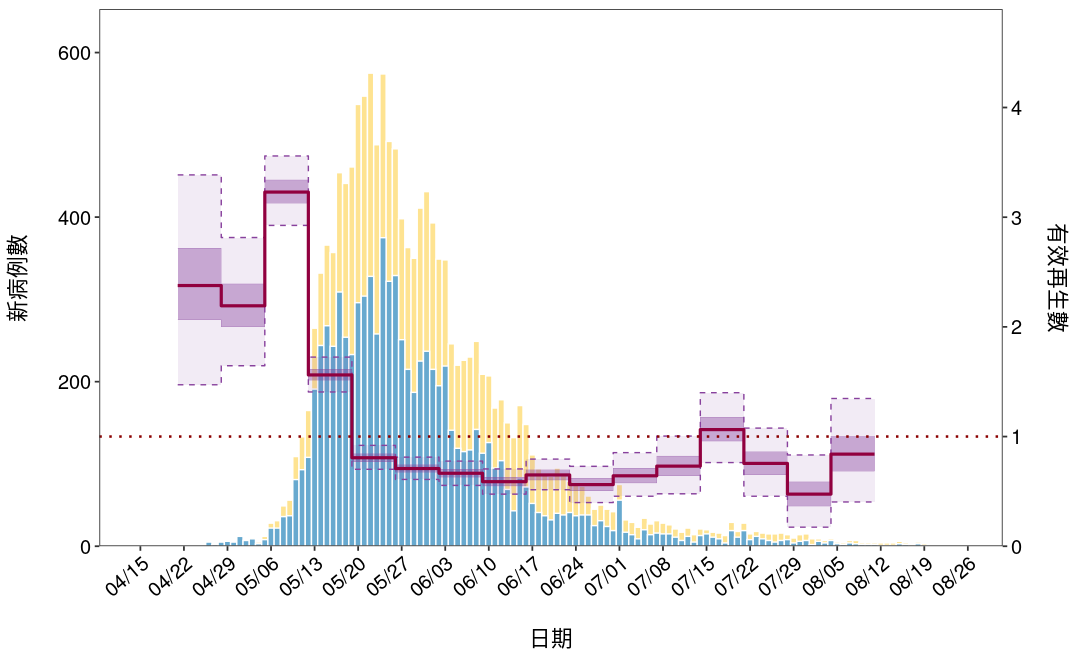

In [59]:
cs = c(9, 5.5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

mindate_Rt = as.Date("2021-04-15")
maxdate_Rt = truncation_date - 5
                       
clr_ = c("#88419d","#67a9cf", "#fee391", "#bcbddc")#"#1380A1", #fec44f

## Rt by date of infection
output_ = mod_Rt_infection$summary(c("Rt_infection"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
out = stringr::str_match_all(output_$variable, "[\\d+(.*)]")
output_$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
output_ %>% 
    mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), Onset = mindate + (index - 1) * Rt_window) %>% # + 1 because Rt is shifted to the left by one index
    rename(Rt = `50%`, Rt_lower = `2.5%`, Rt_upper = `97.5%`, Rt_IQR_lower = `25%`, Rt_IQR_upper = `75%`) %>%
    select(Onset, index, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) -> output_Rt_infection
                       
                       
output_Rt_infection %<>% filter(index <= max(index) - 2, Onset>=mindate_Rt, Onset<=maxdate_Rt)
data.frame(Onset = c(max(output_Rt_infection$Onset) + Rt_window)) |> left_join(output_Rt_infection) |> rbind(output_Rt_infection) |> arrange(Onset) |>
    mutate(across(starts_with("Rt"), ~zoo::na.locf(zoo::na.locf(.), fromLast=T))) -> output_Rt_infection_

output %>% 
    ggplot(aes(x=Onset)) +
        geom_bar(data = df_cases_predicted, aes(x=d, y=median), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj, aes(x=d, y=(n+median)), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_infection_,
                   aes(ymax=Rt_IQR_upper/scaling_parameter, ymin=Rt_IQR_lower/scaling_parameter), fill=clr_[1], alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_infection_, 
                   aes(ymax=Rt_upper/scaling_parameter, ymin=Rt_lower/scaling_parameter), fill=clr_[1], alpha = 0.1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_upper/scaling_parameter), color=clr_[1], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_lower/scaling_parameter), color=clr_[1], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_infection %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_upper/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_IQR_lower/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt/scaling_parameter), color="#91003f", size=.9, alpha=1) +
#         geom_step(data = output %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
#                   aes(y=Rt/scaling_parameter), color="black", linetype="dashed", size=.6, alpha=1) +
        geom_hline(yintercept=1/scaling_parameter, linetype="dotted", color = "darkred", size = 0.7) + 
        labs(x="\n日期", y="新病例數\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "7 days") +
        scale_y_continuous(expand = expansion(mult = c(0, .02)),
                    sec.axis = sec_axis(~.*scaling_parameter, name = "有效再生數\n")) +
        coord_cartesian(ylim=c(0,ymax), xlim=c(mindate_Rt, truncation_date)) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
              axis.text.x = element_text(angle = 40, vjust = 1, hjust=1),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt
plt
                    
if (generateFigures) { for (filetype_ in c("png"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/rt_by_infection_window_7_Taiwan.",filetype_))
                      
    output_Rt_infection %>% 
        select(Onset, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) %>% 
        filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) %>%
        mutate(across(where(is.numeric), ~round(.,3))) %>%
        write.csv(file=paste0(results_dir,"/rt_by_infection_window_7_Taiwan.csv"),row.names=FALSE)
}

In [60]:
df_mobility = read.csv("../../data/df_pca_mobility_"%&%format(truncation_date,"%Y%m%d")%&%".csv") |> mutate(d = as.Date(d))
df_mobility |> head()

t x1    x2    x3    x4    x5    x6    y1           y2          y3          
1 0 -0.05  0.01 -0.15  0.02  0.00 -0.05 -0.004716654 -0.07001106 -0.020525756
2 1  0.07  0.11  0.34 -0.07 -0.53  0.10  0.008222763  0.45198074  0.004038755
3 2 -0.08  0.03  0.15 -0.12 -0.16  0.01 -0.005189261  0.16278136 -0.090764882
4 3 -0.10 -0.02  0.21 -0.10 -0.20  0.00  0.003547042  0.19786423 -0.046554528
5 4  0.07  0.08  0.34 -0.09 -0.59  0.11  0.008318426  0.48495411  0.051156178
6 5 -0.15  0.01 -0.15 -0.08  0.01  0.00 -0.023192044 -0.05723592 -0.043187732
  y4          y5           y6           d         
1  0.17536793 -0.111283222  0.529028112 2021-04-01
2  0.15971442 -0.009588116  0.507929729 2021-04-02
3 -0.14401622 -0.104800333  0.000730528 2021-04-03
4 -0.21322289 -0.218263699 -0.178174620 2021-04-04
5  0.17331983  0.026935893 -0.167440154 2021-04-05
6  0.02359482 -0.197922523  0.011290819 2021-04-06

In [61]:
output_Rt_infection |> rename(d = Onset) |> select(d, index) |> full_join(df_mobility) |> arrange(d) |> fill(index, .direction = "down") |> rename(y = y1) -> df_
df_ |> group_by(index) |> summarize(y_min = min(y), y_max = max(y), y=mean(y), d = min(d)) |> select(-index) |> drop_na() -> df_
df_ |> right_join(output_Rt_infection |> rename(d = Onset)) |> drop_na() |> filter(d>=as.Date('2021-04-21')) -> df_
df_

Joining, by = "d"

Joining, by = "d"



y_min       y_max        y           d          index Rt        Rt_lower 
1  -0.02915283 -0.010378782 -0.01955895 2021-04-21  4    2.3761950 1.4719340
2  -0.03370064  0.003447560 -0.01722272 2021-04-28  5    2.1918900 1.6452270
3  -0.03291488 -0.009828096 -0.02483587 2021-05-05  6    3.2281900 2.9246182
4  -0.08950566 -0.039873668 -0.06763467 2021-05-12  7    1.5612750 1.4063090
5  -0.12429627 -0.096739966 -0.10859318 2021-05-19  8    0.8068205 0.7012549
6  -0.13068884 -0.103188712 -0.11413503 2021-05-26  9    0.7080295 0.6088540
7  -0.13416039 -0.103855870 -0.11518921 2021-06-02 10    0.6651595 0.5543916
8  -0.12121315 -0.103096217 -0.11009722 2021-06-09 11    0.5883645 0.4747863
9  -0.11904293 -0.099896060 -0.10883412 2021-06-16 12    0.6497660 0.5149200
10 -0.11540008 -0.102639089 -0.10718388 2021-06-23 13    0.5616645 0.3979862
11 -0.11092762 -0.096432662 -0.10095543 2021-06-30 14    0.6419380 0.4557757
12 -0.10794599 -0.093028463 -0.09771236 2021-07-07 15    0.7302985 0.4779618
13 -0.10077154 -0.089398789 -0.09204468 2021-07-14 16    1.0633350 0.7627188
14 -0.11515198 -0.080855563 -0.09711000 2021-07-21 17    0.7549980 0.4555444
15 -0.10318514 -0.080807985 -0.08732948 2021-07-28 18    0.4750880 0.1738617
16 -0.11744824 -0.063916823 -0.07681657 2021-08-04 19    0.8391705 0.4035237
   Rt_upper  Rt_IQR_lower Rt_IQR_upper
1  3.3849687 2.0643075    2.7160500   
2  2.8139610 2.0003825    2.3909250   
3  3.5576305 3.1259275    3.3387650   
4  1.7241125 1.5125725    1.6139175   
5  0.9194507 0.7706795    0.8431077   
6  0.8121754 0.6746860    0.7439982   
7  0.7758050 0.6297573    0.7013907   
8  0.7044723 0.5491873    0.6289005   
9  0.7940989 0.6033395    0.6988598   
10 0.7282332 0.5051663    0.6185570   
11 0.8531973 0.5766562    0.7112622   
12 1.0041790 0.6422540    0.8216855   
13 1.3993825 0.9585763    1.1741400   
14 1.0768117 0.6527392    0.8624555   
15 0.8317507 0.3656658    0.5867620   
16 1.3464957 0.6816092    1.0045175

Warning message:
“Ignoring unknown aesthetics: ymin, ymax”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


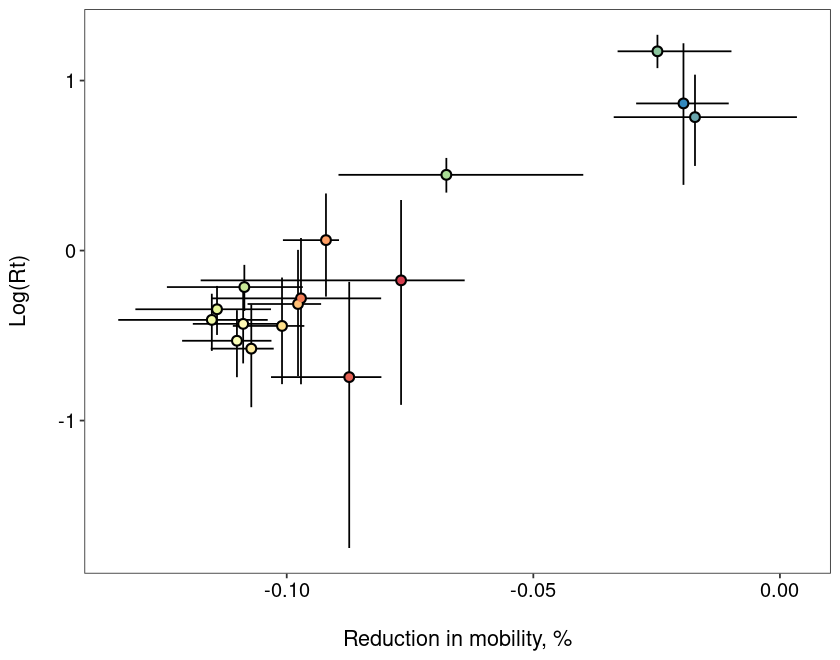

In [62]:
cs = c(7, 5.5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

df_ %>% 
    ggplot(aes(x=y, y=log(Rt))) +
    geom_pointrange(aes(ymin = log(Rt_lower), ymax = log(Rt_upper))) +
    geom_errorbarh(aes(xmin=y_min, xmax=y_max, height=0)) +
    geom_point(aes(ymin = log(Rt_lower), ymax = log(Rt_upper), color=d)) +
    labs(x="\nReduction in mobility, %", y="Log(Rt)\n") +
#     coord_cartesian(ylim=c(0,4), xlim=c(-60, 0), expand=0) +
#     geom_point(aes(color=index),size=2) +
    guides(color=F) +
    scale_color_distiller(palette='Spectral',direction=-1) +
    theme_bw() +
    theme(text = element_text(size=13, family="sans", color="black"),
        axis.text = element_text(size=12, family="sans", color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/scatterplot_rt_infection_mobility_log.",filetype_))

Warning message:
“Ignoring unknown aesthetics: ymin, ymax”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


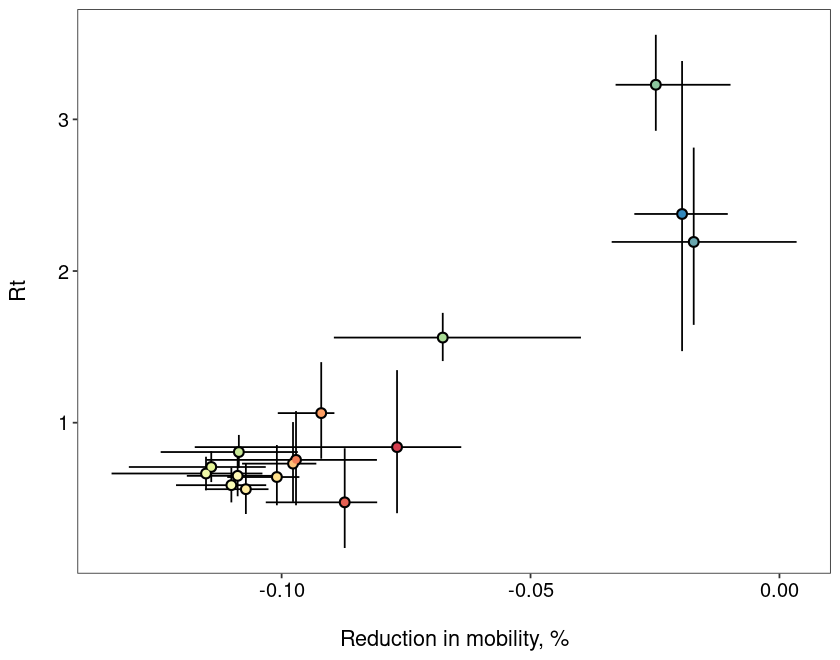

In [63]:
cs = c(7, 5.5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

df_ %>% 
    ggplot(aes(x=y, y=(Rt))) +
    geom_pointrange(aes(ymin = (Rt_lower), ymax = (Rt_upper))) +
    geom_errorbarh(aes(xmin=y_min, xmax=y_max, height=0)) +
    geom_point(aes(ymin = (Rt_lower), ymax = (Rt_upper), color=d)) +
    labs(x="\nReduction in mobility, %", y="Rt\n") +
#     coord_cartesian(ylim=c(0,4), xlim=c(-60, 0), expand=0) +
#     geom_point(aes(color=index),size=2) +
    guides(color=F) +
    scale_color_distiller(palette='Spectral',direction=-1) +
    theme_bw() +
    theme(text = element_text(size=13, family="sans", color="black"),
        axis.text = element_text(size=12, family="sans", color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/scatterplot_rt_infection_mobility.",filetype_))

## Reproduction number linked to mobility

In [64]:
df_pca = read.csv("../../data/df_pca_mobility_"%&%format(truncation_date,"%Y%m%d")%&%".csv") |> select(-t) |> mutate(d = as.Date(d))
df_pca |> head()

x1    x2    x3    x4    x5    x6    y1           y2          y3          
1 -0.05  0.01 -0.15  0.02  0.00 -0.05 -0.004716654 -0.07001106 -0.020525756
2  0.07  0.11  0.34 -0.07 -0.53  0.10  0.008222763  0.45198074  0.004038755
3 -0.08  0.03  0.15 -0.12 -0.16  0.01 -0.005189261  0.16278136 -0.090764882
4 -0.10 -0.02  0.21 -0.10 -0.20  0.00  0.003547042  0.19786423 -0.046554528
5  0.07  0.08  0.34 -0.09 -0.59  0.11  0.008318426  0.48495411  0.051156178
6 -0.15  0.01 -0.15 -0.08  0.01  0.00 -0.023192044 -0.05723592 -0.043187732
  y4          y5           y6           d         
1  0.17536793 -0.111283222  0.529028112 2021-04-01
2  0.15971442 -0.009588116  0.507929729 2021-04-02
3 -0.14401622 -0.104800333  0.000730528 2021-04-03
4 -0.21322289 -0.218263699 -0.178174620 2021-04-04
5  0.17331983  0.026935893 -0.167440154 2021-04-05
6  0.02359482 -0.197922523  0.011290819 2021-04-06

In [65]:
df_cases_pca = df_cases |> left_join(df_pca, by='d')  |> drop_na()
df_cases_pca |> tail()

t   n_unobs n d          x1    x2   x3    x4    x5    x6   y1         
142 142 0       1 2021-08-20 -0.24 0.11 -0.26 -0.32 -0.12 0.09 -0.06663999
143 143 5       1 2021-08-21 -0.25 0.14 -0.29 -0.40 -0.06 0.08 -0.07673757
144 144 2       1 2021-08-22 -0.25 0.14 -0.29 -0.40 -0.06 0.08 -0.07673757
145 145 0       0 2021-08-23 -0.25 0.14 -0.29 -0.40 -0.06 0.08 -0.07673757
146 146 0       0 2021-08-24 -0.25 0.14 -0.29 -0.40 -0.06 0.08 -0.07673757
147 147 0       1 2021-08-25 -0.25 0.14 -0.29 -0.40 -0.06 0.08 -0.07673757
    y2           y3         y4         y5           y6         
142  0.021565388 -0.1349333 0.10342719 -0.001734122  0.04729426
143 -0.009489801 -0.2214187 0.04007664  0.153260819 -0.01827756
144 -0.009489801 -0.2214187 0.04007664  0.153260819 -0.01827756
145 -0.009489801 -0.2214187 0.04007664  0.153260819 -0.01827756
146 -0.009489801 -0.2214187 0.04007664  0.153260819 -0.01827756
147 -0.009489801 -0.2214187 0.04007664  0.153260819 -0.01827756

# Change in Rt linked to interventions

In [66]:
data.frame(date = c('2021-05-11', '2021-05-15', '2021-05-19', '2021-05-29'),
           description = c("Level 2", "Level 3 (Taipei and New Taipei)", "Level 3 (nationwide)", "Level 3 (strengthening)")
) -> df_events
df_events %<>% mutate(date = as.Date(date), day = as.numeric(date - df$Report[1]) + df$ReportDay[1])

df_events %>% write.csv(file=paste0(results_dir,"/events.csv"),row.names=FALSE)

df_events

date       description                     day
1 2021-05-11 Level 2                         41 
2 2021-05-15 Level 3 (Taipei and New Taipei) 45 
3 2021-05-19 Level 3 (nationwide)            49 
4 2021-05-29 Level 3 (strengthening)         59

In [67]:
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_calculation_events"
#unlink(standirname, recursive=T)
dir.create(standirname)

stan_code_Rt = 'functions {
    '%&%qfunctions_txt%&%'

    /* discretized version of gamma distribution used for generation time */
    vector pgamma(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(gamma_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of lognormal distribution used for the reporting delay */
    vector plognormal(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }
}

data {
    int<lower = 1> K; // truncation date
    array[K] int<lower = 0> cases_onset, // number of cases with symptoms onset on given days 1...K
                            cases_unobs; // number of cases with unknown symptoms onset on given days of confirmation 1..K
    int<lower = 1> M; // number of interventions
    array[M] int<lower = 1> event_day; // days of the interventions 

    int Kmin, Kmax; // time frame for inference of Rt

    // serial interval (modeled by gamma distribution)
    real<lower = 0> mu_SI, sigma_SI; 

    // infectiousness profile (modeled by shifted gamma distribution)
    real<lower = 0> shift_lambda; 
    int<lower = 0> X; //floor of the shift
    real<lower = 0> param1_lambda, param2_lambda;

    // incubation period (modeled by lognormal distribution)
    real param1_IP, param2_IP; 

    // delay
    array[K] real log_mean_delay_onset_median, log_mean_delay_onset_IQR, log_mean_delay_onset_asymmetry, log_mean_delay_onset_steepness,
                  log_mean_delay_confirm_median, log_mean_delay_confirm_IQR, log_mean_delay_confirm_asymmetry, log_mean_delay_confirm_steepness;
    real log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness,
         log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness;
}

transformed data {
    // Serial interval (modeled by gamma distribution)
    real<lower = 0> param1_SI = square(mu_SI / sigma_SI), param2_SI = mu_SI / square(sigma_SI);
    vector[K] gt = pgamma(param1_SI, param2_SI, K),
              gt_rev = reverse(gt);    

    // Infectiousness profile (modeled by shifted gamma distribution, He et al NatMed 2020)
    vector[K+X] lambda, lambda_rev;
    {
        vector[K+X] res;
        for (k in 1:K+X)
            res[k] = exp(gamma_lcdf(shift_lambda - X + k | param1_lambda, param2_lambda));
        lambda = append_row(res[1], res[2:K+X]-res[1:K+X-1]);
    }
    lambda_rev = reverse(lambda);

    // Incubation period 
    vector[K] ht = plognormal(param1_IP, param2_IP, K),
              ht_rev = reverse(ht);

    // intervention indexes
    array[K] int Rt_index = rep_array(1, K);
    for (m in 1:M)
        for (day in 1:K) 
            Rt_index[day] += (day >= event_day[m]) ? 1 : 0;

    int n_llk_types = 4;
    // Likelihood types
    // 1: negative binomial 2 (NB2) = overdispersion is constant
    // 2: negative binomial 1 (NB1) = overdispersion is proportional to the mean
    // 3: negative binomial sqrt (NBsqrt) = overdispersion is proportional to the square root of the mean
    // 4: Poisson
}

parameters {
    vector<lower = 0, upper = 1>[K] p_mean_delay_onset, p_mean_delay_confirm;
    real<lower = 0, upper = 1> p_cv_delay_onset, p_cv_delay_confirm;

    vector<lower = 0>[M+1] Rt;
    vector<lower = 0>[3] phi;

    simplex[n_llk_types] weight; // mixing proportions
}

transformed parameters {
    row_vector<lower = 0>[K] mean_delay_onset, mean_delay_confirm;
    real<lower = 0> cv_delay_onset, cv_delay_confirm;
    for (k in 1:K) {
        mean_delay_onset[k] = exp(GLD_icdf(p_mean_delay_onset[k], log_mean_delay_onset_median[k], log_mean_delay_onset_IQR[k], log_mean_delay_onset_asymmetry[k], log_mean_delay_onset_steepness[k]));
        mean_delay_confirm[k] = exp(GLD_icdf(p_mean_delay_confirm[k], log_mean_delay_confirm_median[k], log_mean_delay_confirm_IQR[k], log_mean_delay_confirm_asymmetry[k], log_mean_delay_confirm_steepness[k]));
    }
    cv_delay_onset = exp(GLD_icdf(p_cv_delay_onset, log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness));
    cv_delay_confirm = exp(GLD_icdf(p_cv_delay_confirm, log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness));

    // Lognormal distribution is used for reporting delay as it was selected previously
    real param2_delay_onset = sqrt(log(square(cv_delay_onset) + 1.0)),
         param2_delay_confirm = sqrt(log(square(cv_delay_confirm) + 1.0));
    row_vector[K] param1_delay_onset = log(mean_delay_onset) - square(param2_delay_onset) / 2.0,
                  param1_delay_confirm = log(mean_delay_confirm) - square(param2_delay_confirm) / 2.0;

    vector[n_llk_types] lps = log(weight);
    {
        vector[K] cases_predicted = to_vector(cases_onset);
        // (1) backprojection of cases with unknown dates of symptom onset 
        //// in this case we use the delay by date of confirmation
        array[K] vector[K] delay_by_confirm;
        for (day in 1:K)
            delay_by_confirm[day] = plognormal(param1_delay_confirm[day], param2_delay_confirm, K);
        //// adding to the case count
        for (day in 1:K-1)
            for (k in (day+1):K)
                cases_predicted[day] += cases_unobs[k] * delay_by_confirm[k, k - day];
        // (2) nowcasting of all cases
        //// in this case we use the delay by date of symptoms onset
        vector[K] cases_nowcasted;
        for (day in 1:K)
            cases_nowcasted[day] = cases_predicted[day] / exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));

        // Rt
        vector[K] infections; // infections per day
        vector[K + X] cases_nowcasted_ext = append_row(cases_nowcasted, rep_vector(0, X));
        for (day in 1:K) 
            infections[day] = Rt[Rt_index[day]] * dot_product(head(cases_nowcasted_ext, day + X), tail(lambda_rev, day + X));

        real r_infection, a_infection;
        for (day in Kmin:Kmax) if (cases_nowcasted_ext[day] > 0) {
            real mu_infection = (day == 2) ? infections[1] * ht_rev[1] : dot_product(head(infections, day-1), tail(ht_rev, day-1));
            for (llk_type in 1:n_llk_types) {
                if (llk_type==1)
                    r_infection = phi[1] / (phi[1] + mu_infection);
                else if (llk_type==2)
                    r_infection = phi[2] / (phi[2] + 1.0);
                else if (llk_type==3)
                    r_infection = phi[3] / (phi[3] + sqrt(mu_infection));
                else if (llk_type==4)
                    r_infection = 1.0;
                a_infection = mu_infection * r_infection;
                lps[llk_type] += gamma_lpdf(cases_nowcasted_ext[day] | a_infection, r_infection);
            }
        }
    }
}

model {
    /* priors */
    Rt ~ normal(5, 5);
    phi ~ cauchy(0, 5);

    target += log_sum_exp(lps);
}

generated quantities {  
    array[K-1] int cases_backprj = rep_array(0, K-1), 
                   cases_nowcasted = rep_array(0, K-1), 
                   cases_predicted; 
    {
        for (day in 2:K) if (cases_unobs[day] > 0) {
            vector[day-1] delay_by_confirm = plognormal(param1_delay_confirm[day], param2_delay_confirm, day-1);
            vector[day-1] probs = reverse(delay_by_confirm) ./ sum(delay_by_confirm);
            array[day-1] int counts = multinomial_rng(probs, cases_unobs[day]);
            for (i in 1:day-1) 
                cases_backprj[i] += counts[i];
        }
        for (day in 1:K-1) {
            int cases = cases_onset[day] + cases_backprj[day];
            real F = exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));
            cases_nowcasted[day] = (cases > 0) ? neg_binomial_2_rng(cases * (1 - F) / F + 1e-8, cases) : 0;
            cases_predicted[day] = cases + cases_nowcasted[day];
        }
    }

    vector<lower = 0, upper = 1>[n_llk_types] q = exp(lps - log_sum_exp(lps));
    int<lower = 1> index_llk_type = categorical_rng(q);
}'

stan_code_Rt %>% cat(file=standirname %&% "/model_Rt.stan", sep="", fill=TRUE)

stan_file_Rt = write_stan_file(stan_code_Rt)

Warning message in dir.create(standirname):
“'../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_calculation_events' already exists”


In [68]:
recalc_Rt = F
foo_Rt = \() {
    ## @data ##
    K = truncation_day
    cases_onset = df_cases$n
    cases_unobs = df_cases$n_unobs
    # interventions
    M = nrow(df_events)
    event_day = df_events$day
    Kmin = min(event_day) - 14
    Kmax = max(event_day) + 14
    # serial interval
    mu_SI = 4.43 
    sigma_SI = 3.30
    # infectiousness profile
    shift_lambda = 12.3
    X = 13
    param1_lambda = param1_lambda
    param2_lambda = param2_lambda
    # incubation period
    param1_IP = 1.434065
    param2_IP = 0.6612

    rstan::stan_rdump(c("K", "cases_onset", "cases_unobs", "mu_SI", "sigma_SI", "shift_lambda", "X", "param1_lambda", "param2_lambda",
                        "param1_IP", "param2_IP", "M", "event_day", "Kmin", "Kmax",
                        "log_mean_delay_onset_median", "log_mean_delay_onset_IQR", "log_mean_delay_onset_asymmetry", "log_mean_delay_onset_steepness",
                        "log_cv_delay_onset_median", "log_cv_delay_onset_IQR", "log_cv_delay_onset_asymmetry", "log_cv_delay_onset_steepness", 
                        "log_mean_delay_confirm_median", "log_mean_delay_confirm_IQR", "log_mean_delay_confirm_asymmetry", "log_mean_delay_confirm_steepness",
                        "log_cv_delay_confirm_median", "log_cv_delay_confirm_IQR", "log_cv_delay_confirm_asymmetry", "log_cv_delay_confirm_steepness"), 
                      file=standirname%&%"/Data.R")
    
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)
    
    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j6 "%&%stanscriptdir%&%"/model_Rt
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model_Rt \\
            method=sample num_samples=1250 num_warmup=2000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

if (recalc_Rt) foo_Rt()

In [69]:
output_files = c(); idx = 1
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_Rt = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

variable mean         median       sd           mad          q5          
1  Rt[1]    2.860363e+00 2.851515e+00 1.897743e-01 1.856438e-01 2.555501e+00
2  Rt[2]    2.407907e+00 2.401400e+00 2.225773e-01 2.173195e-01 2.058420e+00
3  Rt[3]    1.590770e+00 1.590945e+00 1.524048e-01 1.493423e-01 1.343403e+00
4  Rt[4]    8.569512e-01 8.564230e-01 4.845903e-02 4.634385e-02 7.775974e-01
5  Rt[5]    6.527498e-01 6.516690e-01 4.151909e-02 4.059359e-02 5.864700e-01
6  phi[1]   2.599947e+01 5.188945e+00 2.601311e+02 5.841963e+00 4.176702e-01
7  phi[2]   4.952914e+01 4.560680e+00 1.129025e+03 5.410692e+00 2.636380e-01
8  phi[3]   5.439851e+00 4.177330e+00 1.063968e+01 1.395134e+00 2.315491e+00
9  q[1]     2.810726e-02 2.771505e-13 1.439114e-01 4.109033e-13 3.403562e-39
10 q[2]     7.445520e-02 1.282335e-14 2.452874e-01 1.901190e-14 4.162068e-24
11 q[3]     8.974375e-01 1.000000e+00 2.790280e-01 0.000000e+00 1.620639e-03
12 q[4]     2.027568e-17 1.165870e-20 2.075049e-16 1.728519e-20 3.493793e-29
   q95          rhat     ess_bulk  ess_tail 
1  3.180559e+00 1.000760 3903.5149 2078.7896
2  2.785426e+00 1.000936 4961.6900 3812.8371
3  1.842763e+00 1.002046 5163.7219 3819.4952
4  9.369714e-01 1.001199 6465.7385 3354.7285
5  7.234729e-01 1.001192 7936.2549 3606.7303
6  6.992735e+01 1.001083 5530.9720 2966.9289
7  5.824058e+01 1.002049 2546.3799 2258.7072
8  8.236784e+00 1.004432 1419.3304  529.0430
9  7.535169e-02 1.000067 3868.2101 1558.2789
10 9.614966e-01 1.004613 1449.2361  546.0244
11 1.000000e+00 1.007514  842.2805        NA
12 4.879042e-17 1.001307 2582.2297 2984.0345

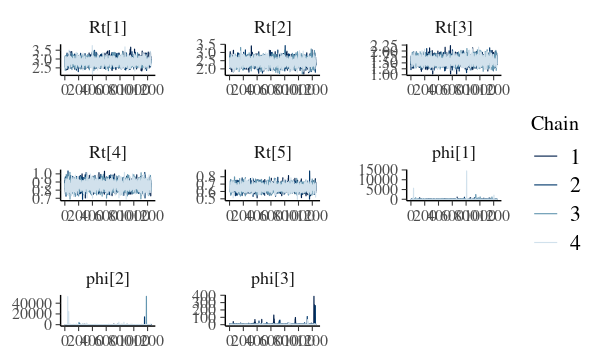

In [70]:
mod_Rt$summary(c("Rt", "phi", "q"))

options(repr.plot.width=5, repr.plot.height=3)
mcmc_trace(mod_Rt$draws(c("Rt", "phi")))

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”
Warning message:
“Ignoring unknown parameters: gradient_lwd”
Picking joint bandwidth of 0.0211

Picking joint bandwidth of 0.0211

Picking joint bandwidth of 0.0211



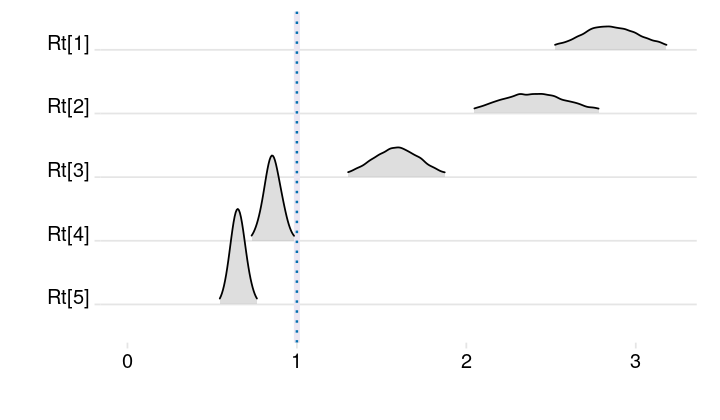

In [71]:
library(ggridges)
library(RColorBrewer)
cs = c(6, 3.5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])
as_draws_df(mod_Rt$draws(c("Rt"))) |> select(-contains('.')) |> gather(variable, value) -> df_Rt_long
df_Rt_long |> mutate(variable = as.factor(variable), variable=forcats::fct_rev(variable)) |>
    ggplot() +
    geom_vline(xintercept=1, linetype="solid", color = "#ece7f2", size = 1.7) + 
    geom_vline(xintercept=1, linetype="dotted", color = "#0570b0", size = 0.7) + 
    geom_density_ridges(aes(y = variable, x = value), fill='#bdbdbd',
                                 scale = 1.5, rel_min_height = 0.05, alpha=.5, gradient_lwd = 1., from = 0, to = 3.2) +
#     scale_fill_gradientn(colours=brewer.pal(9,"Spectral") |> rev(), name = "Rt") +
    coord_cartesian(xlim=c(0,3.2)) +
    labs(x="",y="") +
    theme_ridges(center_axis_labels = TRUE) +
    theme(text = element_text(size=12, family="sans", color="black"),
            axis.text.x = element_text(size=12, family="sans", color="black"),
            panel.grid.major.x = element_blank(), panel.grid.minor = element_blank()) -> plt

plt
if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/rt_by_infection_events_ridges.",filetype_))
}

In [72]:
## Rt
output_ = mod_Rt$summary(c("Rt"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
out = stringr::str_match_all(output_$variable, "[\\d+(.*)]")
output_$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
output_ %>% 
    mutate(variable = stringr::str_extract(variable, "^[^\\[]+")) %>% 
    rename(Event = index, Rt = `50%`, Rt_lower = `2.5%`, Rt_upper = `97.5%`, Rt_IQR_lower = `25%`, Rt_IQR_upper = `75%`) %>%
    select(Event, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) -> output
output |> write.csv(file=paste0(results_dir,"/rt_by_infection_events.csv"),row.names=FALSE)
output |> round(2)

Event Rt   Rt_lower Rt_upper Rt_IQR_lower Rt_IQR_upper
1 1     2.85 2.51     3.26     2.73         2.98        
2 2     2.40 1.99     2.86     2.26         2.55        
3 3     1.59 1.30     1.90     1.49         1.69        
4 4     0.86 0.76     0.95     0.83         0.89        
5 5     0.65 0.57     0.74     0.62         0.68

# Stan program with mobility

In [73]:
stan_code_Rt = 'functions {
    '%&%qfunctions_txt%&%'

    /* discretized version of gamma distribution used for generation time */
    vector pgamma(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(gamma_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of lognormal distribution used for the reporting delay */
    vector plognormal(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }
}

// Likelihood type
// 1: negative binomial 2 (NB2) = overdispersion is constant
// 2: negative binomial 1 (NB1) = overdispersion is proportional to the mean
// 3: negative binomial sqrt (NBsqrt) = overdispersion is proportional to the square root of the mean
// 4: Poisson

data {
    int<lower = 1> K; // truncation date
    array[K] int<lower = 0> cases_onset, // number of cases with symptoms onset on given days 1...K
                            cases_unobs; // number of cases with unknown symptoms onset on given days of confirmation 1..K

    int Kmin, Kmax; // time frame for inference of Rt

    // infectiousness profile (modeled by shifted gamma distribution)
    real<lower = 0> shift_lambda; 
    int<lower = 0> X; //floor of the shift
    real<lower = 0> param1_lambda, param2_lambda;

    // incubation period (modeled by lognormal distribution)
    real param1_IP, param2_IP; 

    // delay
    array[K] real log_mean_delay_onset_median, log_mean_delay_onset_IQR, log_mean_delay_onset_asymmetry, log_mean_delay_onset_steepness,
                  log_mean_delay_confirm_median, log_mean_delay_confirm_IQR, log_mean_delay_confirm_asymmetry, log_mean_delay_confirm_steepness;
    real log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness,
         log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness;

    int<lower = 1> M; // total number of mobility metrics or their principal components
    matrix[K, M] y; // mobility

    int<lower = 1> C; // total number of combinations of mobility metrics
    int<lower = 1> N; // number of used mobility metrics
    array[C, N] int mobility_indexes; // particular sets of mobility metrics
}

transformed data {
    // Infectiousness profile (modeled by shifted gamma distribution, He et al NatMed 2020)
    vector[K+X] lambda, lambda_rev;
    {
        vector[K+X] res;
        for (k in 1:K+X)
            res[k] = exp(gamma_lcdf(shift_lambda - X + k | param1_lambda, param2_lambda));
        lambda = append_row(res[1], res[2:K+X]-res[1:K+X-1]);
    }
    lambda_rev = reverse(lambda);

    // Incubation period (modeled by lognormal distribution, Linton et al JCM 2020)
    vector[K] ht = plognormal(param1_IP, param2_IP, K),
              ht_rev = reverse(ht);

    int<lower = 1> n_llk_types = 4;
    int<lower = 1> Pi = n_llk_types * C;
}

parameters {
    vector<lower = 0, upper = 1>[K] p_mean_delay_onset, p_mean_delay_confirm;
    real<lower = 0, upper = 1> p_cv_delay_onset, p_cv_delay_confirm;

    real<lower = 0> R0;
    vector[M] beta;
    array[3] real<lower = 0> phi;

    simplex[Pi] weight; // mixing proportions
}

transformed parameters {
    row_vector<lower = 0>[K] mean_delay_onset, mean_delay_confirm;
    real<lower = 0> cv_delay_onset, cv_delay_confirm;
    for (k in 1:K) {
        mean_delay_onset[k] = exp(GLD_icdf(p_mean_delay_onset[k], log_mean_delay_onset_median[k], log_mean_delay_onset_IQR[k], log_mean_delay_onset_asymmetry[k], log_mean_delay_onset_steepness[k]));
        mean_delay_confirm[k] = exp(GLD_icdf(p_mean_delay_confirm[k], log_mean_delay_confirm_median[k], log_mean_delay_confirm_IQR[k], log_mean_delay_confirm_asymmetry[k], log_mean_delay_confirm_steepness[k]));
    }
    cv_delay_onset = exp(GLD_icdf(p_cv_delay_onset, log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness));
    cv_delay_confirm = exp(GLD_icdf(p_cv_delay_confirm, log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness));

    // Lognormal distribution is used for reporting delay as it was selected previously
    real param2_delay_onset = sqrt(log(square(cv_delay_onset) + 1.0)),
         param2_delay_confirm = sqrt(log(square(cv_delay_confirm) + 1.0));
    row_vector[K] param1_delay_onset = log(mean_delay_onset) - square(param2_delay_onset) / 2.0,
                  param1_delay_confirm = log(mean_delay_confirm) - square(param2_delay_confirm) / 2.0;

    vector[K + X] cases_predicted_ext;
    vector[Pi] lps = log(weight);
    {
        vector[K] cases_backproj = to_vector(cases_onset);
        // (1) backprojection of cases with unknown dates of symptom onset 
        //// in this case we use the delay by date of confirmation
        array[K] vector[K] delay_by_confirm;
        for (day in 1:K)
            delay_by_confirm[day] = plognormal(param1_delay_confirm[day], param2_delay_confirm, K);
        //// adding to the case count
        for (day in 1:K-1)
            for (k in (day+1):K)
                cases_backproj[day] += cases_unobs[k] * delay_by_confirm[k, k - day];
        // (2) nowcasting of all cases
        //// in this case we use the delay by date of symptoms onset
        vector[K] cases_predicted;
        for (day in 1:K)
            cases_predicted[day] = cases_backproj[day] / exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));

        cases_predicted_ext = append_row(cases_predicted, rep_vector(0, X));

        int c, llk_type;
        for (idx in 1:Pi) {
            llk_type = (idx - 1) % n_llk_types + 1;
            c = (idx - 1) %/% n_llk_types + 1;

            vector[K] Rt;
            if (N<M) {
                array[N] int mobility_metrics = mobility_indexes[c, 1:N];
                Rt = R0 * exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
            } else
                Rt = R0 * exp(-y * beta);

            vector[K] infections; // infections per day
            for (day in 1:K) 
                infections[day] = Rt[day] * dot_product(head(cases_predicted_ext, day + X), tail(lambda_rev, day + X));

            real r_infection, a_infection;
            for (day in Kmin:Kmax) if (cases_predicted_ext[day] > 0) {
                real mu_infection = (day == 2) ? infections[1] * ht_rev[1] : dot_product(head(infections, day-1), tail(ht_rev, day-1));
                if (llk_type==1)
                    r_infection = phi[1] / (phi[1] + mu_infection);
                else if (llk_type==2)
                    r_infection = phi[2] / (phi[2] + 1.0);
                else if (llk_type==3)
                    r_infection = phi[3] / (phi[3] + sqrt(mu_infection));
                else if (llk_type==4)
                    r_infection = 1.0;
                a_infection = mu_infection * r_infection;
                lps[idx] += gamma_lpdf(cases_predicted_ext[day] | a_infection, r_infection);
            }
        }
    }
}

model {
    /* priors */
    R0 ~ normal(3.2, 1.6);
    beta ~ std_normal();
    phi ~ cauchy(0, 5);

    target += log_sum_exp(lps);
}

generated quantities {  
    array[K-1] int cases_backprj = rep_array(0, K-1), 
                   cases_unreported = rep_array(0, K-1), 
                   cases_predicted; 

    matrix<lower = 0, upper = 1>[C, n_llk_types] q;
    int<lower = 1> index_c, index_llk_type; 
    vector<lower = 0>[K] Rt;
    vector[Kmax-Kmin+1] llk;
    {
        for (day in 2:K) if (cases_unobs[day] > 0) {
            vector[day-1] delay_by_confirm = plognormal(param1_delay_confirm[day], param2_delay_confirm, day-1);
            vector[day-1] probs = reverse(delay_by_confirm) ./ sum(delay_by_confirm);
            array[day-1] int counts = multinomial_rng(probs, cases_unobs[day]);
            for (i in 1:day-1) 
                cases_backprj[i] += counts[i];
        }
        for (day in 1:K-1) {
            int cases = cases_onset[day] + cases_backprj[day];
            real F = exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));
            cases_unreported[day] = (cases > 0) ? neg_binomial_2_rng(cases * (1 - F) / F + 1e-8, cases) : 0;
            cases_predicted[day] = cases + cases_unreported[day];
        }

        vector[Pi] q_ = exp(lps - log_sum_exp(lps));
        int n_selected = categorical_rng(q_);
        int c, llk_type;
        for (idx in 1:Pi) {
            llk_type = (idx - 1) % n_llk_types + 1;
            c = (idx - 1) %/% n_llk_types + 1;
            q[c, llk_type] = q_[idx];
        }
        index_llk_type = (n_selected - 1) % n_llk_types + 1;
        index_c = (n_selected - 1) %/% n_llk_types + 1;

        if (N<C) {
            array[N] int mobility_metrics = mobility_indexes[index_c, 1:N];
            Rt = R0 * exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
        } else
            Rt = R0 * exp(-y * beta);

        vector[K] infections; // infections per day
        for (day in 1:K) 
            infections[day] = Rt[day] * dot_product(head(cases_predicted_ext, day + X), tail(lambda_rev, day + X));

        real r_infection, a_infection;
        for (day in Kmin:Kmax) {
            real mu_infection = (day == 2) ? infections[1] * ht_rev[1] : dot_product(head(infections, day-1), tail(ht_rev, day-1));
            if (index_llk_type==1)
                r_infection = phi[1] / (phi[1] + mu_infection);
            else if (index_llk_type==2)
                r_infection = phi[2] / (phi[2] + 1.0);
            else if (index_llk_type==3)
                r_infection = phi[3] / (phi[3] + sqrt(mu_infection));
            else if (index_llk_type==4)
                r_infection = 1.0;
            a_infection = mu_infection * r_infection;
            llk[day-Kmin+1] = gamma_lpdf(cases_predicted_ext[day] + 1e-8 | a_infection, r_infection);
        }
    }
}'

Kmin = df_cases_pca |> filter(d=='2021-04-15') %>% .$t
Kmax = df_cases_pca |> filter(d==truncation_date-14) %>% .$t
c(Kmin, Kmax)

foo_Rt = \(N, isPCA) {
    M = 6
    
    if (isPCA) {
        standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_mobility_PCs-"%&%N
        df_cases_pca |> select(starts_with("y")) |> as.matrix() -> mat 
        if (N==1) {
            C = 1
            mobility_indexes = structure(c(1), .Dim=c(1,1))
        } else {
            mob_ = combn(M-1, N-1) |> t() %>% {. + 1}
            mobility_indexes = cbind(rep(1, nrow(mob_)), mob_)
            C = nrow(mob_) }
    } else {
        standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_mobility_Xs-"%&%N
        df_cases_pca |> select(starts_with("x")) |> as.matrix() -> mat
        C = choose(M, N)
        mobility_indexes = combn(M, N) |> t()
    }
        
    unlink(standirname, recursive=T)
    dir.create(standirname)
    
    file.copy("quantile_functions.stan", standirname)
    
    stan_code_Rt %>% cat(file=standirname %&% "/model_Rt.stan", sep="", fill=TRUE)    
    
    ## @data ##
    K = truncation_day
    cases_onset = df_cases_pca$n
    cases_unobs = df_cases_pca$n_unobs
    y = structure(mat, .Dim = c(K, M))
    # infectiousness profile
    shift_lambda = 12.3
    X = 13
    param1_lambda = param1_lambda
    param2_lambda = param2_lambda
    # incubation period
    param1_IP = 1.434065
    param2_IP = 0.6612
    rstan::stan_rdump(c("K", "cases_onset", "cases_unobs", "y", "Kmin", "Kmax", 
                        "mobility_indexes", "C", "N", "M",
                        "shift_lambda", "X", "param1_lambda", "param2_lambda", 
                        "param1_IP", "param2_IP", 
                        "log_mean_delay_onset_median", "log_mean_delay_onset_IQR", "log_mean_delay_onset_asymmetry", "log_mean_delay_onset_steepness",
                        "log_cv_delay_onset_median", "log_cv_delay_onset_IQR", "log_cv_delay_onset_asymmetry", "log_cv_delay_onset_steepness", 
                        "log_mean_delay_confirm_median", "log_mean_delay_confirm_IQR", "log_mean_delay_confirm_asymmetry", "log_mean_delay_confirm_steepness",
                        "log_cv_delay_confirm_median", "log_cv_delay_confirm_IQR", "log_cv_delay_confirm_asymmetry", "log_cv_delay_confirm_steepness"), 
                      file=standirname%&%"/Data.R")
    
    R0 = 3.2
    beta = rep(-0.1, M)
    phi = rep(10.0, 3)
    rstan::stan_rdump(c("R0", "beta", "phi"), file=standirname%&%"/Init.R")
    
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)
    
    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model_Rt
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model_Rt \\
            method=sample num_samples=2500 num_warmup=4000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

[1]  15 133

In [74]:
recalc_Rt = F
isPCA = F
if (recalc_Rt) { 
    foo_Rt(5, isPCA); 
    foo_Rt(6, isPCA); 
    #foo_Rt(2, isPCA);
}

In [75]:
n_Ps_ = 6
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_mobility_Xs-"%&%n_Ps_
output_files = c(); idx = 1
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
    print(fl_)
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_Rt_mixture_changepoint = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_mobility_Xs-6/trace-1.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_mobility_Xs-6/trace-2.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_mobility_Xs-6/trace-3.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_mobility_Xs-6/trace-4.csv"


variable mean   median sd      mad    q5     q95    rhat  ess_bulk  ess_tail
1  beta[1]  -0.412 -0.412   0.816  0.806 -1.766  0.924 1.000 11792.212 6720.174
2  beta[2]  -1.052 -1.056   0.561  0.553 -1.962 -0.117 1.001 11935.001 7806.493
3  beta[3]  -0.853 -0.858   0.626  0.623 -1.880  0.179 1.000 10282.986 7826.564
4  beta[4]  -0.505 -0.508   0.698  0.695 -1.652  0.645 1.000 11195.494 7054.909
5  beta[5]  -1.404 -1.396   0.721  0.726 -2.615 -0.225 1.000 11666.313 8011.039
6  beta[6]   1.217  1.217   0.952  0.963 -0.363  2.781 1.000 14622.376 7698.657
7  R0        3.187  3.175   0.288  0.289  2.741  3.679 1.000 11551.107 7897.127
8  phi[1]   30.823  8.387 355.342 10.808  0.461 52.187 1.000  3956.390 5632.018
9  phi[2]   31.955  5.014 771.882  5.290  0.411 61.492 1.001 16916.462 5638.493
10 phi[3]    9.073  2.949 210.734  0.717  1.641 13.983 1.001  5047.731 2726.526

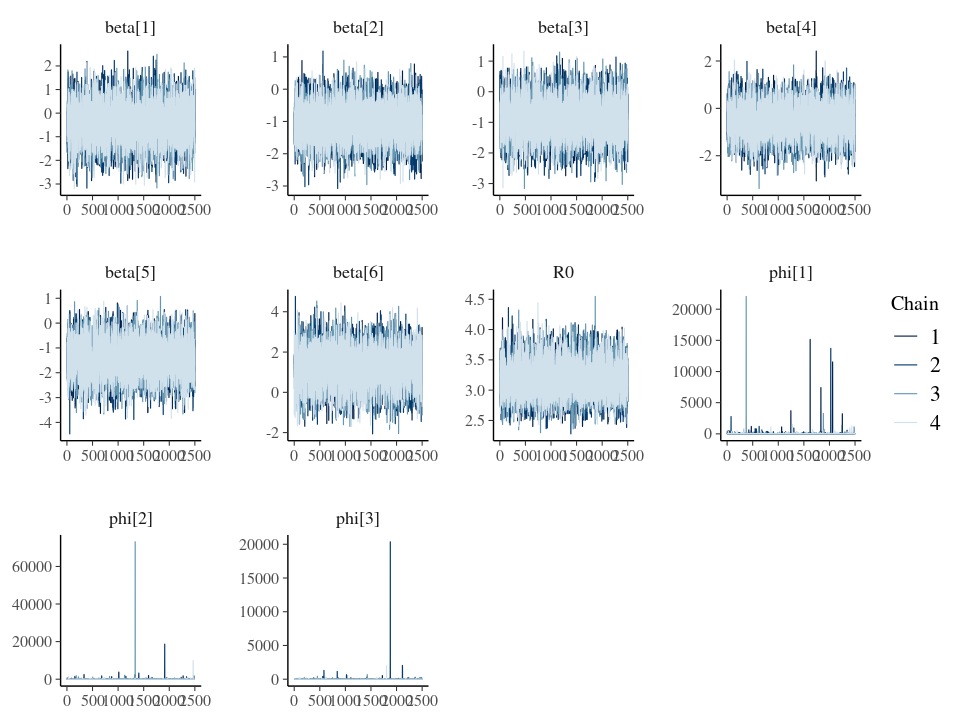

In [76]:
mod_Rt_mixture_changepoint$summary(c("beta", "R0", "phi")) |> mutate(across(where(is.numeric), ~round(.,3)))

options(repr.plot.width=8, repr.plot.height=6)
mcmc_trace(mod_Rt_mixture_changepoint$draws(c("beta", "R0", "phi")))

In [77]:
mod_Rt_mixture_changepoint$summary(c("q")) |> mutate(across(where(is.numeric), ~round(.,3))) |> arrange(-mean) |> head()

variable mean  median sd    mad q5 q95 rhat  ess_bulk ess_tail
1 q[1,3]   0.764 1      0.416 0   0  1   1.000 1322.240       NA
2 q[1,1]   0.236 0      0.416 0   0  1   1.001 1924.981       NA
3 q[1,2]   0.000 0      0.000 0   0  0   1.000 6966.663 5211.305
4 q[1,4]   0.000 0      0.000 0   0  0   1.001 2713.515       NA

In [78]:
# ['retail_recreation', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential']
combn(6, n_Ps_) |> t() |> as.data.frame() |> mutate(idx = 1:n())

V1 V2 V3 V4 V5 V6 idx
1 1  2  3  4  5  6  1

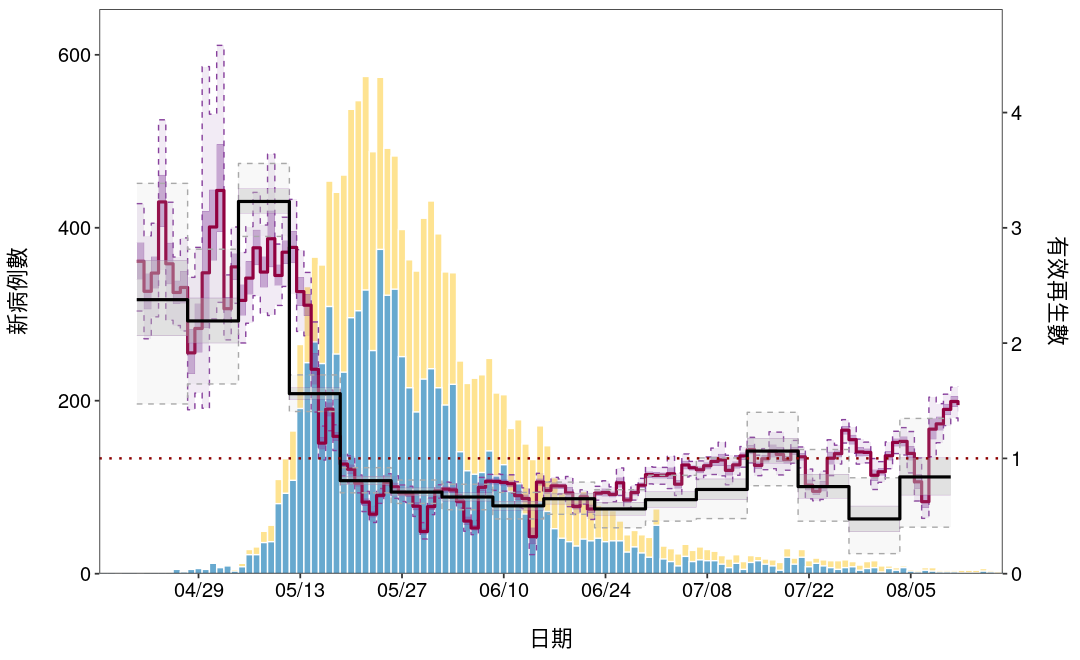

In [79]:
cs = c(9, 5.5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

mindate_Rt = min(output_Rt_infection$Onset)#as.Date("2021-04-15")
maxdate_Rt = as.Date("2021-08-12")#truncation_date - 1
maxdate_incidence = maxdate_Rt + 7
                       
clr_[1] = "#88419d"

## Rt by date of infection
output_ = mod_Rt_mixture_changepoint$summary(c("Rt"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
out = stringr::str_match_all(output_$variable, "[\\d+(.*)]")
output_$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
output_ %>% 
    mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), Onset = mindate + index) %>%
    rename(Rt = `50%`, Rt_lower = `2.5%`, Rt_upper = `97.5%`, Rt_IQR_lower = `25%`, Rt_IQR_upper = `75%`) %>%
    select(Onset, index, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) -> output_Rt_mixture_interventions
                       
                       
output_Rt_infection |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_Rt_infection_
output_Rt_infection_ |> tail(1) |> mutate(Onset = Onset + 7) |> rbind(output_Rt_infection) |> arrange(Onset) -> output_Rt_infection_
                       
output %>% 
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), aes(x=d, y=(n+median)), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
                       
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt),
                   aes(ymax=Rt_IQR_upper/scaling_parameter, ymin=Rt_IQR_lower/scaling_parameter), fill=clr_[1], alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                   aes(ymax=Rt_upper/scaling_parameter, ymin=Rt_lower/scaling_parameter), fill=clr_[1], alpha = 0.1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_upper/scaling_parameter), color=clr_[1], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_lower/scaling_parameter), color=clr_[1], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_upper/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_lower/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt/scaling_parameter), color="#91003f", size=.9, alpha=1) +
                       
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_infection_,
                   aes(ymax=Rt_IQR_upper/scaling_parameter, ymin=Rt_IQR_lower/scaling_parameter), fill="grey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_infection_, 
                   aes(ymax=Rt_upper/scaling_parameter, ymin=Rt_lower/scaling_parameter), fill="grey", alpha = 0.1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_upper/scaling_parameter), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_lower/scaling_parameter), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_IQR_upper/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_IQR_lower/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt/scaling_parameter), color="black", size=.9, alpha=1) +
                       
        geom_hline(yintercept=1/scaling_parameter, linetype="dotted", color = "darkred", size = 0.7) + 
        labs(x="\n日期", y="新病例數\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        scale_y_continuous(expand = expansion(mult = c(0, .02)),
                    sec.axis = sec_axis(~.*scaling_parameter, name = "有效再生數\n")) +
        coord_cartesian(ylim=c(0,ymax), xlim=c(mindate_Rt, maxdate_Rt)) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt
plt
                    
if (generateFigures) { for (filetype_ in c("png"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/rt_by_infection_mobility_Xs-",n_Ps_,"-chn.",filetype_))
}

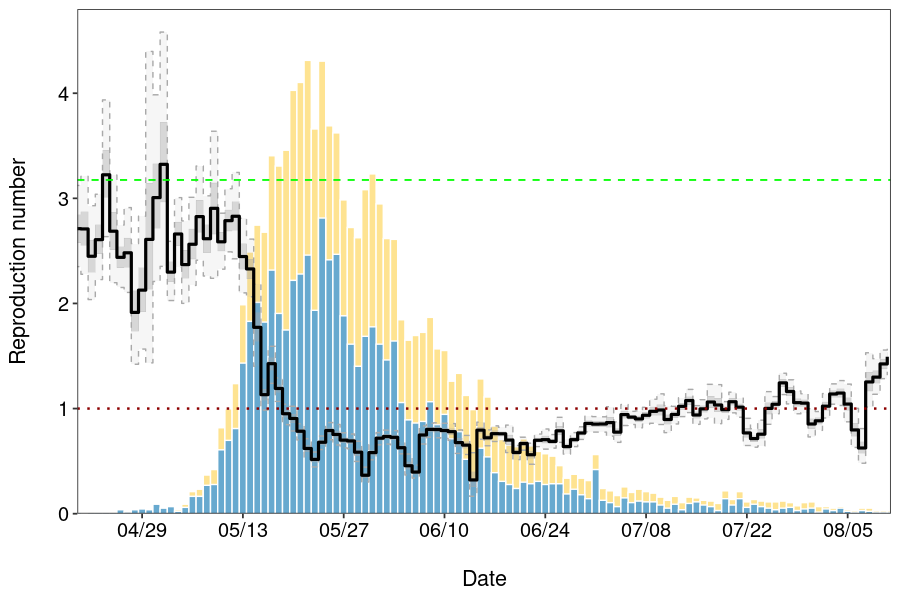

In [80]:
cs = c(7.5, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

mindate_Rt = as.Date("2021-04-20")#min(output_Rt_infection$Onset)#
maxdate_Rt = as.Date("2021-08-11")#truncation_date - 1
maxdate_incidence = maxdate_Rt + 7
                       
clr_[1] = "#88419d"

R0_ = mod_Rt_mixture_changepoint$summary(c("R0"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
                       
output %>% 
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median*scaling_parameter), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), aes(x=d, y=(n+median)*scaling_parameter), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n*scaling_parameter),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
                       
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt),
                   aes(ymax=Rt_IQR_upper, ymin=Rt_IQR_lower), fill="darkgrey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                   aes(ymax=Rt_upper, ymin=Rt_lower), fill="darkgrey", alpha = 0.1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_upper), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_lower), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_upper), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_lower), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt), color="black", size=.9, alpha=1) +
                  
        geom_hline(yintercept = R0_$`50%`, linetype="dashed", color='green') +

        geom_hline(yintercept=1, linetype="dotted", color = "darkred", size = 0.7) + 
        labs(x="\nDate", y="Reproduction number\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax*scaling_parameter), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt
plt
                    
if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/rt_by_infection_mobility_Xs-",n_Ps_,".",filetype_))
                      
    output_Rt_mixture_interventions %>% select(Onset, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) %>%
        write.csv(file=paste0(results_dir,"/rt_by_infection_mobility_Xs-",n_Ps_,".csv"),row.names=FALSE)
}

In [81]:
get_mod_Rt = \(standirname) {
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    return(as_cmdstan_fit(output_files, check_diagnostics=TRUE))
}

mod_Rt = c()
loo_mod_Rt = c()
loo_se_mod_Rt = c()
pareto_k = c()
ind_ = T
Ps = c(); llk_types = c()
for (n_Ps_ in 1:6) {
    standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_mobility_Xs-"%&%n_Ps_
    mod_ = get_mod_Rt(standirname)
    mod_Rt = c(mod_Rt, mod_) 
    loo_ = mod_$loo(variables = "llk", cores = 4, moment_match = TRUE)
    pareto_k_ = max(loo_$diagnostics$pareto_k)
    #if (pareto_k_ < 1) 
    {
        pareto_k = c(pareto_k, pareto_k_)
        loo_mod_Rt = c(loo_mod_Rt, loo_[['estimates']]['looic','Estimate'])
        loo_se_mod_Rt = c(loo_se_mod_Rt, loo_[['estimates']]['looic','SE'])
        Ps = c(Ps, n_Ps_)
        if (ind_) {
            elpd_loo_pointwise = loo_$pointwise[, "elpd_loo"]; ind_ = F
        } else elpd_loo_pointwise = cbind(elpd_loo_pointwise, loo_$pointwise[, "elpd_loo"])
    }
}

cbind(Ps,
      loo::pseudobma_weights(elpd_loo_pointwise),
      loo::stacking_weights(elpd_loo_pointwise), 
      pareto_k, loo_mod_Rt, loo_se_mod_Rt
     ) |> as.data.frame() |> rename(pseudobma = V2, stacking = V3) -> df_loo_mobility
round(df_loo_mobility, 2)

Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”


Ps pseudobma stacking pareto_k loo_mod_Rt loo_se_mod_Rt
model1 1  0.00      0.00     0.26     915.94     34.03        
model2 2  0.05      0.00     0.48     904.38     32.47        
model3 3  0.09      0.00     0.51     902.55     32.25        
model4 4  0.17      0.00     0.52     901.06     32.20        
model5 5  0.30      0.05     0.37     899.97     32.12        
model6 6  0.38      0.95     0.51     899.56     32.13

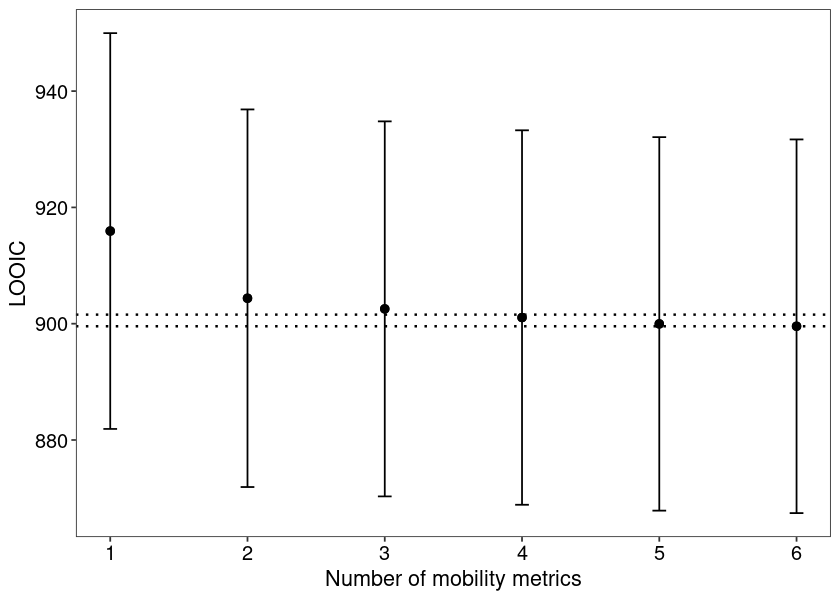

In [82]:
cs = c(7, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

df_loo_mobility |>
    ggplot(aes(x=Ps)) +
        geom_point(aes(y=loo_mod_Rt), size=2) +
        geom_point(aes(y=loo_mod_Rt), size=2) +
        geom_errorbar(aes(ymin = loo_mod_Rt - loo_se_mod_Rt, ymax = loo_mod_Rt + loo_se_mod_Rt), position=position_dodge(.9), width=.1) + 
        geom_hline(yintercept=min(df_loo_mobility$loo_mod_Rt), linetype="dotted", color = "black", size = 0.7) + 
        geom_hline(yintercept=min(df_loo_mobility$loo_mod_Rt)+2, linetype="dotted", color = "black", size = 0.7) + 
        
        coord_cartesian(xlim=c(1,6)) +
        scale_x_continuous(name="Number of mobility metrics",breaks=1:6) +
        scale_y_continuous(name="LOOIC") +
        theme_bw() + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/loocv.",filetype_))
}

# Stan program with mobility and changepoint

In [83]:
as.Date("2021-07-01") - mindate

Time difference of 92 days

In [84]:
as.Date("2021-05-12") - mindate

Time difference of 42 days

In [85]:
(t_ref_intervention = as.numeric(as.Date("2021-05-15") - mindate))

[1] 45

In [86]:
stan_code_Rt = 'functions {
    '%&%qfunctions_txt%&%'

    /* discretized version of gamma distribution used for generation time */
    vector pgamma(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(gamma_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of lognormal distribution used for the reporting delay */
    vector plognormal(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    // see for details "Modeling control measures" https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html
    // nu is the decrease in transmission while control measures are fully in place
    // xi is the slope of the decrease
    // nu is the delay (after the date of introduction of control measures) until the measures are 50% effective
    real switch_eta(real t, real t1, real eta, real nu, real xi) {
        return eta + (1 - eta) / (1 + exp(xi * (t - t1 - nu)));
    }
}

// Likelihood type
// 1: negative binomial 2 (NB2) = overdispersion is constant
// 2: negative binomial 1 (NB1) = overdispersion is proportional to the mean
// 3: negative binomial sqrt (NBsqrt) = overdispersion is proportional to the square root of the mean
// 4: Poisson

data {
    int<lower = 1> K; // truncation date
    array[K] int<lower = 0> cases_onset, // number of cases with symptoms onset on given days 1...K
                            cases_unobs; // number of cases with unknown symptoms onset on given days of confirmation 1..K

    int Kmin, Kmax; // time frame for inference of Rt
    int tswitch_min;
    int t_ref_scenario; // starting time when different scenarios are considered
    int t_start_scenario;
    int scenario_shift_max; // maximum shift in days for scenarios

    // infectiousness profile (modeled by shifted gamma distribution)
    real<lower = 0> shift_lambda; 
    int<lower = 0> X; //floor of the shift
    real<lower = 0> param1_lambda, param2_lambda;

    // incubation period (modeled by lognormal distribution)
    real param1_IP, param2_IP; 

    // delay
    array[K] real log_mean_delay_onset_median, log_mean_delay_onset_IQR, log_mean_delay_onset_asymmetry, log_mean_delay_onset_steepness,
                  log_mean_delay_confirm_median, log_mean_delay_confirm_IQR, log_mean_delay_confirm_asymmetry, log_mean_delay_confirm_steepness;
    real log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness,
         log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness;

    int<lower = 1> M; // total number of mobility metrics or their principal components
    matrix[K, M] y; // mobility

    int<lower = 1> C; // total number of combinations of mobility metrics
    int<lower = 1> N; // number of used mobility metrics
    array[C, N] int mobility_indexes; // particular sets of mobility metrics
}

transformed data {
    // Infectiousness profile (modeled by shifted gamma distribution, He et al NatMed 2020)
    vector[K+X] lambda, lambda_rev;
    {
        vector[K+X] res;
        for (k in 1:K+X)
            res[k] = exp(gamma_lcdf(shift_lambda - X + k | param1_lambda, param2_lambda));
        lambda = append_row(res[1], res[2:K+X]-res[1:K+X-1]);
    }
    lambda_rev = reverse(lambda);

    // Incubation period (modeled by lognormal distribution, Li et al NEJM 2020)
    vector[K] ht = plognormal(param1_IP, param2_IP, K),
              ht_rev = reverse(ht);

    int<lower = 1> n_llk_types = 4;
    int<lower = 1> Pi = n_llk_types * C;

    array[scenario_shift_max] matrix[K, M] y_modified_left;
    for (shift_to_the_left in 1:scenario_shift_max) {
        y_modified_left[shift_to_the_left, 1:t_ref_scenario-shift_to_the_left-1, 1:M] = y[1:t_ref_scenario-shift_to_the_left-1, 1:M];
        y_modified_left[shift_to_the_left, t_ref_scenario-shift_to_the_left:K-shift_to_the_left, 1:M] = y[t_ref_scenario:K, 1:M];
        for(i in 1:shift_to_the_left) for (m in 1:M)
            y_modified_left[shift_to_the_left, K-i, m] = y[K, m]; // this line does not really matter, so we simply duplicate the last rows
    }

}

parameters {
    vector<lower = 0, upper = 1>[K] p_mean_delay_onset, p_mean_delay_confirm;
    real<lower = 0, upper = 1> p_cv_delay_onset, p_cv_delay_confirm;

    real<lower = 0> R0;
    vector[M] beta;
    array[3] real<lower = 0> phi;

    simplex[Pi] weight; // mixing proportions

    real<lower = 0, upper = 1> eta;
    real<lower = 0> nu;
    real<lower = 0, upper = 1> xi_raw, tswitch_raw;
}

transformed parameters {
    real xi = xi_raw + 0.5, tswitch = fma(K - tswitch_min, tswitch_raw, tswitch_min);

    row_vector<lower = 0>[K] mean_delay_onset, mean_delay_confirm;
    real<lower = 0> cv_delay_onset, cv_delay_confirm;
    for (k in 1:K) {
        mean_delay_onset[k] = exp(GLD_icdf(p_mean_delay_onset[k], log_mean_delay_onset_median[k], log_mean_delay_onset_IQR[k], log_mean_delay_onset_asymmetry[k], log_mean_delay_onset_steepness[k]));
        mean_delay_confirm[k] = exp(GLD_icdf(p_mean_delay_confirm[k], log_mean_delay_confirm_median[k], log_mean_delay_confirm_IQR[k], log_mean_delay_confirm_asymmetry[k], log_mean_delay_confirm_steepness[k]));
    }
    cv_delay_onset = exp(GLD_icdf(p_cv_delay_onset, log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness));
    cv_delay_confirm = exp(GLD_icdf(p_cv_delay_confirm, log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness));

    // Lognormal distribution is used for reporting delay as it was selected previously
    real param2_delay_onset = sqrt(log(square(cv_delay_onset) + 1.0)),
         param2_delay_confirm = sqrt(log(square(cv_delay_confirm) + 1.0));
    row_vector[K] param1_delay_onset = log(mean_delay_onset) - square(param2_delay_onset) / 2.0,
                  param1_delay_confirm = log(mean_delay_confirm) - square(param2_delay_confirm) / 2.0;

    vector[Pi] lps = log(weight);
    {
        vector[K] cases_backproj = to_vector(cases_onset);
        // (1) backprojection of cases with unknown dates of symptom onset 
        //// in this case we use the delay by date of confirmation
        array[K] vector[K] delay_by_confirm;
        for (day in 1:K)
            delay_by_confirm[day] = plognormal(param1_delay_confirm[day], param2_delay_confirm, K);
        //// adding to the case count
        for (day in 1:K-1)
            for (k in (day+1):K)
                cases_backproj[day] += cases_unobs[k] * delay_by_confirm[k, k - day];
        // (2) nowcasting of all cases
        //// in this case we use the delay by date of symptoms onset
        vector[K] cases_predicted;
        for (day in 1:K)
            cases_predicted[day] = cases_backproj[day] / exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));

        vector[K + X] cases_predicted_ext = append_row(cases_predicted, rep_vector(0, X));

        int c, llk_type;
        vector[K] forcing_function;
        for (t in 1:K) 
            forcing_function[t] = switch_eta(t, tswitch, eta, nu, xi);

        for (idx in 1:Pi) {
            llk_type = (idx - 1) % n_llk_types + 1;
            c = (idx - 1) %/% n_llk_types + 1;

            vector[K] Rt;
            if (N<M) {
                array[N] int mobility_metrics = mobility_indexes[c, 1:N];
                Rt = R0 * forcing_function .* exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
            } else
                Rt = R0 * forcing_function .* exp(-y * beta); 

            vector[K] infections; // infections per day
            for (day in 1:K) { 
                infections[day] = Rt[day] * dot_product(head(cases_predicted_ext, day + X), tail(lambda_rev, day + X));
            }

            real r_infection, a_infection;
            for (day in Kmin:Kmax) if (cases_predicted_ext[day] > 0) {
                real mu_infection = (day == 2) ? infections[1] * ht_rev[1] : dot_product(head(infections, day-1), tail(ht_rev, day-1));
                if (llk_type==1)
                    r_infection = phi[1] / (phi[1] + mu_infection);
                else if (llk_type==2)
                    r_infection = phi[2] / (phi[2] + 1.0);
                else if (llk_type==3)
                    r_infection = phi[3] / (phi[3] + sqrt(mu_infection));
                else if (llk_type==4)
                    r_infection = 1.0;
                a_infection = mu_infection * r_infection;
                lps[idx] += gamma_lpdf(cases_predicted_ext[day] | a_infection, r_infection);
            }
        }
    }
}

model {
    /* priors */
    R0 ~ normal(3.2, 1.6);
    beta ~ std_normal();
    phi ~ cauchy(0, 5);

    eta ~ beta(2.5, 4);
    nu ~ exponential(0.2);
    xi_raw ~ beta(1, 1);
    tswitch_raw ~ beta(1, 1);

    target += log_sum_exp(lps);
}

generated quantities {  
    array[K-1] int cases_backprj = rep_array(0, K-1), 
                   cases_unreported = rep_array(0, K-1), 
                   cases_predicted; 

    matrix<lower = 0, upper = 1>[C, n_llk_types] q;
    int<lower = 1> index_c, index_llk_type; 
    vector<lower = 0>[K] Rt;
    vector[Kmax-Kmin+1] llk;
    array[Kmax-Kmin+1] int cases_baseline;
    array[scenario_shift_max, Kmax-Kmin+1] int cases_scenario_left;
    array[N] vector[K] q_c; // contribution of different metrics
    {
        for (day in 2:K) if (cases_unobs[day] > 0) {
            vector[day-1] delay_by_confirm = plognormal(param1_delay_confirm[day], param2_delay_confirm, day-1);
            vector[day-1] probs = reverse(delay_by_confirm) ./ sum(delay_by_confirm);
            array[day-1] int counts = multinomial_rng(probs, cases_unobs[day]);
            for (i in 1:day-1) 
                cases_backprj[i] += counts[i];
        }
        for (day in 1:K-1) {
            int cases = cases_onset[day] + cases_backprj[day];
            real F = exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));
            cases_unreported[day] = (cases > 0) ? neg_binomial_2_rng(cases * (1 - F) / F + 1e-8, cases) : 0;
            cases_predicted[day] = cases + cases_unreported[day];
        }

        array[K + X] int cases_predicted_ext = append_array(cases_predicted, rep_array(0, X + 1));

        vector[Pi] q_ = softmax(lps); //the same as exp(lps - log_sum_exp(lps));
        int n_selected = categorical_rng(q_);
        int c, llk_type;
        for (idx in 1:Pi) {
            llk_type = (idx - 1) % n_llk_types + 1;
            c = (idx - 1) %/% n_llk_types + 1;
            q[c, llk_type] = q_[idx];
        }
        index_llk_type = (n_selected - 1) % n_llk_types + 1;
        index_c = (n_selected - 1) %/% n_llk_types + 1;

        vector[K] forcing_function;
        for (t in 1:K) 
            forcing_function[t] = switch_eta(t, tswitch, eta, nu, xi);

        array[N] int mobility_metrics = mobility_indexes[index_c, 1:N];
        array[scenario_shift_max] vector[K] Rt_left;
        if (N<C) {
            Rt = R0 * forcing_function .* exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
            for (shift_to_the_left in 1:scenario_shift_max) {
                Rt_left[shift_to_the_left] = R0 * forcing_function .* exp(-y_modified_left[shift_to_the_left][1:K, mobility_metrics] * beta[mobility_metrics]);
            }
        } else {
            Rt = R0 * forcing_function .* exp(-y * beta);
            for (shift in 1:scenario_shift_max) {
                Rt_left[shift] = R0 * forcing_function .* exp(-y_modified_left[shift] * beta);
            }
        }
        for (n_ in 1:N) 
            q_c[n_] = exp(y[1:K, mobility_metrics[n_]] * beta[mobility_metrics[n_]]);

        // the following code includes calculation of the likelihood "llk" required for LOOIC 
        vector[K] infections_expected_baseline; // infections per day
        array[scenario_shift_max] vector[K] infections_expected_scenario_left; 
        for (day in 1:K) {
            infections_expected_baseline[day] = Rt[day] * dot_product(head(to_vector(cases_predicted_ext), day + X), tail(lambda_rev, day + X));
            for (shift in 1:scenario_shift_max) {
                infections_expected_scenario_left[shift, day] =  Rt_left[shift, day] * dot_product(head(to_vector(cases_predicted_ext), day + X), tail(lambda_rev, day + X));
            }
        }
        real r_infection, a_infection;
        for (day in Kmin:Kmax) {
            real mu_infection_baseline = (day == 2) ? infections_expected_baseline[1] * ht_rev[1] : dot_product(head(infections_expected_baseline, day-1), tail(ht_rev, day-1));
            array[scenario_shift_max] real mu_infection_scenario_left;
            for (shift in 1:scenario_shift_max) {
                mu_infection_scenario_left[shift] = (day == 2) ? infections_expected_scenario_left[shift, 1] * ht_rev[1] : dot_product(head(infections_expected_scenario_left[shift], day-1), tail(ht_rev, day-1));
            }
            if (index_llk_type==1) {
                r_infection = phi[1] / (phi[1] + mu_infection_baseline);
                cases_baseline[day-Kmin+1] = neg_binomial_2_rng(mu_infection_baseline, phi[1]);
                for (shift in 1:scenario_shift_max) {
                    cases_scenario_left[shift][day-Kmin+1] = neg_binomial_2_rng(mu_infection_scenario_left[shift], phi[1]);
                }
            } else if (index_llk_type==2) {
                r_infection = phi[2] / (phi[2] + 1.0);
                cases_baseline[day-Kmin+1] = neg_binomial_2_rng(mu_infection_baseline, phi[2] * mu_infection_baseline);
                for (shift in 1:scenario_shift_max) {
                    cases_scenario_left[shift][day-Kmin+1] = neg_binomial_2_rng(mu_infection_scenario_left[shift], phi[2] * mu_infection_scenario_left[shift]);
                }
            } else if (index_llk_type==3) {
                r_infection = phi[3] / (phi[3] + sqrt(mu_infection_baseline));
                cases_baseline[day-Kmin+1] = neg_binomial_2_rng(mu_infection_baseline, phi[3] * sqrt(mu_infection_baseline));
                for (shift in 1:scenario_shift_max) {
                    cases_scenario_left[shift][day-Kmin+1] = neg_binomial_2_rng(mu_infection_scenario_left[shift], phi[3] * sqrt(mu_infection_scenario_left[shift]));
                }
            } else if (index_llk_type==4) {
                r_infection = 1.0;
                cases_baseline[day-Kmin+1] = poisson_rng(mu_infection_baseline);
                for (shift in 1:scenario_shift_max) {
                    cases_scenario_left[shift][day-Kmin+1] = poisson_rng(mu_infection_scenario_left[shift]);
                }
            }
            a_infection = mu_infection_baseline * r_infection;
            llk[day-Kmin+1] = gamma_lpdf(cases_predicted_ext[day] + 1e-8 | a_infection, r_infection);
        }
    }
}'

Kmin = df_cases_pca |> filter(d=='2021-04-15') %>% .$t
Kmax = df_cases_pca |> filter(d==truncation_date-14) %>% .$t
(t_ref_scenario = df_cases_pca |> filter(d=='2021-05-15') %>% .$t)
(t_start_scenario = t_ref_scenario - 7)
c(Kmin, Kmax)

foo_Rt = \(N, isPCA) {
    M = 6
    
    if (isPCA) {
        standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_changepoint_mobility_PCs-"%&%N
        df_cases_pca |> select(starts_with("y")) |> as.matrix() -> mat 
        if (N==1) {
            C = 1
            mobility_indexes = structure(c(1), .Dim=c(1,1))
        } else {
            mob_ = combn(M-1, N-1) |> t() %>% {. + 1}
            mobility_indexes = cbind(rep(1, nrow(mob_)), mob_)
            C = nrow(mob_) }
    } else {
        standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_2_changepoint_mobility_Xs-"%&%N
        df_cases_pca |> select(starts_with("x")) |> as.matrix() -> mat
        C = choose(M, N)
        mobility_indexes = combn(M, N) |> t()
    }
        
    unlink(standirname, recursive=T)
    dir.create(standirname)
    
    file.copy("quantile_functions.stan", standirname)
    
    stan_code_Rt %>% cat(file=standirname %&% "/model_Rt.stan", sep="", fill=TRUE)    
    
    ## @data ##
    K = truncation_day
    cases_onset = df_cases_pca$n
    cases_unobs = df_cases_pca$n_unobs
    y = structure(mat, .Dim = c(K, M))
    tswitch_min = 92
    scenario_shift_max = 3
    # infectiousness profile
    shift_lambda = 12.3
    X = 13
    param1_lambda = param1_lambda
    param2_lambda = param2_lambda
    # incubation period
    param1_IP = 1.434065
    param2_IP = 0.6612
    rstan::stan_rdump(c("K", "cases_onset", "cases_unobs", "y", "Kmin", "Kmax", 
                        "scenario_shift_max", "t_ref_scenario", "tswitch_min", "t_start_scenario",
                        "mobility_indexes", "C", "N", "M",
                        "shift_lambda", "X", "param1_lambda", "param2_lambda", 
                        "param1_IP", "param2_IP", 
                        "log_mean_delay_onset_median", "log_mean_delay_onset_IQR", "log_mean_delay_onset_asymmetry", "log_mean_delay_onset_steepness",
                        "log_cv_delay_onset_median", "log_cv_delay_onset_IQR", "log_cv_delay_onset_asymmetry", "log_cv_delay_onset_steepness", 
                        "log_mean_delay_confirm_median", "log_mean_delay_confirm_IQR", "log_mean_delay_confirm_asymmetry", "log_mean_delay_confirm_steepness",
                        "log_cv_delay_confirm_median", "log_cv_delay_confirm_IQR", "log_cv_delay_confirm_asymmetry", "log_cv_delay_confirm_steepness"), 
                      file=standirname%&%"/Data.R")
    
    R0 = 3.2
    beta = rep(-0.1, M)
    phi = rep(10.0, 3)
    xi_raw = 0.1
    eta = 0.2
    nu = 2.0
    tswitch_raw = 0.5
    rstan::stan_rdump(c("R0", "beta", "phi", "xi_raw", "eta", "nu", "tswitch_raw"), file=standirname%&%"/Init.R")
    
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)
    
    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model_Rt
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..4}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model_Rt \\
            method=sample num_samples=1250 num_warmup=1000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            init=Init.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

[1] 45

[1] 38

[1]  15 133

In [87]:
recalc_Rt = F
isPCA = F
if (recalc_Rt) { 
    foo_Rt(1, isPCA); 
    #foo_Rt(4, isPCA); 
    #foo_Rt(3, isPCA);
}

## With google metrics

In [88]:
n_Ps_ = 6
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_2_changepoint_mobility_Xs-"%&%n_Ps_
output_files = c(); idx = 1
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
    print(fl_)
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_Rt_mixture_changepoint = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_2_changepoint_mobility_Xs-6/trace-1.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_2_changepoint_mobility_Xs-6/trace-2.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_2_changepoint_mobility_Xs-6/trace-3.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_infection_2_changepoint_mobility_Xs-6/trace-4.csv"


variable mean    median  sd       mad   q5     q95     rhat  ess_bulk
1  beta[1]   -0.520  -0.512    0.839 0.869 -1.878   0.845 1.001 5597.867
2  beta[2]   -1.184  -1.183    0.573 0.577 -2.113  -0.232 1.001 4639.751
3  beta[3]   -0.242  -0.234    0.714 0.720 -1.410   0.925 1.005  886.315
4  beta[4]   -0.896  -0.890    0.750 0.753 -2.147   0.316 1.001 2277.546
5  beta[5]   -1.532  -1.518    0.747 0.739 -2.780  -0.334 1.000 2941.684
6  beta[6]    0.972   0.965    0.986 0.977 -0.671   2.604 1.002 6229.916
7  R0         3.121   3.107    0.275 0.275  2.690   3.597 1.000 5382.018
8  phi[1]    33.375  30.855  209.334 9.179  2.282  48.367 1.015  272.360
9  phi[2]    68.024   4.988 2734.017 5.405  0.357  62.690 1.002 6625.902
10 phi[3]    20.815   4.009  141.672 3.584  0.470  47.748 1.005 4601.789
11 eta        0.549   0.549    0.135 0.153  0.321   0.749 1.006  390.702
12 tswitch  107.436 110.346    9.095 8.190 92.380 118.418 1.007  373.146
13 xi         0.961   0.944    0.289 0.369  0.538   1.435 1.002 7386.271
14 nu         3.952   2.510    4.208 2.839  0.143  12.901 1.002  895.814
   ess_tail
1  4004.109
2  4001.297
3  2767.521
4  3852.550
5  3479.053
6  3468.115
7  3844.974
8   200.056
9  2407.934
10 2384.009
11 1163.283
12  948.779
13 3663.492
14 2551.175

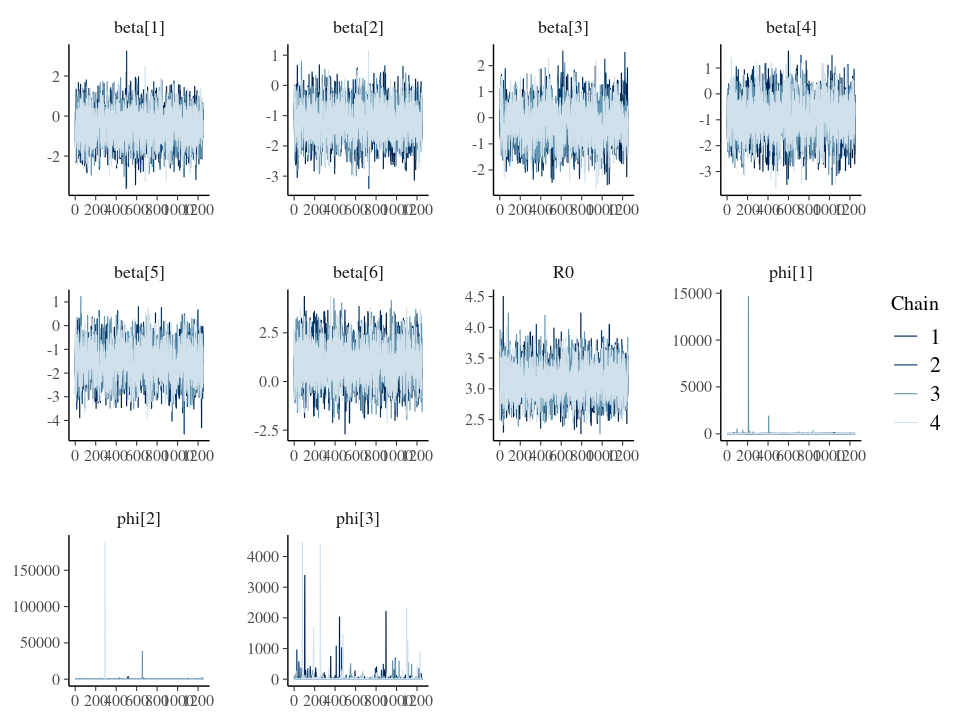

In [89]:
mod_Rt_mixture_changepoint$summary(c("beta", "R0", "phi", "eta", "tswitch", "xi", "nu")) |> mutate(across(where(is.numeric), ~round(.,3)))

options(repr.plot.width=8, repr.plot.height=6)
mcmc_trace(mod_Rt_mixture_changepoint$draws(c("beta", "R0", "phi")))

In [90]:
mod_Rt_mixture_changepoint$summary(c("q")) |> mutate(across(where(is.numeric), ~round(.,3))) |> arrange(-mean) |> head()

variable mean  median sd    mad q5 q95 rhat  ess_bulk ess_tail
1 q[1,1]   0.816 1      0.377 0   0  1   1.016  197.303       NA
2 q[1,3]   0.184 0      0.377 0   0  1   1.013  283.702       NA
3 q[1,2]   0.000 0      0.000 0   0  0   1.003 1349.185 3066.164
4 q[1,4]   0.000 0      0.000 0   0  0   1.008  444.068       NA

In [91]:
# best combination
c_selected = mod_Rt_mixture_changepoint$summary(c("q")) |> mutate(across(where(is.numeric), ~round(.,3))) |> arrange(-mean) |> head(1) %>% .$variable# %>% unlist(strsplit(., ","))#[[1]]
c_selected = as.numeric(paste( stringr::str_match_all(strsplit(c_selected, ",")[[1]][1], "[\\d+(.*)]")[[1]],collapse=""))
c_selected

[1] 1

In [92]:
# ['retail_recreation', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential']
combn(6, n_Ps_) |> t() |> as.data.frame() |> mutate(idx = 1:n())

V1 V2 V3 V4 V5 V6 idx
1 1  2  3  4  5  6  1

In [93]:
Rt_function = \(t, tswitch, eta, nu, xi) { eta + (1 - eta) / (1 + exp(xi * (t - tswitch - nu))) }

t = 1:truncation_day
Rt_ = c()
for (iter in 1:5000) {
    tswitch = mod_Rt_mixture_changepoint$draws(c("tswitch"))[iter]
    xi = mod_Rt_mixture_changepoint$draws(c("xi"))[iter]
    eta = mod_Rt_mixture_changepoint$draws("eta")[iter]
    nu = mod_Rt_mixture_changepoint$draws("nu")[iter]
    R0 = mod_Rt_mixture_changepoint$draws("R0")[iter]
    
    Rt_ = c(Rt_, sapply(t, \(t) R0*Rt_function(t, tswitch, eta, xi, nu)))
}

In [94]:
matrix(Rt_, nrow=length(t)) -> Rt_
R0_median = apply(Rt_, 1, median, na.rm=T) %>% as.data.frame |> mutate(t=1:n())
colnames(R0_median)[1] = 'R0'
(R0_median |> t())

R0_upper = apply(Rt_, 1, \(x) { quantile(x, probs=c(0.975), na.rm=T) }) %>% as.data.frame |> mutate(t=1:n())
colnames(R0_upper)[1] = 'R0'
(R0_upper |> t())

R0_lower = apply(Rt_, 1, \(x) { quantile(x, probs=c(0.025), na.rm=T) }) %>% as.data.frame |> mutate(t=1:n())
colnames(R0_lower)[1] = 'R0'
(R0_lower |> t())

[,1]    [,2]    [,3]    [,4]    [,5]    [,6]    [,7]    [,8]     [,9]    
R0 3.10448 3.10444 3.10444 3.10444 3.10444 3.10444 3.10444 3.104345 3.104345
t  1.00000 2.00000 3.00000 4.00000 5.00000 6.00000 7.00000 8.000000 9.000000
   [,10]     [,11] [,12]      [,13]      [,14]      [,15]      [,16]    
R0  3.104345 ⋯       1.725379   1.725243   1.724055   1.723697   1.72353
t  10.000000 ⋯     138.000000 139.000000 140.000000 141.000000 142.00000
   [,17]     [,18]      [,19]      [,20]      [,21]     
R0   1.72353   1.722949   1.722478   1.721475   1.721078
t  143.00000 144.000000 145.000000 146.000000 147.000000

[,1]     [,2]     [,3]     [,4]     [,5]   [,6]     [,7]     [,8]    
R0 3.674213 3.674213 3.674198 3.674178 3.6737 3.672868 3.672853 3.672828
t  1.000000 2.000000 3.000000 4.000000 5.0000 6.000000 7.000000 8.000000
   [,9]    [,10]    [,11] [,12]      [,13]    [,14]      [,15]     [,16]    
R0 3.67281  3.67281 ⋯       2.551316   2.5507   2.549169   2.54916   2.54807
t  9.00000 10.00000 ⋯     138.000000 139.0000 140.000000 141.00000 142.00000
   [,17]      [,18]      [,19]      [,20]      [,21]     
R0   2.546397   2.545004   2.544384   2.543969   2.543969
t  143.000000 144.000000 145.000000 146.000000 147.000000

[,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]    
R0 2.589983 2.589983 2.589983 2.589983 2.589983 2.588264 2.587342 2.587342
t  1.000000 2.000000 3.000000 4.000000 5.000000 6.000000 7.000000 8.000000
   [,9]     [,10]     [,11] [,12]       [,13]       [,14]       [,15]      
R0 2.587342  2.587342 ⋯       0.8550269   0.8550269   0.8550269   0.8550269
t  9.000000 10.000000 ⋯     138.0000000 139.0000000 140.0000000 141.0000000
   [,16]       [,17]       [,18]       [,19]       [,20]       [,21]      
R0   0.8550269   0.8550269   0.8547371   0.8547371   0.8517721   0.8517721
t  142.0000000 143.0000000 144.0000000 145.0000000 146.0000000 147.0000000

In [95]:
sprintf("Initial value of baseline R0: %.2f (95%% CI: %.2f, %.2f)", (R0_median |> head(1))$R0, (R0_lower |> head(1))$R0, (R0_upper |> head(1))$R0)
sprintf("Final value of baseline R0: %.2f (95%% CI: %.2f, %.2f)", (R0_median |> tail(1))$R0, (R0_lower |> tail(1))$R0, (R0_upper |> tail(1))$R0)

[1] "Initial value of baseline R0: 3.10 (95% CI: 2.59, 3.67)"

[1] "Final value of baseline R0: 1.72 (95% CI: 0.85, 2.54)"

In [96]:
100*(1 - (R0_median |> tail(1))$R0 / (R0_median |> head(1))$R0)

[1] 44.56148

In [97]:
output_ = mod_Rt_mixture_changepoint$summary(c("tswitch"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
output_ %<>% 
    rename(tswitch_median = `50%`, tswitch_lower = `2.5%`, tswitch_upper = `97.5%`, tswitch_IQR_lower = `25%`, tswitch_IQR_upper = `75%`)
paste0("Switching time: ",format((output_ |> head(1))$tswitch_median + mindate, "%m/%d"), " (95% CI: ",
       format((output_ |> head(1))$tswitch_lower + mindate, "%m/%d"), ", ", format((output_ |> head(1))$tswitch_upper + mindate, "%m/%d"), ")")

[1] "Switching time: 07/19 (95% CI: 07/01, 07/28)"

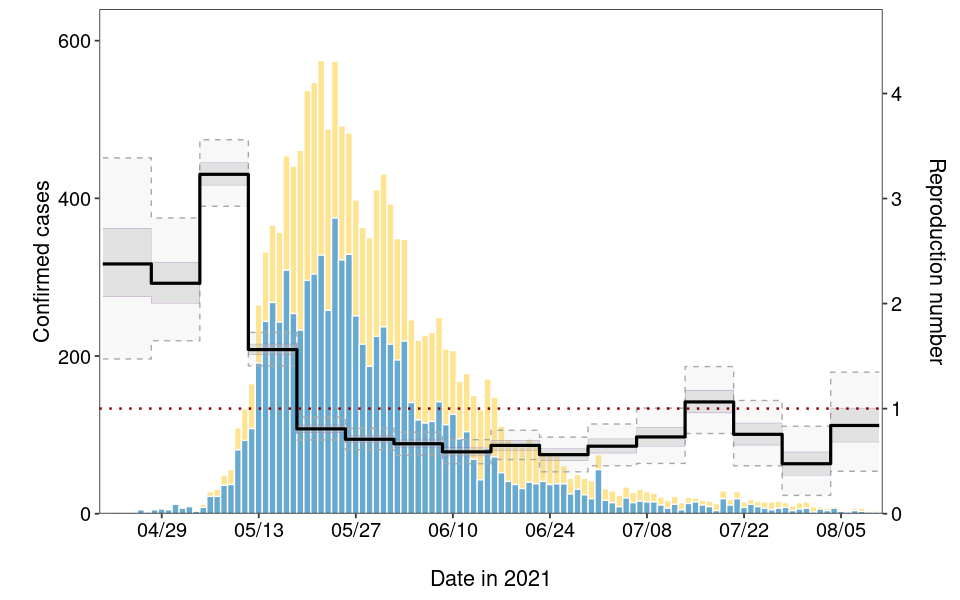

In [98]:
cs = c(8, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])
mindate_Rt = as.Date("2021-04-20")#min(output_Rt_infection$Onset)#
maxdate_Rt = as.Date("2021-08-11")#truncation_date - 1
maxdate_incidence = maxdate_Rt + 7
                       
clr_[1] = "#88419d"

## Rt by date of infection
output_ = mod_Rt_mixture_changepoint$summary(c("Rt"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
out = stringr::str_match_all(output_$variable, "[\\d+(.*)]")
output_$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
output_ %>% 
    mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), Onset = mindate + index) %>%
    rename(Rt = `50%`, Rt_lower = `2.5%`, Rt_upper = `97.5%`, Rt_IQR_lower = `25%`, Rt_IQR_upper = `75%`) %>%
    select(Onset, index, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) -> output_Rt_mixture_interventions
                       
output_Rt_infection |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_Rt_infection_
output_Rt_infection_ |> tail(1) |> mutate(Onset = Onset + 7) |> rbind(output_Rt_infection) |> arrange(Onset) -> output_Rt_infection_
                       
output %>% 
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), aes(x=d, y=(n+median)), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
                       
                       
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_infection_,
                   aes(ymax=Rt_IQR_upper/scaling_parameter, ymin=Rt_IQR_lower/scaling_parameter), fill="grey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_infection_, 
                   aes(ymax=Rt_upper/scaling_parameter, ymin=Rt_lower/scaling_parameter), fill="grey", alpha = 0.1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_upper/scaling_parameter), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_lower/scaling_parameter), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_IQR_upper/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt_IQR_lower/scaling_parameter), color=clr_[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_infection_, 
                  aes(y=Rt/scaling_parameter), color="black", size=.9, alpha=1) +
                       
        geom_hline(yintercept=1/scaling_parameter, linetype="dotted", color = "darkred", size = 0.7) + 
        labs(x="\nDate in 2021", y="\nConfirmed cases") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        scale_y_continuous(expand = expansion(mult = c(0, .02)),
                    #sec.axis = sec_axis(~.*scaling_parameter, name = "有效再生數\n")) +
                    sec.axis = sec_axis(~.*scaling_parameter, name = "Reproduction number\n")) +
        coord_cartesian(ylim=c(0,ymax), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt
plt
                    
if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/rt_by_infection.",filetype_))
}

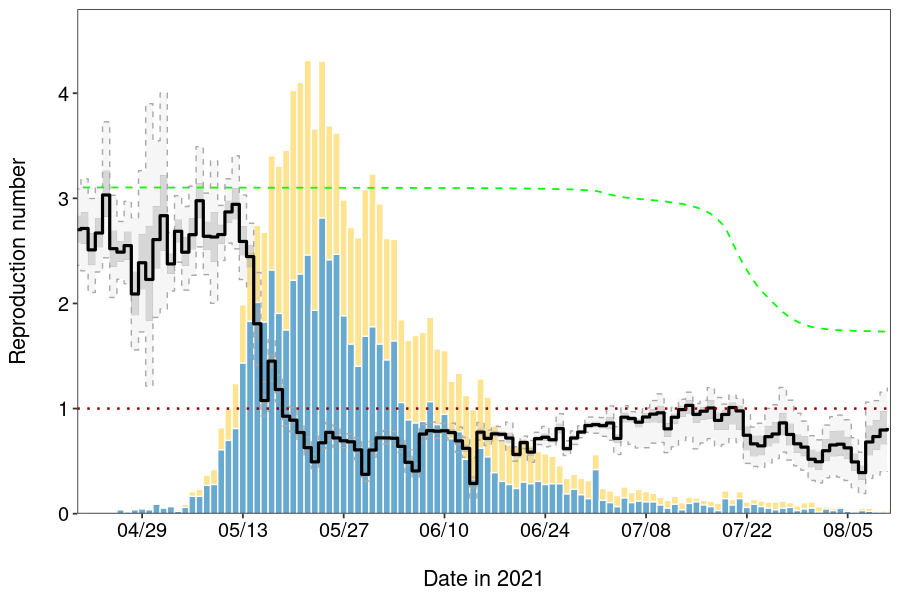

In [99]:
cs = c(7.5, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

mindate_Rt = as.Date("2021-04-20")#min(output_Rt_infection$Onset)#
maxdate_Rt = as.Date("2021-08-11")#truncation_date - 1
maxdate_incidence = maxdate_Rt + 7
                       
clr_[1] = "#88419d"

## Rt by date of infection
output_ = mod_Rt_mixture_changepoint$summary(c("Rt"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
out = stringr::str_match_all(output_$variable, "[\\d+(.*)]")
output_$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
output_ %>% 
    mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), Onset = mindate + index) %>%
    rename(Rt = `50%`, Rt_lower = `2.5%`, Rt_upper = `97.5%`, Rt_IQR_lower = `25%`, Rt_IQR_upper = `75%`) %>%
    select(Onset, index, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) -> output_Rt_mixture_interventions
                              
output_Rt_infection |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_Rt_infection_
output_Rt_infection_ |> tail(1) |> mutate(Onset = Onset + 7) |> rbind(output_Rt_infection) |> arrange(Onset) -> output_Rt_infection_
                       
output %>% 
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median*scaling_parameter), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), aes(x=d, y=(n+median)*scaling_parameter), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n*scaling_parameter),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
                       
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt),
                   aes(ymax=Rt_IQR_upper, ymin=Rt_IQR_lower), fill="darkgrey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                   aes(ymax=Rt_upper, ymin=Rt_lower), fill="darkgrey", alpha = 0.1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_upper), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_lower), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_upper), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_lower), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt), color="black", size=.9, alpha=1) +
                  
        geom_line(data = R0_median |> mutate(x = t+mindate), aes(x = x, y = R0), linetype="dashed", color='green') +

        geom_hline(yintercept=1, linetype="dotted", color = "darkred", size = 0.7) + 
        labs(x="\nDate in 2021", y="Reproduction number\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax*scaling_parameter), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt
plt
                    
if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/rt_by_infection_changepoint_mobility_Xs-",n_Ps_,".",filetype_))
                      
    output_Rt_mixture_interventions %>% select(Onset, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) %>%
        write.csv(file=paste0(results_dir,"/rt_by_infection_changepoint_mobility_Xs-",n_Ps_,".csv"),row.names=FALSE)
}

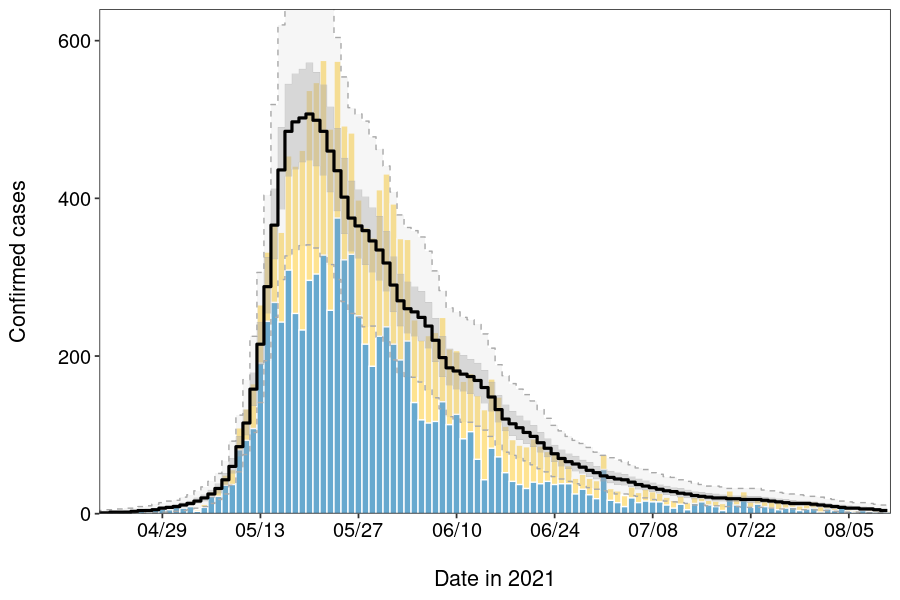

In [100]:
output_ = mod_Rt_mixture_changepoint$summary(c("cases_baseline"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
output_ %>%
    rename(index = variable) |>
    mutate(index = as.numeric(index), Onset = mindate + Kmin - 1 + index) |>
    rename(median = `50%`, lower = `2.5%`, upper = `97.5%`, IQR_lower = `25%`, IQR_upper = `75%`) %>%
    select(Onset, median, lower, upper, IQR_lower, IQR_upper) -> output_cases_baseline

output_cases_baseline |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_cases_baseline_
output_cases_baseline_ |> tail(1) |> mutate(Onset = Onset + 7) |> 
    rbind(output_cases_baseline) |> arrange(Onset) -> output_cases_baseline_

output_cases_baseline_ |> 
    filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) |>
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=(n+median)), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
                       
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymax=IQR_upper, ymin=IQR_lower), fill="darkgrey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(aes(ymax=upper, ymin=lower), fill="darkgrey", alpha = 0.1) +
        geom_step(aes(y=upper), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(aes(y=lower), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(aes(y=IQR_upper), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(aes(y=IQR_lower), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(aes(y=median), color="black", size=.9, alpha=1) +

        labs(x="\nDate in 2021", y="Confirmed cases\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/cases_baseline_validation_changepoint_mobility_Xs-",n_Ps_,".",filetype_))
                      
    output_Rt_mixture_interventions %>% select(Onset, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) %>%
        write.csv(file=paste0(results_dir,"/cases_baseline_validation_changepoint_mobility_Xs-",n_Ps_,".csv"),row.names=FALSE)
}

In [101]:
get_mod_Rt = \(standirname) {
    output_files = c(); idx = 1
    for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
        if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
        idx = idx + 1 }
    return(as_cmdstan_fit(output_files, check_diagnostics=TRUE))
}

mod_Rt = c()
loo_mod_Rt = c()
loo_se_mod_Rt = c()
pareto_k = c()
ind_ = T
Ps = c(); llk_types = c()
for (n_Ps_ in 1:6) {
    standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_infection_changepoint_mobility_Xs-"%&%n_Ps_
    mod_ = get_mod_Rt(standirname)
    mod_Rt = c(mod_Rt, mod_) 
    loo_ = mod_$loo(variables = "llk", cores = 4, moment_match = TRUE)
    pareto_k_ = max(loo_$diagnostics$pareto_k)
    #if (pareto_k_ < 1) 
    {
        pareto_k = c(pareto_k, pareto_k_)
        loo_mod_Rt = c(loo_mod_Rt, loo_[['estimates']]['looic','Estimate'])
        loo_se_mod_Rt = c(loo_se_mod_Rt, loo_[['estimates']]['looic','SE'])
        Ps = c(Ps, n_Ps_)
        if (ind_) {
            elpd_loo_pointwise = loo_$pointwise[, "elpd_loo"]; ind_ = F
        } else elpd_loo_pointwise = cbind(elpd_loo_pointwise, loo_$pointwise[, "elpd_loo"])
    }
}

cbind(Ps,
      loo::pseudobma_weights(elpd_loo_pointwise),
      loo::stacking_weights(elpd_loo_pointwise), 
      pareto_k, loo_mod_Rt, loo_se_mod_Rt
     ) |> as.data.frame() |> rename(pseudobma = V2, stacking = V3) -> df_loo_mobility_changepoint
round(df_loo_mobility_changepoint, 2)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”
Warning message:
“Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
”


Ps pseudobma stacking pareto_k loo_mod_Rt loo_se_mod_Rt
model1 1  0.01      0.00     1.32     896.79     35.09        
model2 2  0.07      0.00     0.39     888.05     34.00        
model3 3  0.14      0.00     0.41     885.75     33.87        
model4 4  0.19      0.00     0.51     885.15     33.67        
model5 5  0.28      0.09     0.47     884.40     33.74        
model6 6  0.31      0.91     0.52     884.20     33.72

In [102]:
885.75 - 884.20

[1] 1.55

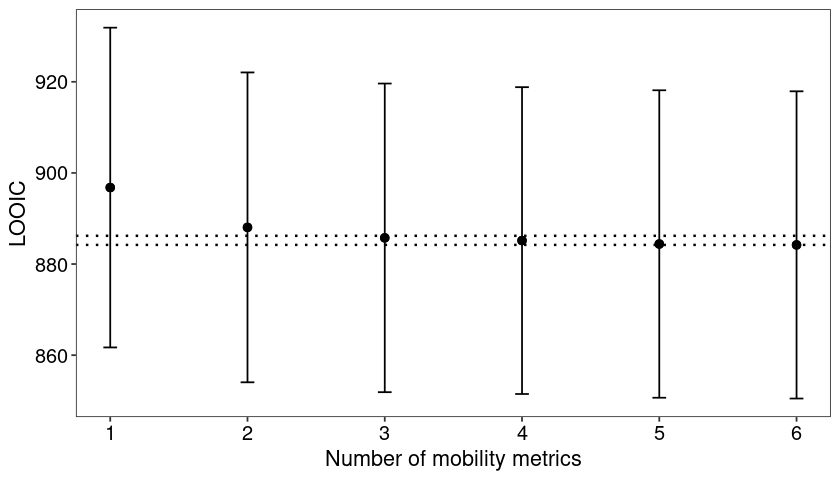

In [103]:
cs = c(7, 4)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

df_loo_mobility_changepoint |>
    ggplot(aes(x=Ps)) +
        geom_point(aes(y=loo_mod_Rt), size=2, color="black") +
        geom_point(aes(y=loo_mod_Rt), size=2, color="black") +
        geom_errorbar(aes(ymin = loo_mod_Rt - loo_se_mod_Rt, 
                        ymax = loo_mod_Rt + loo_se_mod_Rt), color="black", position=position_dodge(.9), width=.1) + 
        geom_hline(yintercept=min(df_loo_mobility_changepoint$loo_mod_Rt), linetype="dotted", color = "black", size = 0.7) + 
        geom_hline(yintercept=min(df_loo_mobility_changepoint$loo_mod_Rt)+2, linetype="dotted", color = "black", size = 0.7) + 
       
        coord_cartesian(xlim=c(1,6)) +
        scale_x_continuous(name="Number of mobility metrics",breaks=1:6) +
        scale_y_continuous(name="LOOIC") +
        theme_bw() + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/loocv_with_changepoint.",filetype_))
}

In [104]:
df_loo_mobility

Ps pseudobma   stacking     pareto_k  loo_mod_Rt loo_se_mod_Rt
model1 1  0.002628783 3.919993e-07 0.2623962 915.9369   34.03340     
model2 2  0.052525696 1.964866e-06 0.4783694 904.3805   32.46555     
model3 3  0.091671120 4.763822e-06 0.5121705 902.5498   32.24658     
model4 4  0.174202583 7.382955e-06 0.5213243 901.0614   32.19559     
model5 5  0.302940656 5.212757e-02 0.3687631 899.9690   32.11764     
model6 6  0.376031162 9.478579e-01 0.5080860 899.5626   32.12929

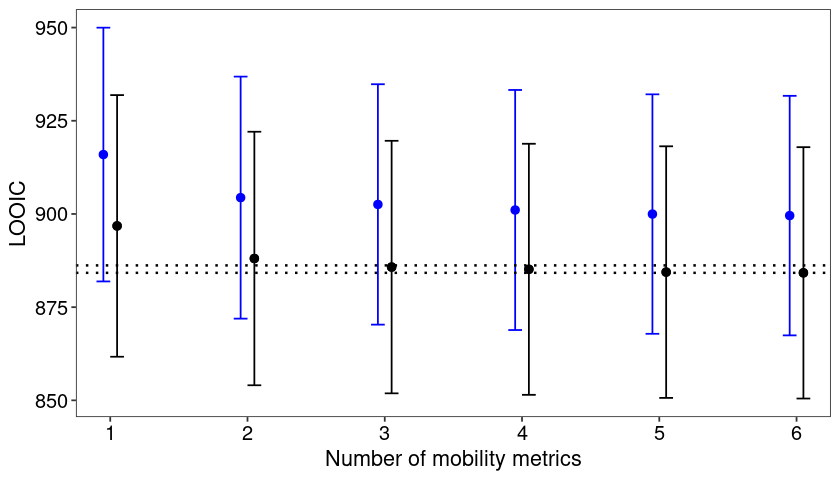

In [105]:
cs = c(7, 4)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

df_loo_mobility |>
    ggplot(aes(x=Ps-.05)) +
        geom_point(aes(y=loo_mod_Rt), size=2, color="blue") +
        geom_errorbar(aes(ymin = loo_mod_Rt - loo_se_mod_Rt, ymax = loo_mod_Rt + loo_se_mod_Rt), color="blue", position=position_dodge(.9), width=.1) + 
        #geom_hline(yintercept=min(df_out$loo_mod_Rt), linetype="dotted", color = "blue", size = 0.7) + 
        #geom_hline(yintercept=min(df_out$loo_mod_Rt)+2, linetype="dotted", color = "blue", size = 0.7) + 
        
        geom_point(data=df_loo_mobility_changepoint, aes(x=Ps+.05, y=loo_mod_Rt), size=2, color="black") +
        geom_point(data=df_loo_mobility_changepoint, aes(x=Ps+.05, y=loo_mod_Rt), size=2, color="black") +
        geom_errorbar(data=df_loo_mobility_changepoint, aes(x=Ps+.05, ymin = loo_mod_Rt - loo_se_mod_Rt, 
                        ymax = loo_mod_Rt + loo_se_mod_Rt), color="black", position=position_dodge(.9), width=.1) + 
        geom_hline(yintercept=min(df_loo_mobility_changepoint$loo_mod_Rt), linetype="dotted", color = "black", size = 0.7) + 
        geom_hline(yintercept=min(df_loo_mobility_changepoint$loo_mod_Rt)+2, linetype="dotted", color = "black", size = 0.7) + 
       

        coord_cartesian(xlim=c(1,6)) +
        scale_x_continuous(name="Number of mobility metrics",breaks=1:6) +
        scale_y_continuous(name="LOOIC") +
        theme_bw() + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/loocv_combined_all.",filetype_))
}

# Different scenarios

## Approximative solution

In [106]:
as.Date("2021-07-01") - mindate

Time difference of 92 days

In [107]:
as.Date("2021-05-12") - mindate

Time difference of 42 days

In [108]:
(t_ref_intervention = as.numeric(as.Date("2021-05-15") - mindate))

[1] 45

In [109]:
log(mod_Rt_mixture_changepoint$draws("tswitch")) %>% summary

variable mean     median   sd         mad        q5       q95      rhat   
1 tswitch  4.673193 4.703625 0.08677743 0.07290146 4.525909 4.774221 1.00672
  ess_bulk ess_tail
1 373.1456 948.779

In [110]:
log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws("R0"), 0.25)))

[1] 1.075679

In [111]:
options(warn=-1)
vars = c("R0", "xi", "eta", "nu")
for (var_ in vars) {
    print(var_)
    var_str_ = paste0("log_",var_)
    a_s_log_var_median = log(median(mod_Rt_mixture_changepoint$draws(var_)))
    assign(paste0("log_",var_,"_median"), a_s_log_var_median)
    assign(paste0("log_",var_,"_IQR"), log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75))) - 
                                log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25))))
    a_s_log_var_pars = GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25))), 
              median = a_s_log_var_median, 
              upper_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75))),
              other_quantile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.01))), alpha = 0.01)
    options(warn=0)
    assign(paste0("log_",var_,"_asymmetry"), a_s_log_var_pars[['asymmetry']])
    assign(paste0("log_",var_,"_steepness"), a_s_log_var_pars[['steepness']])
}

[1] "R0"
[1] "xi"


Warning message in GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded lower tail at -0.68879300791082”
Warning message in GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at 0.384057354921475”


[1] "eta"
[1] "nu"


Warning message in GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at 2.99897455231521”


In [112]:
log_weight_median = c()
log_weight_IQR = c()
log_weight_asymmetry = c()
log_weight_steepness = c()
options(warn=-1)
for (ind_ in 1:(choose(6, n_Ps_)*4)) {
    var_ = paste0("weight[",ind_,"]")
    print(var_)
    log_median_ = log(median(mod_Rt_mixture_changepoint$draws(var_)))
    log_weight_median = c(log_weight_median, log_median_)
    log_weight_IQR = c(log_weight_IQR, log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75))) - 
                                log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25))))
    log_var_pars = GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25))), 
              median = log_median_, 
              upper_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75))),
              other_quantile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.01))), alpha = 0.01)
    options(warn=0)
    log_weight_asymmetry = c(log_weight_asymmetry, log_var_pars[['asymmetry']])
    log_weight_steepness = c(log_weight_steepness, log_var_pars[['steepness']])
}
log_weight_median
log_weight_IQR
log_weight_asymmetry
log_weight_steepness

[1] "weight[1]"
[1] "weight[2]"


Warning message in GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at -0.0801686737702016”


[1] "weight[3]"


Warning message in GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded lower tail at -3408.83374707749”
Warning message in GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at -0.516126029884223”


[1] "weight[4]"


Warning message in GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at -0.412198811739006”


[1] -1.062585 -1.855188 -1.624298 -1.868183

[1] 0.9581878 1.4130232 1.4851379 1.4316217

[1] -0.6467297 -0.4676367 -0.7072739 -0.5528856

[1] 0.2459547 0.3498425 0.1462667 0.2921526

In [113]:
beta_median = c()
beta_IQR = c()
beta_asymmetry = c()
beta_steepness = c()
options(warn=-1)
for (ind_ in 1:n_Ps_) {
    var_ = paste0("beta[",ind_,"]")
    print(var_)
    median_ = median(mod_Rt_mixture_changepoint$draws(var_))
    beta_median = c(beta_median, log_median_)
    beta_IQR = c(beta_IQR, as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75)) - 
                                as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25)))
    var_pars = GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25)), 
              median = median_, 
              upper_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75)),
              other_quantile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.10)), alpha = 0.10)
    options(warn=0)
    beta_asymmetry = c(beta_asymmetry, var_pars[['asymmetry']])
    beta_steepness = c(beta_steepness, var_pars[['steepness']])
}
beta_median
beta_IQR
beta_asymmetry
beta_steepness

[1] "beta[1]"
[1] "beta[2]"


Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded lower tail at -3.34103558193985”
Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at 1.13041411576979”


[1] "beta[3]"


Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded lower tail at -2.66780057266382”
Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at 1.58659248061078”


[1] "beta[4]"


Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded lower tail at -3.66946118325843”
Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at 1.68418384071123”


[1] "beta[5]"


Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded lower tail at -10.8738415561025”
Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at 2.78763291786834”


[1] "beta[6]"


Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded lower tail at -7.38240524356228”
Warning message in GLD_solver(lower_quartile = as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), :
“solution implies a bounded upper tail at 73.280016445368”


[1] -1.868183 -1.868183 -1.868183 -1.868183 -1.868183 -1.868183

[1] 1.1709099 0.7791628 0.9689425 1.0155487 0.9953025 1.3171827

[1] -0.13144942  0.01308459 -0.07788257 -0.01601850 -0.06091416  0.06568380

[1] 0.1684641 0.3264129 0.2671420 0.3104550 0.4187861 0.4586520

In [114]:
log_phi_median = c()
log_phi_IQR = c()
log_phi_asymmetry = c()
log_phi_steepness = c()
options(warn=-1)
for (ind_ in 1:3) {
    var_ = paste0("phi[",ind_,"]")
    print(var_)
    log_median_ = log(median(mod_Rt_mixture_changepoint$draws(var_)))
    log_phi_median = c(log_phi_median, log_median_)
    log_phi_IQR = c(log_phi_IQR, log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75))) - 
                                log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25))))
    log_var_pars = GLD_solver(lower_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.25))), 
              median = log_median_, 
              upper_quartile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.75))),
              other_quantile = log(as.numeric(quantile(mod_Rt_mixture_changepoint$draws(var_), 0.01))), alpha = 0.01)
    options(warn=0)
    log_phi_asymmetry = c(log_phi_asymmetry, log_var_pars[['asymmetry']])
    log_phi_steepness = c(log_phi_steepness, log_var_pars[['steepness']])
}
log_phi_median
log_phi_IQR
log_phi_asymmetry
log_phi_steepness

[1] "phi[1]"
[1] "phi[2]"
[1] "phi[3]"


[1] 3.429304 1.607074 1.388541

[1] 0.4073254 1.7563376 1.2947245

[1] -0.30374341  0.02428592  0.66465721

[1] 0.8809453 0.6116696 0.9373032

In [115]:
(tswitch_ = median(mod_Rt_mixture_changepoint$draws("tswitch")))

[1] 110.3465

In [116]:
stan_code_Rt = 'functions {
    '%&%qfunctions_txt%&%'

    /* discretized version of gamma distribution  */
    vector pgamma(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(gamma_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of lognormal distribution  */
    vector plognormal(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of Weibull distribution */
    vector pweibull(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(weibull_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    // see for details "Modeling control measures" https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html
    // nu is the decrease in transmission while control measures are fully in place
    // xi is the slope of the decrease
    // nu is the delay (after the date of introduction of control measures) until the measures are 50% effective
    real switch_eta(real t, real t1, real eta, real nu, real xi) {
        return eta + (1 - eta) / (1 + exp(xi * (t - t1 - nu)));
    }
}

data {
    int<lower = 1> K; // truncation date
    array[K] int<lower = 0> cases_onset, // number of cases with symptoms onset on given days 1...K
                            cases_unobs; // number of cases with unknown symptoms onset on given days of confirmation 1..K

    int Kmin, Kmax; // time frame for inference of Rt
    int tswitch_min;

    // infectiousness profile (modeled by shifted gamma distribution)
    real<lower = 0> shift_lambda; 
    int<lower = 0> X; //floor of the shift
    real<lower = 0> param1_lambda, param2_lambda;

    // incubation period 
    real param1_IP, param2_IP; 

    // generation time
    real<lower = 0> mean_GT, param1_GT; 

    // delay
    array[K] real log_mean_delay_onset_median, log_mean_delay_onset_IQR, log_mean_delay_onset_asymmetry, log_mean_delay_onset_steepness,
                  log_mean_delay_confirm_median, log_mean_delay_confirm_IQR, log_mean_delay_confirm_asymmetry, log_mean_delay_confirm_steepness;
    real log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness,
         log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness;

    int<lower = 1> M; // total number of mobility metrics or their principal components
    matrix[K, M] y; // mobility

    int<lower = 1> C; // total number of combinations of mobility metrics
    int<lower = 1> N; // number of used mobility metrics
    array[C, N] int mobility_indexes; // particular sets of mobility metrics

    int<lower = 1> n_llk_types; // = 4
    int<lower = 1> Pi; // Pi = n_llk_types * C;

    // informative priors for parameters obtained in previous simulations
    real log_R0_median, log_R0_IQR, log_R0_asymmetry, log_R0_steepness,
        log_xi_median, log_xi_IQR, log_xi_asymmetry, log_xi_steepness,
        log_eta_median, log_eta_IQR, log_eta_asymmetry, log_eta_steepness,
        log_nu_median, log_nu_IQR, log_nu_asymmetry, log_nu_steepness;
    real tswitch;
    array[M] real beta_median, beta_IQR, beta_asymmetry, beta_steepness;
    array[3] real log_phi_median, log_phi_IQR, log_phi_asymmetry, log_phi_steepness;
    array[Pi] real log_weight_median, log_weight_IQR, log_weight_asymmetry, log_weight_steepness;

    int t_seeding_min, t_seeding_max; 
    int<lower = 1> infections_seeding_max;
}

transformed data {
    // Infectiousness profile (modeled by shifted gamma distribution, He et al NatMed 2020)
    vector[K+X] lambda, lambda_rev;
    {
        vector[K+X] res;
        for (k in 1:K+X)
            res[k] = exp(gamma_lcdf(shift_lambda - X + k | param1_lambda, param2_lambda));
        lambda = append_row(res[1], res[2:K+X]-res[1:K+X-1]);
    }
    lambda_rev = reverse(lambda);

    // Incubation period (modeled by lognormal distribution, Li et al NEJM 2020)
    vector[K] ht = plognormal(param1_IP, param2_IP, K),
              ht_rev = reverse(ht);

//    // Generation time (modeled by gamma distribution, Lau et al JID 2021)
//    real param1_GT = square(mean_GT / sd_GT), 
//         param2_GT = mean_GT / square(sd_GT);
//    vector[K] gt = pgamma(param1_GT, param2_GT, K),
//              gt_rev = reverse(gt);

//    // Generation time (modeled by lognormal distribution, Linton et al medrxiv 2021)
//    real param2_GT = sqrt(log(square(sd_GT / mean_GT) + 1.0)),
//        param1_GT = log(mean_GT) - square(param2_GT) / 2.0;
//    vector[K] gt = plognormal(param1_GT, param2_GT, K),
//              gt_rev = reverse(gt);

    // Generation time (modeled by Weibull distribution, Linton et al medrxiv 2021)
    real param2_GT = mean_GT / tgamma(1 + 1 / param1_GT);
    vector[K] gt = pweibull(param1_GT, param2_GT, K),
              gt_rev = reverse(gt);

    int K_seeding = t_seeding_max - t_seeding_min + 1;
}

parameters {
    vector<lower = 0, upper = 1>[K] p_mean_delay_onset, p_mean_delay_confirm;
    real<lower = 0, upper = 1> p_cv_delay_onset, p_cv_delay_confirm;

    real<lower = 0, upper = 1> p_R0, p_xi, p_eta, p_nu;
    vector<lower = 0, upper = 1>[M] p_beta;
    vector<lower = 0, upper = 1>[3] p_phi;
    vector<lower = 0, upper = 1>[Pi] p_log_weight;
}

transformed parameters {
    row_vector<lower = 0>[K] mean_delay_onset, mean_delay_confirm;
    real<lower = 0> cv_delay_onset, cv_delay_confirm;
    for (k in 1:K) {
        mean_delay_onset[k] = exp(GLD_icdf(p_mean_delay_onset[k], log_mean_delay_onset_median[k], log_mean_delay_onset_IQR[k], log_mean_delay_onset_asymmetry[k], log_mean_delay_onset_steepness[k]));
        mean_delay_confirm[k] = exp(GLD_icdf(p_mean_delay_confirm[k], log_mean_delay_confirm_median[k], log_mean_delay_confirm_IQR[k], log_mean_delay_confirm_asymmetry[k], log_mean_delay_confirm_steepness[k]));
    }
    cv_delay_onset = exp(GLD_icdf(p_cv_delay_onset, log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness));
    cv_delay_confirm = exp(GLD_icdf(p_cv_delay_confirm, log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness));

    // Rt
    real<lower = 0> R0 = exp(GLD_icdf(p_R0, log_R0_median, log_R0_IQR, log_R0_asymmetry, log_R0_steepness)),
        xi = exp(GLD_icdf(p_xi, log_xi_median, log_xi_IQR, log_xi_asymmetry, log_xi_steepness)),
        eta = exp(GLD_icdf(p_eta, log_eta_median, log_eta_IQR, log_eta_asymmetry, log_eta_steepness)),
        nu = exp(GLD_icdf(p_nu, log_nu_median, log_nu_IQR, log_nu_asymmetry, log_nu_steepness));
    vector[M] beta;
    for (k in 1:M)
        beta[k] = GLD_icdf(p_beta[k], beta_median[k], beta_IQR[k], beta_asymmetry[k], beta_steepness[k]);

    // likelihoods
    vector[Pi] log_weight;
    for (k in 1:Pi)
        log_weight[k] = GLD_icdf(p_log_weight[k], log_weight_median[k], log_weight_IQR[k], log_weight_asymmetry[k], log_weight_steepness[k]);
    vector<lower = 0>[3] phi;
    for (k in 1:3)
        phi[k] = exp(GLD_icdf(p_phi[k], log_phi_median[k], log_phi_IQR[k], log_phi_asymmetry[k], log_phi_steepness[k]));

    // Lognormal distribution is used for reporting delay as it was selected previously
    real param2_delay_onset = sqrt(log(square(cv_delay_onset) + 1.0)),
         param2_delay_confirm = sqrt(log(square(cv_delay_confirm) + 1.0));
    row_vector[K] param1_delay_onset = log(mean_delay_onset) - square(param2_delay_onset) / 2.0,
                  param1_delay_confirm = log(mean_delay_confirm) - square(param2_delay_confirm) / 2.0;

    vector[Pi] lps = log_weight;
    {
        vector[K] cases_backproj = to_vector(cases_onset);
        // (1) backprojection of cases with unknown dates of symptom onset 
        //// in this case we use the delay by date of confirmation
        array[K] vector[K] delay_by_confirm;
        for (day in 1:K)
            delay_by_confirm[day] = plognormal(param1_delay_confirm[day], param2_delay_confirm, K);
        //// adding to the case count
        for (day in 1:K-1)
            for (k in (day+1):K)
                cases_backproj[day] += cases_unobs[k] * delay_by_confirm[k, k - day];
        // (2) nowcasting of all cases
        //// in this case we use the delay by date of symptoms onset
        vector[K] cases_predicted;
        for (day in 1:K)
            cases_predicted[day] = cases_backproj[day] / exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));

        vector[K + X] cases_predicted_ext = append_row(cases_predicted, rep_vector(0, X));

        vector[K] forcing_function;
        for (t in 1:K) 
            forcing_function[t] = switch_eta(t, tswitch, eta, nu, xi);

        for (idx in 1:Pi) {
            int llk_type = (idx - 1) % n_llk_types + 1;
            int c = (idx - 1) %/% n_llk_types + 1;

            vector[K] Rt;
            if (N<M) {
                array[N] int mobility_metrics = mobility_indexes[c, 1:N];
                Rt = R0 * forcing_function .* exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
            } else
                Rt = R0 * forcing_function .* exp(-y * beta); 

            vector[Kmax-1] infections_expected; // infections per day
            for (day in 1:Kmax-1) 
                infections_expected[day] = Rt[day] * dot_product(head(cases_predicted_ext, day + X), tail(lambda_rev, day + X));

            real r_infection, a_infection;
            for (day in Kmin:Kmax) if (cases_predicted_ext[day] > 0) {
                real mu_infection = (day == 2) ? infections_expected[1] * ht_rev[1] : dot_product(head(infections_expected, day-1), tail(ht_rev, day-1));
                if (llk_type==1)
                    r_infection = phi[1] / (phi[1] + mu_infection);
                else if (llk_type==2)
                    r_infection = phi[2] / (phi[2] + 1.0);
                else if (llk_type==3)
                    r_infection = phi[3] / (phi[3] + sqrt(mu_infection));
                else if (llk_type==4)
                    r_infection = 1.0;
                a_infection = mu_infection * r_infection;
                lps[idx] += gamma_lpdf(cases_predicted_ext[day] | a_infection, r_infection);
            }
        }
    }
}

model {
    /* priors */
    p_mean_delay_onset ~ beta(1, 1);
    p_mean_delay_confirm ~ beta(1, 1);
    p_cv_delay_onset ~ beta(1, 1);
    p_cv_delay_confirm ~ beta(1, 1);

    p_R0 ~ beta(1, 1);
    p_xi ~ beta(1, 1);
    p_eta ~ beta(1, 1);
    p_nu ~ beta(1, 1);
    p_phi ~ beta(1, 1);

    p_beta ~ beta(1, 1);
    p_log_weight ~ beta(1, 1);

    /* likelihood */
    target += log_sum_exp(lps);
}

generated quantities {  
    array[K-1] int cases_predicted; 
    array[infections_seeding_max, K_seeding, K] int cases_baseline;
    for (infections_seeding in 1:infections_seeding_max) 
        for (k_seeding in 1:K_seeding)
            cases_baseline[infections_seeding, k_seeding] = rep_array(0, K); 
    vector<lower = 0>[K] Rt;

    matrix<lower = 0, upper = 1>[C, n_llk_types] q;
    int<lower = 1> index_c, index_llk_type; 
    array[N] vector[K] q_c; // contribution of different metrics
    {
        array[K-1] int cases_backprj = rep_array(0, K-1), 
                   cases_unreported = rep_array(0, K-1);
        for (day in 2:K) if (cases_unobs[day] > 0) {
            vector[day-1] delay_by_confirm = plognormal(param1_delay_confirm[day], param2_delay_confirm, day-1);
            vector[day-1] probs = reverse(delay_by_confirm) ./ sum(delay_by_confirm);
            array[day-1] int counts = multinomial_rng(probs, cases_unobs[day]);
            for (i in 1:day-1) 
                cases_backprj[i] += counts[i];
        }
        for (day in 1:K-1) {
            int cases = cases_onset[day] + cases_backprj[day];
            real F = exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));
            cases_unreported[day] = (cases > 0) ? neg_binomial_2_rng(cases * (1 - F) / F + 1e-8, cases) : 0;
            cases_predicted[day] = cases + cases_unreported[day];
        }

        vector[Pi] q_ = softmax(lps); //the same as exp(lps - log_sum_exp(lps));
        int n_selected = categorical_rng(q_);
        int c, llk_type;
        for (idx in 1:Pi) {
            llk_type = (idx - 1) % n_llk_types + 1;
            c = (idx - 1) %/% n_llk_types + 1;
            q[c, llk_type] = q_[idx];
        }
        index_llk_type = (n_selected - 1) % n_llk_types + 1;
        index_c = (n_selected - 1) %/% n_llk_types + 1;

        vector[K] forcing_function;
        for (t in 1:K) 
            forcing_function[t] = switch_eta(t, tswitch, eta, nu, xi);
        if (N<M) {
            array[N] int mobility_metrics = mobility_indexes[index_c, 1:N];
            Rt = R0 * forcing_function .* exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
        } else
            Rt = R0 * forcing_function .* exp(-y * beta); 

        for(infections_seeding in 1:infections_seeding_max) for (k_seeding in 1:K_seeding) {
            array[K] int infections_baseline = rep_array(0, K); // infections per day
            int t_seeding = k_seeding + t_seeding_min - 1;
            for (day in t_seeding:K) if (day >= t_seeding) {
                if (day == t_seeding)
                    infections_baseline[day] = infections_seeding;
                else {
                    real foi = Rt[day] * dot_product(head(to_vector(infections_baseline), day-1), tail(gt_rev, day-1));
                    infections_baseline[day] = poisson_rng(foi + 1e-8);
                }
                if (infections_baseline[day]>0) {
                    vector[K-day+1] probs = append_row(head(ht, K-day), 1.0 - sum(head(ht, K-day)));
                    array[K-day+1] int counts = multinomial_rng(probs, infections_baseline[day]);
                    for (i in 1:K-day) 
                        cases_baseline[infections_seeding, k_seeding, day+i] += counts[i];
                }
            }
        }
    }
}'

Kmin = df_cases_pca |> filter(d=='2021-04-15') %>% .$t
Kmax = df_cases_pca |> filter(d==truncation_date-14) %>% .$t
c(Kmin, Kmax)

t_seeding_min = Kmin - 10
t_seeding_max = Kmin + 10
infections_seeding_max = 10

foo = \(x, phi) {
    f = \(rate) { pgamma(x, rate*x + 1, rate) - phi }
    return(uniroot(f, lower = 1, upper = 100)$root) }

(param2_lambda = foo(12.3, 0.44))
(param1_lambda = param2_lambda*12.3 + 1)   

foo_Rt = \() {
    M = 6
    N = n_Ps_
    
    standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_scenario_baseline_infections_seeding"
    df_cases_pca |> select(starts_with("x")) |> as.matrix() -> mat
    C = choose(M, N)
    mobility_indexes = combn(M, N) |> t()
        
    #unlink(standirname, recursive=T)
    dir.create(standirname)
    
    file.copy("quantile_functions.stan", standirname)
    
    stan_code_Rt %>% cat(file=standirname %&% "/model_Rt.stan", sep="", fill=TRUE)  
    
    foo = \(mu, sigma) {
        f = \(k) { sigma^2 / mu^2 -  gamma(1+2/k) / (gamma(1+1/k)^2) + 1 }
        return(uniroot(f, lower = .1, upper = 100)$root) }
    mean_GT = 4.38; sd_GT = 2.1
    (param1_GT = foo(mean_GT, sd_GT))
    
    ## @data ##
    K = truncation_day
    cases_onset = df_cases_pca$n
    cases_unobs = df_cases_pca$n_unobs
    y = structure(mat, .Dim = c(K, M))
    tswitch_min = 92
    # infectiousness profile
    shift_lambda = 12.3
    X = 13
    param1_lambda = param1_lambda
    param2_lambda = param2_lambda
    # incubation period
    param1_IP = 1.434065
    param2_IP = 0.6612
    # generation time interval
    #mean_GT = 5.7; sd_GT = 1.7 #(Lau et al IJID)
    #mean_GT = 4.38; sd_GT = 2.1 #(Linton et al medrxiv)
    #mean_GT = 4.51; sd_GT = 3.39 #(Ganyani et al Eurosurv 2020)
    # from previous simulation
    tswitch = tswitch_
    # mixture model
    Pi = C*4
    n_llk_types = 4
    rstan::stan_rdump(c("K", "cases_onset", "cases_unobs", "y", "Kmin", "Kmax", "tswitch_min", 
                        "t_seeding_min", "t_seeding_max", "infections_seeding_max",
                        "mobility_indexes", "C", "N", "M", "n_llk_types", "Pi",
                        "shift_lambda", "X", "param1_lambda", "param2_lambda", 
                        "param1_IP", "param2_IP", "mean_GT", "sd_GT", "param1_GT",
                        #Rt and likelihood from previous simulations
                        "log_R0_median", "log_R0_IQR", "log_R0_asymmetry", "log_R0_steepness",
                        "log_eta_median", "log_eta_IQR", "log_eta_asymmetry", "log_eta_steepness",
                        "log_xi_median", "log_xi_IQR", "log_xi_asymmetry", "log_xi_steepness",
                        "log_nu_median", "log_nu_IQR", "log_nu_asymmetry", "log_nu_steepness",
                        "tswitch",
                        "beta_median", "beta_IQR", "beta_asymmetry", "beta_steepness",
                        "log_phi_median", "log_phi_IQR", "log_phi_asymmetry", "log_phi_steepness",
                        "log_weight_median", "log_weight_IQR", "log_weight_asymmetry", "log_weight_steepness",
                        #delay distribution from previous simulations
                        "log_mean_delay_onset_median", "log_mean_delay_onset_IQR", "log_mean_delay_onset_asymmetry", "log_mean_delay_onset_steepness",
                        "log_cv_delay_onset_median", "log_cv_delay_onset_IQR", "log_cv_delay_onset_asymmetry", "log_cv_delay_onset_steepness", 
                        "log_mean_delay_confirm_median", "log_mean_delay_confirm_IQR", "log_mean_delay_confirm_asymmetry", "log_mean_delay_confirm_steepness",
                        "log_cv_delay_confirm_median", "log_cv_delay_confirm_IQR", "log_cv_delay_confirm_asymmetry", "log_cv_delay_confirm_steepness"), 
                      file=standirname%&%"/Data.R")
    
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)
    
    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model_Rt
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..8}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model_Rt \\
            method=sample num_samples=1250 num_warmup=2500 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

[1]  15 133

[1] 1.576576

[1] 20.39189

In [117]:
recalc_Rt = F
if (recalc_Rt) foo_Rt(); 

In [118]:
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_scenario_baseline_infections_seeding"
output_files = c(); idx = 1
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
    print(fl_)
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_Rt_mixture_changepoint_prj = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-1.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-2.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-3.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-4.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-5.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-6.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-7.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_baseline_infections_seeding/trace-8.csv"



This may indicate insufficient exploration of the posterior distribution.
Possible remedies include: 
  * Increasing adapt_delta closer to 1 (default is 0.8) 
  * Reparameterizing the model (e.g. using a non-centered parameterization)
  * Using informative or weakly informative prior distributions 




In [119]:
output_ = mod_Rt_mixture_changepoint_prj$summary(c("cases_baseline"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) |> as.data.frame() |>
    separate(variable, c("variable", "infections_seeding", "k_seeding", "index"), sep = "([\\[,\\]])", extra = "drop") |>
    select(-variable) 
rownames(output_) = NULL
output_ %>%
    mutate(index = as.numeric(index), k_seeding = as.numeric(k_seeding), Onset = mindate + index, date_seeding = t_seeding_min + k_seeding - 1 + mindate) |>
    rename(median = `50%`, lower = `2.5%`, upper = `97.5%`, IQR_lower = `25%`, IQR_upper = `75%`) %>%
    select(infections_seeding, date_seeding, Onset, median, lower, upper, IQR_lower, IQR_upper, k_seeding, index) |>
    mutate(infections_seeding = as.numeric(infections_seeding)) -> output_cases_baseline_projected
(k_seedings = unique(output_cases_baseline_projected$k_seeding))
(infections_seedings = unique(output_cases_baseline_projected$infections_seeding))
(ts = unique(output_cases_baseline_projected$index))
#output_cases_baseline_projected = output_cases_baseline_projected |> select(-k_seeding, -index)
output_cases_baseline_projected |> head(10)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21

[1]  1  2  3  4  5  6  7  8  9 10

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
[127] 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
[145] 145 146 147

infections_seeding date_seeding Onset      median lower upper IQR_lower
1   1                 2021-04-05   2021-04-01 0      0     0     0        
2   2                 2021-04-05   2021-04-01 0      0     0     0        
3   3                 2021-04-05   2021-04-01 0      0     0     0        
4   4                 2021-04-05   2021-04-01 0      0     0     0        
5   5                 2021-04-05   2021-04-01 0      0     0     0        
6   6                 2021-04-05   2021-04-01 0      0     0     0        
7   7                 2021-04-05   2021-04-01 0      0     0     0        
8   8                 2021-04-05   2021-04-01 0      0     0     0        
9   9                 2021-04-05   2021-04-01 0      0     0     0        
10 10                 2021-04-05   2021-04-01 0      0     0     0        
   IQR_upper k_seeding index
1  0         1         1    
2  0         1         1    
3  0         1         1    
4  0         1         1    
5  0         1         1    
6  0         1         1    
7  0         1         1    
8  0         1         1    
9  0         1         1    
10 0         1         1

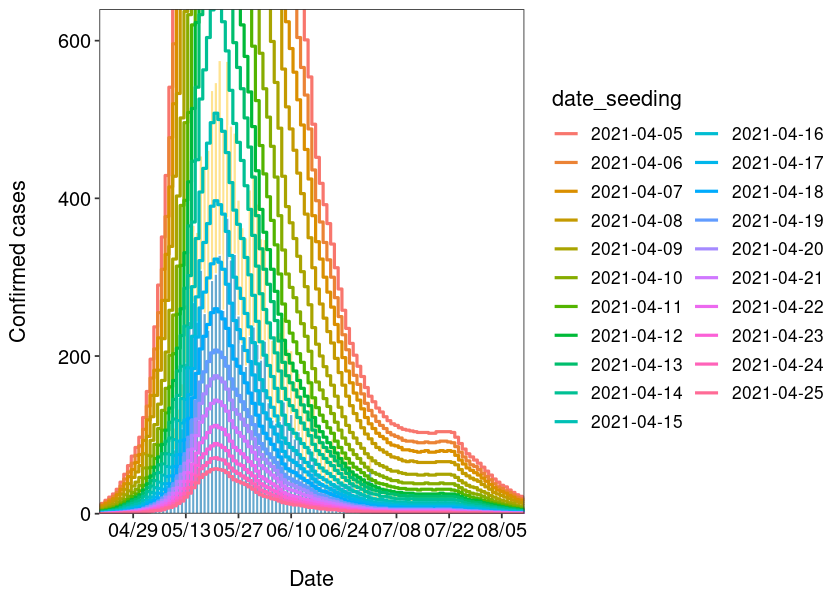

In [125]:
cs = c(7, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

output_cases_baseline_projected |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_cases_baseline_projected_
output_cases_baseline_projected_ |> tail(1) |> mutate(Onset = Onset + 7) |>
    rbind(output_cases_baseline_projected) |> arrange(Onset) -> output_cases_baseline_projected_

shift_ = -5
shift_right = 2

output_cases_baseline_ |> 
    filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) |>
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=(n+median)), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +

        # RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_baseline_projected_, aes(ymax=IQR_upper, ymin=IQR_lower), fill="darkgrey", alpha = 0.4) +
        # RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_baseline_projected_, aes(ymax=upper, ymin=lower), fill="darkgrey", alpha = 0.1) +
        # geom_step(data = output_cases_baseline_projected_, aes(y=upper), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        # geom_step(data = output_cases_baseline_projected_, aes(y=lower), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        # geom_step(data = output_cases_baseline_projected_, aes(y=IQR_upper), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        # geom_step(data = output_cases_baseline_projected_, aes(y=IQR_lower), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        # geom_step(data = output_cases_baseline_projected_, aes(y=median), color="black", size=.9, alpha=1) +

        geom_step(data = output_cases_baseline_projected_ |> filter(infections_seeding==6) |> 
                  mutate(date_seeding = as.factor(date_seeding)), aes(y=median, color=date_seeding, group=date_seeding), size=.9, alpha=1) +

        labs(x="\nDate", y="Confirmed cases\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

In [126]:
output_cases_baseline_projected_ |> filter(infections_seeding==5, date_seeding=='2021-04-06') %>% .$median

[1]    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0
 [11]    1.0    1.0    2.0    2.0    3.0    3.0    4.0    5.0    6.0    8.0
 [21]   10.0   12.0   15.0   18.0   22.0   29.0   36.0   44.0   53.0   61.0
 [31]   71.0   89.0  113.0  144.0  173.0  212.0  257.0  312.0  393.0  496.0
 [41]  615.0  765.0  973.0 1237.0 1512.5 1831.0 2141.0 2302.0 2463.5 2609.5
 [51] 2661.5 2625.0 2546.0 2394.0 2194.5 2016.0 1914.0 1823.0 1697.0 1575.0
 [61] 1449.5 1279.0 1137.5 1052.0  983.0  909.0  832.5  742.0  650.0  594.0
 [71]  562.0  534.0  499.0  469.0  439.0  403.0  359.5  327.0  306.0  285.0
 [81]  266.0  248.0  227.0  208.0  188.0  172.0  158.0  145.0  136.0  126.0
 [91]  116.0  108.0  102.0   97.0   93.0   89.0   86.0   83.0   81.0   79.0
[101]   77.0   76.0   77.0   76.0   75.0   75.0   76.0   75.0   75.0   76.0
[111]   76.0   76.0   76.0   75.0   71.0   65.0   60.0   56.0   52.0   50.0
[121]   47.0   43.0   39.0   36.0   32.0   29.0   26.0   24.0   22.0   20.0
[131]   17.0   16.0   15.0   14.0   13.0   13.0   12.0   12.0   11.5   11.0
[141]   11.0   11.0   11.0   10.0   11.0   11.0   11.0

In [127]:
df_cases_predicted$median

[1]   1   0   0   0   1   1   0   0   0   0   0   0   0   0   1   1   1   0
 [19]   1   1   0   2   1   1   2   6   2   5   6   5  12   8  10   5  12  28
 [37]  31  49  56 109 133 165 265 332 366 357 454 441 461 537 547 575 488 574
 [55] 492 483 398 363 350 411 431 393 349 348 246 220 226 230 249 209 207 168
 [73] 178 150 132 171 148 111  94  87  85  95  86  79  76  73  61  45  50  45
 [91]  42  75  32  29  23  34  27  31  28  26  21  17  22  14  21  20  17  16
[109]  13  29  18  28  15  18  16  15  15  16  14  10  14  15   9   9   7   9
[127]   5   4   7   7   4   4   4   4   4   4   6   4   2   5   3   2   1   1
[145]   0   0

In [128]:
as_draws_df(mod_Rt_mixture_changepoint_prj$draws("cases_baseline")) |> filter(.chain==1) |>
    select(starts_with("cases_baseline[1,2,")) |> as.matrix() -> mat_
scoringutils::dss(df_cases_predicted$median[Kmin:Kmax], t(mat_)[Kmin:Kmax,])

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


[1] -0.130676317 -0.009993012  0.115648170  1.178913935  0.980882459
  [6]  1.370198278  2.500914685  1.995631681  2.860677097  3.270564544
 [11]  3.437006911  3.657388943  4.581272956  4.661035424  5.053798751
 [16]  5.487324632  5.469444218  6.159602219  6.701752422  7.547002839
 [21]  7.686286209  7.787988215  8.241901031  8.551543571  9.045143370
 [26]  9.395257491  9.878032557 10.325969567 10.859020154 11.361144449
 [31] 11.734620844 12.115265573 12.402559933 12.554896525 12.689858192
 [36] 12.798209398 12.835353700 12.791953016 12.750060586 12.621001864
 [41] 12.424470783 12.268115246 12.157860511 12.074469188 11.934650561
 [46] 11.806275759 11.710565063 11.497882853 11.270161759 11.200756194
 [51] 10.856896043 10.684951502 10.555168384 10.426097331 10.512106363
 [56] 10.165294760 10.134947604  9.795850953  9.839921398  9.558138368
 [61]  9.350609144  9.844468574  9.509973992  8.913046691  8.665580759
 [66]  8.523609568  8.440362074  8.594628773  8.395356731  8.241913595
 [71]  8.176770188  8.137807418  7.735407104  7.227721302  7.336554603
 [76]  7.157538988  7.009818533 10.070144267  6.594680946  6.422886071
 [81]  6.326034475  6.601954667  6.266558853  6.430134905  6.305167922
 [86]  6.210452545  6.021198558  5.992705909  6.053758261  6.000989038
 [91]  5.994969562  5.989970006  6.023048754  5.995083402  6.009310554
 [96]  6.346085614  6.075991446  6.309930389  6.131054463  6.073815053
[101]  6.031520068  5.853433917  5.709321725  5.613945375  5.516942045
[106]  5.402449682  5.340123894  5.265448741  5.071291604  4.873737202
[111]  4.643775552  4.546106651  4.355319698  4.202066708  4.105185469
[116]  3.943270608  3.705856420  3.483207565  3.429570347

In [129]:
#RMSE
get_RMSE = \(infections_seeding, k_seeding) {
    options(warn=-1)
    as_draws_df(mod_Rt_mixture_changepoint_prj$draws("cases_baseline")) |> filter(.chain==1) |>
        select(starts_with(paste0("cases_baseline[",infections_seeding,",",k_seeding,","))) |> as.matrix() -> mat_
    options(warn=0)
    sqrt(scoringutils::mse(df_cases_predicted$median[(Kmin+14):Kmax], t(mat_)[(Kmin+14):Kmax,]) |> sum())
}
get_RMSE(5,3)

[1] 864.1107

In [130]:
k_seedings

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21

In [131]:
ind_ = TRUE
for (k_seeding in k_seedings) {
    message(k_seeding)
    for (infections_seeding in infections_seedings) {
        data.frame(infections_seeding = infections_seeding, k_seeding = k_seeding, rmse=get_RMSE(infections_seeding, k_seeding)) -> df_
        if (ind_) {
            df_rmse = df_
            ind_ = FALSE
        } else 
            df_rmse = rbind(df_rmse, df_)
    }
}

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21



In [132]:
df_rmse |> pivot_wider(names_from = k_seeding, values_from = rmse)

infections_seeding 1         2         3         4         5        
1   1                  247.4268  218.4795  177.3646  160.7773  150.2942
2   2                  474.8206  396.3990  307.7876  217.7703  169.5219
3   3                  684.0758  576.5918  485.4899  382.7786  262.0491
4   4                  976.2216  816.2703  668.9955  499.5624  358.6993
5   5                 1251.3414 1069.0869  864.1107  682.2104  460.7065
6   6                 1498.3739 1237.1890 1081.1993  836.2953  575.3795
7   7                 1711.1984 1491.3141 1271.7801  973.7391  699.2946
8   8                 2019.7842 1702.3500 1466.2446 1159.6064  802.4131
9   9                 2232.9178 1932.7923 1661.4396 1310.7643  932.0991
10 10                 2522.1825 2148.6759 1816.6994 1474.2288 1063.7826
   6        7        8        9        ⋯ 12        13        14        15      
1  155.1433 162.7751 168.3984 174.1244 ⋯ 191.35037 195.44818 199.96412 202.6074
2  132.8660 129.7396 131.1201 138.5922 ⋯ 168.27522 177.53810 184.20333 190.7849
3  177.6147 140.6707 119.6507 112.9018 ⋯ 147.15449 160.12992 169.12038 178.5070
4  260.9080 178.2744 146.5085 111.7927 ⋯ 126.08913 142.87266 155.81458 166.4688
5  318.5022 240.0213 167.8050 136.8985 ⋯ 113.39400 127.53844 140.43798 154.2689
6  420.2516 302.9554 218.2220 174.2140 ⋯  97.96928 111.29296 128.13814 142.1558
7  507.9924 376.2088 280.0346 210.0030 ⋯  95.39061 100.39373 116.45209 131.7764
8  589.5527 447.5466 325.6942 256.3498 ⋯  93.96063  91.45572 103.90257 121.0513
9  691.2306 519.9978 389.4162 312.8285 ⋯ 102.41145  87.57821  95.62711 111.8339
10 787.5325 569.3513 442.8612 349.6958 ⋯ 115.19049  89.74848  88.81799 103.2342
   16       17       18       19       20       21      
1  205.1573 206.5737 208.3527 209.9819 210.7027 211.5559
2  194.0344 197.7565 201.6405 204.6912 206.8799 208.1936
3  184.3881 189.7081 195.5581 199.5185 202.0383 204.7598
4  173.5725 180.6128 188.3589 193.4925 197.9964 201.1351
5  163.2076 172.1428 181.8127 188.4256 193.6354 197.9848
6  153.8761 163.7671 174.9112 183.5265 189.1122 194.8826
7  144.2907 155.9593 168.5644 178.2550 185.0694 190.9295
8  134.1964 148.6595 162.5152 173.3673 180.8835 187.9227
9  125.8792 140.2319 155.3282 168.1390 177.5280 184.2555
10 115.2723 132.4605 148.9130 162.4936 173.2503 180.8088

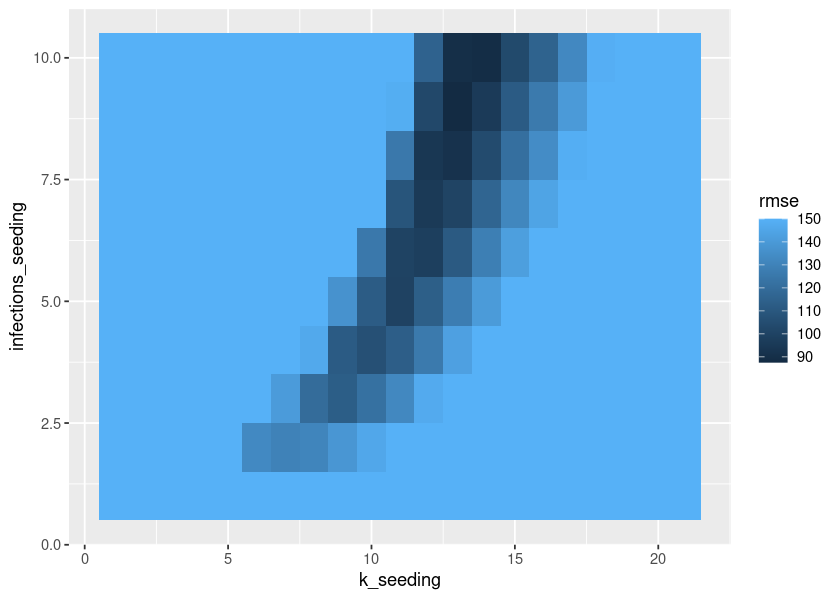

In [133]:
rmse_threshold = 150
df_rmse |>
    mutate(rmse = ifelse(rmse > rmse_threshold, rmse_threshold, rmse)) |>
    ggplot(aes(x = k_seeding, y = infections_seeding, fill=rmse)) +
    geom_tile()

In [142]:
df_rmse |>
    group_by(infections_seeding) |> filter(rmse == min(rmse))

infections_seeding k_seeding rmse     
1   1                  5        150.29417
2   2                  7        129.73965
3   3                  9        112.90182
4   4                 10        106.60241
5   5                 11         99.44385
6   6                 12         97.96928
7   7                 12         95.39061
8   8                 13         91.45572
9   9                 13         87.57821
10 10                 14         88.81799

In [224]:
(df_rmse |> arrange(rmse) |> head(1) -> df_rmse_optimal)
(infections_seeding_rmse_opt = df_rmse_optimal$infections_seeding)
(k_seeding_rmse_opt = df_rmse_optimal$k_seeding)
(rmse_opt = df_rmse_optimal$rmse)

infections_seeding k_seeding rmse    
1 9                  13        87.57821

[1] 9

[1] 13

[1] 87.57821

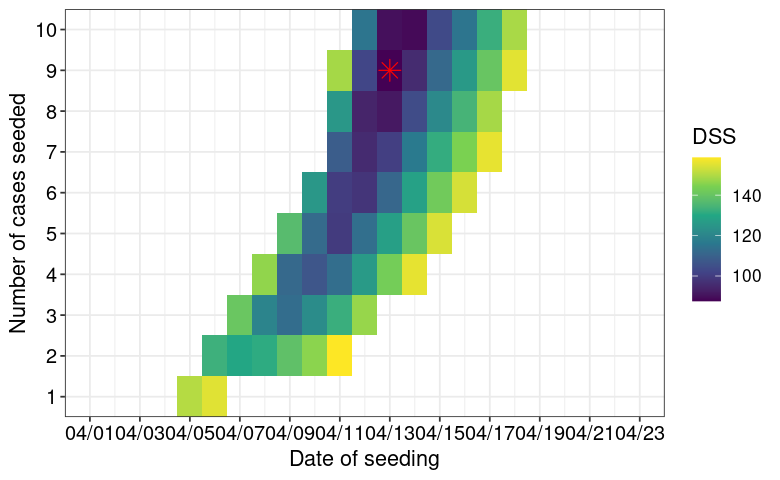

In [225]:
cs = c(6.5, 4)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

rmse_threshold = 160
df_rmse |>
    filter(rmse <= rmse_threshold) |>
    mutate(rmse = ifelse(rmse > rmse_threshold, rmse_threshold, rmse),
           date_seeding = mindate + t_seeding_min + k_seeding - 1) |>
    ggplot(aes(x = date_seeding, y = infections_seeding, fill=rmse)) +
        geom_tile() +
        geom_point(data = data.frame(date_seeding=c(mindate + t_seeding_min + k_seeding_rmse_opt - 1), 
                                     infections_seeding=c(infections_seeding_rmse_opt), rmse=rmse_opt), 
           color='red', size=4, pch=8, show.legend = FALSE) +
        labs(x="Date of seeding", y="Number of cases seeded", fill="DSS") +
        theme_bw() +
        coord_cartesian(expand=0, xlim=c(mindate + t_seeding_min - 1, mindate + t_seeding_max - 1)) +
        scale_x_date(date_labels="%m/%d",date_breaks  = "2 days") +
        scale_y_continuous(breaks = seq(0,10,1)) +
        scale_fill_continuous(type = "viridis") + 
        theme(text = element_text(size=13, family="sans", color="black"),
              panel.grid.minor.y = element_blank(),
            axis.text = element_text(size=12, family="sans", color="black")) -> plt_

plt_

if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/RMSE.",filetype_))
}

In [226]:
(df_rmse |> arrange(rmse) |> filter(infections_seeding==9) |> head(4))

infections_seeding k_seeding rmse     
1 9                  13         87.57821
2 9                  14         95.62711
3 9                  12        102.41145
4 9                  15        111.83393

In [227]:
#DSS
get_DSscore = \(infections_seeding, k_seeding) {
    options(warn=-1)
    as_draws_df(mod_Rt_mixture_changepoint_prj$draws("cases_baseline")) |> filter(.chain==1) |>
        select(starts_with(paste0("cases_baseline[",infections_seeding,",",k_seeding,","))) |> as.matrix() -> mat_
    options(warn=0)
    scoringutils::dss(df_cases_predicted$median[(Kmin+14):Kmax], t(mat_)[(Kmin+14):Kmax,]) |> sum()
}
get_DSscore(5,3)

[1] 1184.961

In [137]:
ind_ = TRUE
for (k_seeding in k_seedings) {
    message(k_seeding)
    for (infections_seeding in infections_seedings) {
        data.frame(infections_seeding = infections_seeding, k_seeding = k_seeding, dss=get_DSscore(infections_seeding, k_seeding)) -> df_
        if (ind_) {
            df_dss = df_
            ind_ = FALSE
        } else 
            df_dss = rbind(df_dss, df_)
    }
}

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21



In [138]:
df_dss |> pivot_wider(names_from = k_seeding, values_from = dss)

infections_seeding 1         2         3         4         5        
1   1                  881.4768  854.3192  826.9191  825.3139  885.8835
2   2                 1003.4592  966.9949  915.9046  851.4648  816.8663
3   3                 1094.2542 1059.3645 1023.0489  964.1268  883.2801
4   4                 1195.2364 1153.0741 1108.8547 1043.8567  955.4920
5   5                 1260.2350 1233.8254 1184.9614 1126.4225 1025.2587
6   6                 1317.3219 1293.4819 1255.8181 1184.7586 1096.6434
7   7                 1370.0820 1335.9266 1314.7960 1250.1845 1151.1819
8   8                 1416.0065 1381.1485 1358.3263 1291.9408 1203.3499
9   9                 1458.4271 1438.5866 1409.6359 1338.7257 1254.8145
10 10                 1501.4355 1480.9029 1439.2823 1376.0374 1296.8323
   6         7         8         9         ⋯ 12        13        14        
1  1074.5149 1200.7500 1695.0533 2133.7488 ⋯ 7194.2191 9850.6201 18097.2936
2   800.6181  836.8486  946.0535 1111.4902 ⋯ 3119.6354 5035.6308  7267.2263
3   824.8539  794.1313  793.6217  836.1124 ⋯ 1718.4703 2604.2443  3930.4542
4   890.5933  821.4123  793.7811  775.2352 ⋯ 1264.1680 1908.1787  2786.0040
5   932.2085  872.3955  813.9573  786.6314 ⋯ 1009.7748 1304.2456  1897.5229
6  1010.2120  926.0839  867.6925  824.4204 ⋯  883.9605 1076.9167  1451.0371
7  1064.2550  987.8987  917.2610  861.8678 ⋯  800.2880  930.3477  1199.7617
8  1119.8649 1036.6839  962.6008  908.1329 ⋯  771.5725  831.7390  1079.1226
9  1157.9351 1083.7414 1017.2886  959.0655 ⋯  764.6219  795.1519   926.4755
10 1216.3042 1127.1173 1062.6757  993.1103 ⋯  774.0418  770.5521   855.5259
   15        16        17        18        19         20         21       
1  25174.910 40790.977 53104.007 74148.194 119439.507 164531.728 228028.37
2  12293.822 16411.028 22459.148 33310.614  55121.809  79636.589 108086.60
3   6542.590 10271.960 15106.984 22341.986  35453.751  43271.472  68517.91
4   4360.830  5802.847  9492.097 14151.632  22789.128  31140.822  46224.59
5   3152.579  4337.255  6832.639 10355.782  16784.250  23780.731  37968.70
6   2433.189  3321.857  4999.848  8251.206  13329.077  19498.841  31189.09
7   1863.906  2513.565  4126.259  6397.055  10066.488  15006.812  23572.24
8   1446.397  2126.850  3172.454  5419.769   8768.964  12650.133  21503.62
9   1255.462  1786.896  2690.663  4374.693   7205.115  11390.188  17256.53
10  1128.464  1477.070  2134.650  3592.235   6139.104   9921.268  14285.11

In [143]:
df_dss |>
    group_by(infections_seeding) |> filter(dss == min(dss))

infections_seeding k_seeding dss     
1   1                  4        825.3139
2   2                  6        800.6181
3   3                  8        793.6217
4   4                  9        775.2352
5   5                 10        773.5938
6   6                 10        776.1446
7   7                 11        765.5340
8   8                 12        771.5725
9   9                 12        764.6219
10 10                 13        770.5521

In [228]:
(df_dss |> arrange(dss) |> head(1) -> df_dss_optimal)
(infections_seeding_dss_opt = df_dss_optimal$infections_seeding)
(k_seeding_dss_opt = df_dss_optimal$k_seeding)
(dss_opt = df_dss_optimal$dss)

infections_seeding k_seeding dss     
1 9                  12        764.6219

[1] 9

[1] 12

[1] 764.6219

In [229]:
(df_dss |> arrange(dss) |> filter(infections_seeding==9) |> head(4))

infections_seeding k_seeding dss     
1 9                  12        764.6219
2 9                  13        795.1519
3 9                  11        803.2914
4 9                  10        888.1815

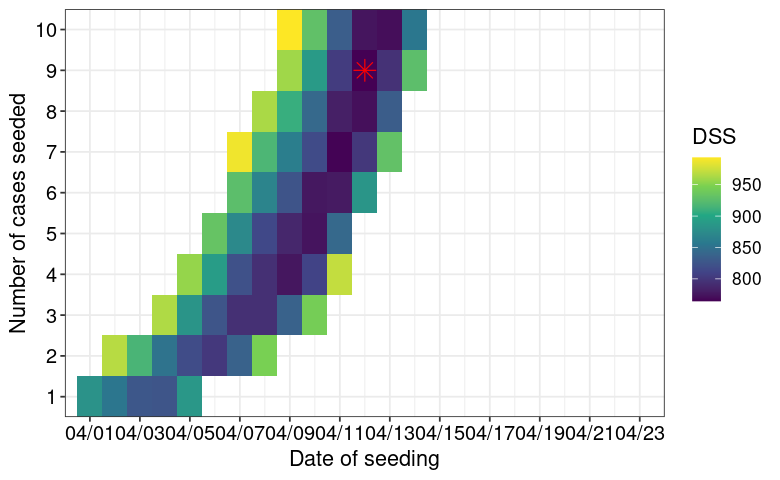

In [230]:
cs = c(6.5, 4)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

dss_threshold = 1000
df_dss |>
    filter(dss <= dss_threshold) |>
    mutate(dss = ifelse(dss > dss_threshold, dss_threshold, dss), 
           date_seeding = mindate + t_seeding_min + k_seeding - 1) |>
    ggplot(aes(x = date_seeding, y = infections_seeding, fill=dss)) +
        geom_tile() +
        geom_point(data = data.frame(date_seeding=c(mindate + t_seeding_min + k_seeding_dss_opt - 1), 
                                     infections_seeding=c(infections_seeding_dss_opt), dss=dss_opt), 
           color='red', size=4, pch=8, show.legend = FALSE) +
        labs(x="Date of seeding", y="Number of cases seeded", fill="DSS") +
        theme_bw() +
        coord_cartesian(expand=0, xlim=c(mindate + t_seeding_min - 1, mindate + t_seeding_max - 1)) +
        scale_x_date(date_labels="%m/%d",date_breaks  = "2 days") +
        scale_y_continuous(breaks = seq(0,10,1)) +
        scale_fill_continuous(type = "viridis") + 
        theme(text = element_text(size=13, family="sans", color="black"),
              panel.grid.minor.y = element_blank(),
            axis.text = element_text(size=12, family="sans", color="black")) -> plt_

plt_

if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/DSS.",filetype_))
}

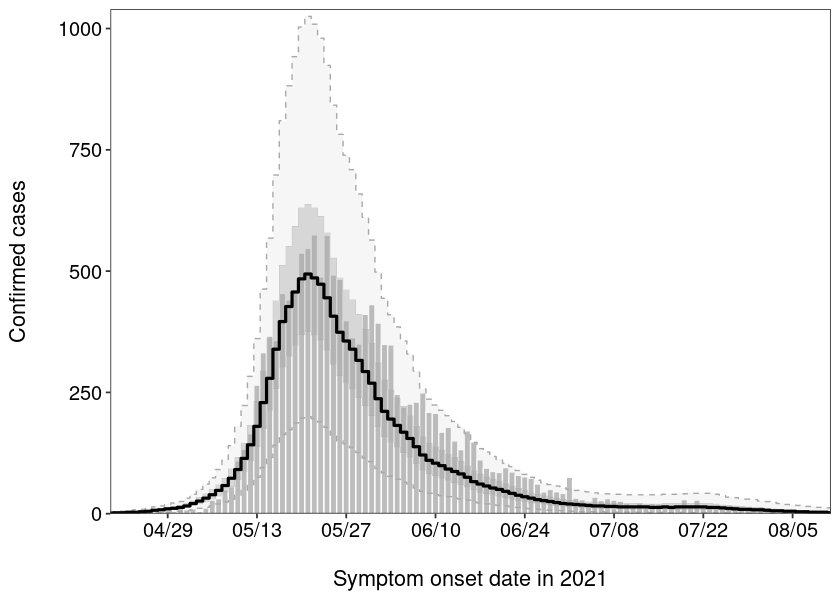

In [231]:
cs = c(7, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

output_cases_baseline_projected |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_cases_baseline_projected_
output_cases_baseline_projected_ |> tail(1) |> mutate(Onset = Onset + 7) |>
    rbind(output_cases_baseline_projected) |> arrange(Onset) -> output_cases_baseline_projected_

output_cases_baseline_projected_ |> filter(infections_seeding==infections_seeding_opt, k_seeding==k_seeding_opt) -> output_cases_baseline_projected_opt

shift_ = -5
shift_right = 2

output_cases_baseline_ |> 
    filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) |>
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=(n+median)), stat='identity', 
                 fill="#bdbdbd", color='white', size=.4, alpha=1, width=1) +

        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_baseline_projected_opt, aes(ymax=IQR_upper, ymin=IQR_lower), fill="darkgrey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_baseline_projected_opt, aes(ymax=upper, ymin=lower), fill="darkgrey", alpha = 0.1) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=upper), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=lower), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=IQR_upper), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=IQR_lower), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=median), color="black", size=.9, alpha=1) +

        #geom_step(data = df_cases_predicted, aes(x=d, y=median), color="red", size=.9, alpha=1) +

        labs(x="\nSymptom onset date in 2021", y="Confirmed cases\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax+400), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) { for (filetype_ in c("png", "pdf"))
    ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
           filename=paste0(figures_dir,"/baseline_model.",filetype_))
}

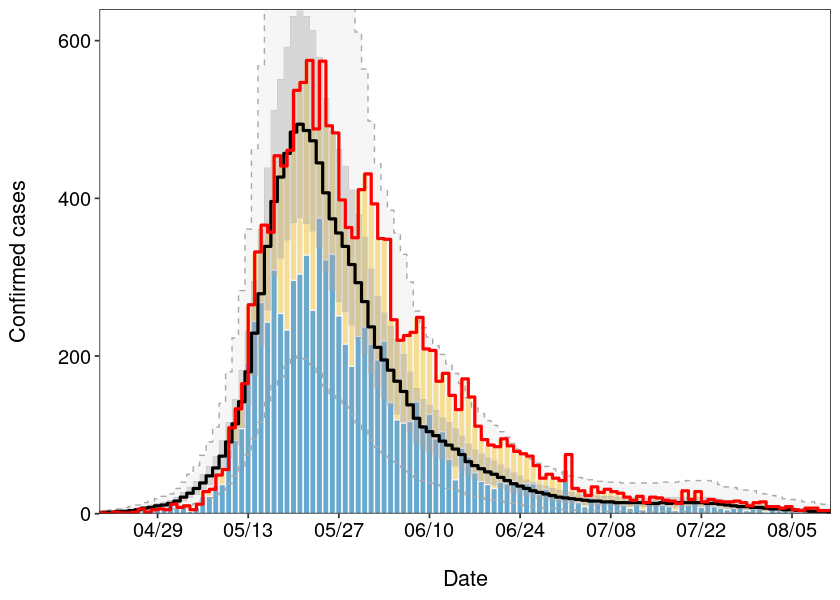

In [232]:
cs = c(7, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

output_cases_baseline_projected |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_cases_baseline_projected_
output_cases_baseline_projected_ |> tail(1) |> mutate(Onset = Onset + 7) |>
    rbind(output_cases_baseline_projected) |> arrange(Onset) -> output_cases_baseline_projected_

output_cases_baseline_projected_ |> filter(infections_seeding==infections_seeding_opt, k_seeding==k_seeding_opt) -> output_cases_baseline_projected_opt

output_cases_baseline_ |> 
    filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) |>
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=(n+median)), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +

        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_baseline_projected_opt, aes(ymax=IQR_upper, ymin=IQR_lower), fill="darkgrey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_baseline_projected_opt, aes(ymax=upper, ymin=lower), fill="darkgrey", alpha = 0.1) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=upper), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=lower), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=IQR_upper), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=IQR_lower), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_baseline_projected_opt, aes(y=median), color="black", size=.9, alpha=1) +

        geom_step(data = df_cases_predicted, aes(x=d, y=median), color="red", size=.9, alpha=1) +

        labs(x="\nDate", y="Confirmed cases\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

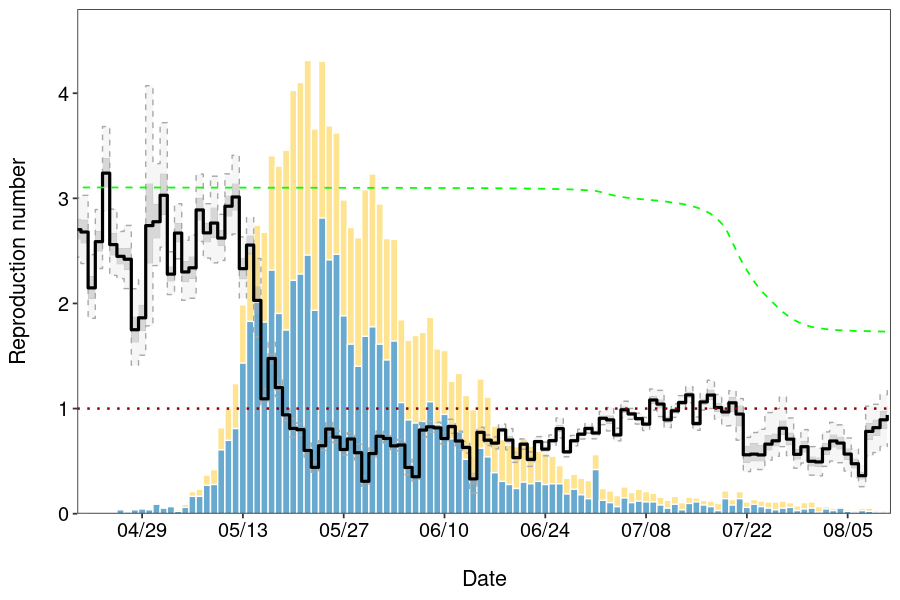

In [233]:
cs = c(7.5, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

mindate_Rt = as.Date("2021-04-20")#min(output_Rt_infection$Onset)#
maxdate_Rt = as.Date("2021-08-11")#truncation_date - 1
maxdate_incidence = maxdate_Rt + 7
                       
clr_[1] = "#88419d"

## Rt by date of infection
output_ = mod_Rt_mixture_changepoint_prj$summary(c("Rt"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) %>% as.data.frame 
output_$variable = rownames(output_)
rownames(output_) = NULL
out = stringr::str_match_all(output_$variable, "[\\d+(.*)]")
output_$index = sapply(out, function(x) as.numeric(paste(x[,1],collapse="")))
output_ %>% 
    mutate(variable = stringr::str_extract(variable, "^[^\\[]+"), Onset = mindate + index) %>%
    rename(Rt = `50%`, Rt_lower = `2.5%`, Rt_upper = `97.5%`, Rt_IQR_lower = `25%`, Rt_IQR_upper = `75%`) %>%
    select(Onset, index, Rt, Rt_lower, Rt_upper, Rt_IQR_lower, Rt_IQR_upper) -> output_Rt_mixture_interventions
                              
output_Rt_infection |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_Rt_infection_
output_Rt_infection_ |> tail(1) |> mutate(Onset = Onset + 7) |> rbind(output_Rt_infection) |> arrange(Onset) -> output_Rt_infection_
                       
output %>% 
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_predicted |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=median*scaling_parameter), stat='identity', fill=clr_[4], alpha=.4, width=.9) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), aes(x=d, y=(n+median)*scaling_parameter), stat='identity', 
                 fill=clr_[3], color='white', size=.4, alpha=1, width=1) +
        geom_bar(data = df_cases, aes(x=d, y=n*scaling_parameter),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +
                       
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt),
                   aes(ymax=Rt_IQR_upper, ymin=Rt_IQR_lower), fill="darkgrey", alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                   aes(ymax=Rt_upper, ymin=Rt_lower), fill="darkgrey", alpha = 0.1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_upper), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_lower), color="darkgrey", linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_upper), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt_IQR_lower), color="darkgrey", linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_Rt_mixture_interventions %>% filter(Onset>=mindate_Rt, Onset<=maxdate_Rt), 
                  aes(y=Rt), color="black", size=.9, alpha=1) +
                  
        geom_line(data = R0_median |> mutate(x = t+mindate), aes(x = x, y = R0), linetype="dashed", color='green') +

        geom_hline(yintercept=1, linetype="dotted", color = "darkred", size = 0.7) + 
        labs(x="\nDate", y="Reproduction number\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax*scaling_parameter), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt
plt

## Checking different scenarios

In [237]:
stan_code_Rt = 'functions {
    '%&%qfunctions_txt%&%'

    /* discretized version of gamma distribution  */
    vector pgamma(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(gamma_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of lognormal distribution  */
    vector plognormal(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(lognormal_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    /* discretized version of Weibull distribution */
    vector pweibull(real param1, real param2, int K) {
        vector[K] res; 
        for (k in 1:K)
            res[k] = exp(weibull_lcdf(k | param1, param2));

        return append_row(res[1], res[2:K]-res[1:(K-1)]);  
    }

    // see for details "Modeling control measures" https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html
    // nu is the decrease in transmission while control measures are fully in place
    // xi is the slope of the decrease
    // nu is the delay (after the date of introduction of control measures) until the measures are 50% effective
    real switch_eta(real t, real t1, real eta, real nu, real xi) {
        return eta + (1 - eta) / (1 + exp(xi * (t - t1 - nu)));
    }
}

data {
    int<lower = 1> K; // truncation date
    array[K] int<lower = 0> cases_onset, // number of cases with symptoms onset on given days 1...K
                            cases_unobs; // number of cases with unknown symptoms onset on given days of confirmation 1..K

    int Kmin, Kmax; // time frame for inference of Rt
    int t_ref_scenario; // starting time when different scenarios are considered
    int scenario_shift_max; // maximum shift in days for scenarios
    int t0;
    int<lower = t0+1> t_level3;

    // infectiousness profile (modeled by shifted gamma distribution)
    real<lower = 0> shift_lambda; 
    int<lower = 0> X; //floor of the shift
    real<lower = 0> param1_lambda, param2_lambda;

    // incubation period 
    real param1_IP, param2_IP; 

    // generation time
    real<lower = 0> mean_GT, param1_GT; 

    // delay
    array[K] real log_mean_delay_onset_median, log_mean_delay_onset_IQR, log_mean_delay_onset_asymmetry, log_mean_delay_onset_steepness,
                  log_mean_delay_confirm_median, log_mean_delay_confirm_IQR, log_mean_delay_confirm_asymmetry, log_mean_delay_confirm_steepness;
    real log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness,
         log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness;

    int<lower = 1> M; // total number of mobility metrics or their principal components
    matrix[K, M] y; // mobility

    int<lower = 1> C; // total number of combinations of mobility metrics
    int<lower = 1> N; // number of used mobility metrics
    array[C, N] int mobility_indexes; // particular sets of mobility metrics

    int<lower = 1> n_llk_types; // = 4
    int<lower = 1> Pi; // Pi = n_llk_types * C;

    // informative priors for parameters obtained in previous simulations
    real log_R0_median, log_R0_IQR, log_R0_asymmetry, log_R0_steepness,
        log_xi_median, log_xi_IQR, log_xi_asymmetry, log_xi_steepness,
        log_eta_median, log_eta_IQR, log_eta_asymmetry, log_eta_steepness,
        log_nu_median, log_nu_IQR, log_nu_asymmetry, log_nu_steepness;
    real tswitch;
    array[M] real beta_median, beta_IQR, beta_asymmetry, beta_steepness;
    array[3] real log_phi_median, log_phi_IQR, log_phi_asymmetry, log_phi_steepness;
    array[Pi] real log_weight_median, log_weight_IQR, log_weight_asymmetry, log_weight_steepness;

    int t_seeding_min; 
    int<lower = 1> infections_seeding, k_seeding;
}

transformed data {
    // Infectiousness profile (modeled by shifted gamma distribution, He et al NatMed 2020)
    vector[K+X] lambda, lambda_rev;
    {
        vector[K+X] res;
        for (k in 1:K+X)
            res[k] = exp(gamma_lcdf(shift_lambda - X + k | param1_lambda, param2_lambda));
        lambda = append_row(res[1], res[2:K+X]-res[1:K+X-1]);
    }
    lambda_rev = reverse(lambda);

    // Incubation period (modeled by lognormal distribution, Li et al NEJM 2020)
    vector[K] ht = plognormal(param1_IP, param2_IP, K),
              ht_rev = reverse(ht);

    // Generation time (modeled by Weibull distribution, Linton et al JID 2021)
    real param2_GT = mean_GT / tgamma(1 + 1 / param1_GT);
    print("Generation time is approximated by Weibull distribution with parameters:");
    print({param1_GT, param2_GT});
    vector[K] gt = pweibull(param1_GT, param2_GT, K),
              gt_rev = reverse(gt);

    // modified mobility shifted to the left (no imputation is needed)
    array[scenario_shift_max] matrix[K, M] y_modified_left;
    for (shift_to_the_left in 1:scenario_shift_max) {
        y_modified_left[shift_to_the_left, 1:t_ref_scenario-shift_to_the_left-1, 1:M] = y[1:t_ref_scenario-shift_to_the_left-1, 1:M];
        y_modified_left[shift_to_the_left, t_ref_scenario-shift_to_the_left:K-shift_to_the_left, 1:M] = y[t_ref_scenario:K, 1:M];
        for(i in 1:shift_to_the_left) for (m in 1:M)
            y_modified_left[shift_to_the_left, K-i+1, m] = y[K, m]; // this line does not really matter, so we simply duplicate the last rows
    }

    // using y[t0:t_level3-1], which means the total number of data L = t_level3 - 1 - t0 + 1 = t_level3 - t0
    int<lower = 1> L = t_level3 - t0; 
    simplex[L] uniform = rep_vector(1.0 / L, L);
}

parameters {
    vector<lower = 0, upper = 1>[K] p_mean_delay_onset, p_mean_delay_confirm;
    real<lower = 0, upper = 1> p_cv_delay_onset, p_cv_delay_confirm;

    real<lower = 0, upper = 1> p_R0, p_xi, p_eta, p_nu;
    vector<lower = 0, upper = 1>[M] p_beta;
    vector<lower = 0, upper = 1>[3] p_phi;
    vector<lower = 0, upper = 1>[Pi] p_log_weight;

}

transformed parameters {
    row_vector<lower = 0>[K] mean_delay_onset, mean_delay_confirm;
    real<lower = 0> cv_delay_onset, cv_delay_confirm;
    for (k in 1:K) {
        mean_delay_onset[k] = exp(GLD_icdf(p_mean_delay_onset[k], log_mean_delay_onset_median[k], log_mean_delay_onset_IQR[k], log_mean_delay_onset_asymmetry[k], log_mean_delay_onset_steepness[k]));
        mean_delay_confirm[k] = exp(GLD_icdf(p_mean_delay_confirm[k], log_mean_delay_confirm_median[k], log_mean_delay_confirm_IQR[k], log_mean_delay_confirm_asymmetry[k], log_mean_delay_confirm_steepness[k]));
    }
    cv_delay_onset = exp(GLD_icdf(p_cv_delay_onset, log_cv_delay_onset_median, log_cv_delay_onset_IQR, log_cv_delay_onset_asymmetry, log_cv_delay_onset_steepness));
    cv_delay_confirm = exp(GLD_icdf(p_cv_delay_confirm, log_cv_delay_confirm_median, log_cv_delay_confirm_IQR, log_cv_delay_confirm_asymmetry, log_cv_delay_confirm_steepness));

    // Rt
    real<lower = 0> R0 = exp(GLD_icdf(p_R0, log_R0_median, log_R0_IQR, log_R0_asymmetry, log_R0_steepness)),
        xi = exp(GLD_icdf(p_xi, log_xi_median, log_xi_IQR, log_xi_asymmetry, log_xi_steepness)),
        eta = exp(GLD_icdf(p_eta, log_eta_median, log_eta_IQR, log_eta_asymmetry, log_eta_steepness)),
        nu = exp(GLD_icdf(p_nu, log_nu_median, log_nu_IQR, log_nu_asymmetry, log_nu_steepness));
    vector[M] beta;
    for (k in 1:M)
        beta[k] = GLD_icdf(p_beta[k], beta_median[k], beta_IQR[k], beta_asymmetry[k], beta_steepness[k]);

    // likelihoods
    vector[Pi] log_weight;
    for (k in 1:Pi)
        log_weight[k] = GLD_icdf(p_log_weight[k], log_weight_median[k], log_weight_IQR[k], log_weight_asymmetry[k], log_weight_steepness[k]);
    vector<lower = 0>[3] phi;
    for (k in 1:3)
        phi[k] = exp(GLD_icdf(p_phi[k], log_phi_median[k], log_phi_IQR[k], log_phi_asymmetry[k], log_phi_steepness[k]));

    // Lognormal distribution is used for reporting delay as it was selected previously
    real param2_delay_onset = sqrt(log(square(cv_delay_onset) + 1.0)),
         param2_delay_confirm = sqrt(log(square(cv_delay_confirm) + 1.0));
    row_vector[K] param1_delay_onset = log(mean_delay_onset) - square(param2_delay_onset) / 2.0,
                  param1_delay_confirm = log(mean_delay_confirm) - square(param2_delay_confirm) / 2.0;

    vector[Pi] lps = log_weight;
    {
        vector[K] cases_backproj = to_vector(cases_onset);
        // (1) backprojection of cases with unknown dates of symptom onset 
        //// in this case we use the delay by date of confirmation
        array[K] vector[K] delay_by_confirm;
        for (day in 1:K)
            delay_by_confirm[day] = plognormal(param1_delay_confirm[day], param2_delay_confirm, K);
        //// adding to the case count
        for (day in 1:K-1)
            for (k in (day+1):K)
                cases_backproj[day] += cases_unobs[k] * delay_by_confirm[k, k - day];
        // (2) nowcasting of all cases
        //// in this case we use the delay by date of symptoms onset
        vector[K] cases_predicted;
        for (day in 1:K)
            cases_predicted[day] = cases_backproj[day] / exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));

        vector[K + X] cases_predicted_ext = append_row(cases_predicted, rep_vector(0, X));

        vector[K] forcing_function;
        for (t in 1:K) 
            forcing_function[t] = switch_eta(t, tswitch, eta, nu, xi);

        for (idx in 1:Pi) {
            int llk_type = (idx - 1) % n_llk_types + 1;
            int c = (idx - 1) %/% n_llk_types + 1;

            vector[K] Rt;
            if (N<M) {
                array[N] int mobility_metrics = mobility_indexes[c, 1:N];
                Rt = R0 * forcing_function .* exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
            } else {
                Rt = R0 * forcing_function .* exp(-y * beta); 
            }

            vector[Kmax-1] infections_expected; // infections per day
            for (day in 1:Kmax-1) 
                infections_expected[day] = Rt[day] * dot_product(head(cases_predicted_ext, day + X), tail(lambda_rev, day + X));

            real r_infection, a_infection;
            for (day in Kmin:Kmax) if (cases_predicted_ext[day] > 0) {
                real mu_infection = (day == 2) ? infections_expected[1] * ht_rev[1] : dot_product(head(infections_expected, day-1), tail(ht_rev, day-1));
                if (llk_type==1)
                    r_infection = phi[1] / (phi[1] + mu_infection);
                else if (llk_type==2)
                    r_infection = phi[2] / (phi[2] + 1.0);
                else if (llk_type==3)
                    r_infection = phi[3] / (phi[3] + sqrt(mu_infection));
                else if (llk_type==4)
                    r_infection = 1.0;
                a_infection = mu_infection * r_infection;
                lps[idx] += gamma_lpdf(cases_predicted_ext[day] | a_infection, r_infection);
            }
        }
    }
}

model {
    /* priors */
    p_mean_delay_onset ~ beta(1, 1);
    p_mean_delay_confirm ~ beta(1, 1);
    p_cv_delay_onset ~ beta(1, 1);
    p_cv_delay_confirm ~ beta(1, 1);

    p_R0 ~ beta(1, 1);
    p_xi ~ beta(1, 1);
    p_eta ~ beta(1, 1);
    p_nu ~ beta(1, 1);
    p_phi ~ beta(1, 1);

    p_beta ~ beta(1, 1);
    p_log_weight ~ beta(1, 1);

    /* likelihood */
    target += log_sum_exp(lps);
}

generated quantities {  
    array[K] int cases_predicted;
    array[K] int cases_baseline = rep_array(0, K);
    array[scenario_shift_max, K] int cases_scenario_left, cases_scenario_right;
    for (k in 1:scenario_shift_max) {
        cases_scenario_left[k] = rep_array(0, K); 
        cases_scenario_right[k] = rep_array(0, K); 
    }
    vector<lower = 0>[K] Rt;
    array[scenario_shift_max] vector<lower = 0>[K] Rt_scenario_left, Rt_scenario_right;

    matrix<lower = 0, upper = 1>[C, n_llk_types] q;
    int<lower = 1> index_c, index_llk_type; 
    array[N] vector[K] q_c; // contribution of different metrics
    {
        array[K-1] int cases_backprj = rep_array(0, K-1), 
                   cases_unreported = rep_array(0, K-1);
        real F;
        for (day in 2:K) if (cases_unobs[day] > 0) {
            vector[day-1] delay_by_confirm = plognormal(param1_delay_confirm[day], param2_delay_confirm, day-1);
            vector[day-1] probs = reverse(delay_by_confirm) ./ sum(delay_by_confirm);
            array[day-1] int counts = multinomial_rng(probs, cases_unobs[day]);
            for (i in 1:day-1) 
                cases_backprj[i] += counts[i];
        }
        for (day in 1:K-1) {
            int cases = cases_onset[day] + cases_backprj[day];
            F = exp(lognormal_lcdf(K + 1 - day | param1_delay_onset[day], param2_delay_onset));
            cases_unreported[day] = (cases > 0) ? neg_binomial_2_rng(cases * (1 - F) / F + 1e-8, cases) : 0;
            cases_predicted[day] = cases + cases_unreported[day];
        }
        F = exp(lognormal_lcdf(1 | param1_delay_onset[K], param2_delay_onset));
        cases_predicted[K] = (cases_onset[K] > 0) ? neg_binomial_2_rng(cases_onset[K] * (1 - F) / F + 1e-8, cases_onset[K]) : 0;

        vector[Pi] q_ = softmax(lps); //the same as exp(lps - log_sum_exp(lps));
        int n_selected = categorical_rng(q_);
        int c, llk_type;
        for (idx in 1:Pi) {
            llk_type = (idx - 1) % n_llk_types + 1;
            c = (idx - 1) %/% n_llk_types + 1;
            q[c, llk_type] = q_[idx];
        }
        index_llk_type = (n_selected - 1) % n_llk_types + 1;
        index_c = (n_selected - 1) %/% n_llk_types + 1;

        // modified mobility shifted to the right
        array[scenario_shift_max] matrix[K, M] y_modified_right;
        for (k in 1:scenario_shift_max) {
            y_modified_right[k, 1:t_ref_scenario+k-1, 1:M] = y[1:t_ref_scenario+k-1, 1:M];
            // y_modified_right[k, t_ref_scenario:t_ref_scenario+k-1, 1:M] = to be imputed -- see below
            y_modified_right[k, t_ref_scenario+k:K, 1:M] = y[t_ref_scenario:K-k, 1:M];
        }
        // imputation of the mobility metrics from t_ref_scenario+shift_to_the_right to
        for (k in 1:scenario_shift_max) {
            array[k] int boot_idxs; 
            for (j in 1:k) 
                boot_idxs[j] = t0 + categorical_rng(uniform) - 1;
            y_modified_right[k, t_ref_scenario:t_ref_scenario+k-1, 1:M] = y[boot_idxs, 1:M];
        }

        // Rt
        vector[K] forcing_function;
        for (t in 1:K) 
            forcing_function[t] = switch_eta(t, tswitch, eta, nu, xi);
        if (N<M) {
            array[N] int mobility_metrics = mobility_indexes[index_c, 1:N];
            Rt = R0 * forcing_function .* exp(-y[1:K, mobility_metrics] * beta[mobility_metrics]);
            for (k in 1:scenario_shift_max) {
                Rt_scenario_left[k] = R0 * forcing_function .* exp(-to_matrix(y_modified_left[k])[1:K, mobility_metrics] * beta[mobility_metrics]);
                Rt_scenario_right[k] = R0 * forcing_function .* exp(-to_matrix(y_modified_right[k])[1:K, mobility_metrics] * beta[mobility_metrics]);
            }
        } else {
            Rt = R0 * forcing_function .* exp(-y * beta); 
            for (k in 1:scenario_shift_max) {
                Rt_scenario_left[k] = R0 * forcing_function .* exp(-to_matrix(y_modified_left[k]) * beta);
                Rt_scenario_right[k] = R0 * forcing_function .* exp(-to_matrix(y_modified_right[k]) * beta);
            }
        }

        array[K] int infections_baseline = rep_array(0, K); // infections per day
        array[scenario_shift_max, K] int infections_scenario_left, infections_scenario_right;
        for (k in 1:scenario_shift_max) {
            infections_scenario_left[k] = rep_array(0, K);
            infections_scenario_right[k] = rep_array(0, K);
        }
        int t_seeding = k_seeding + t_seeding_min - 1;
        for (day in t_seeding:K) if (day >= t_seeding) {
            if (day == t_seeding) {
                infections_baseline[day] = infections_seeding;
                for (k in 1:scenario_shift_max) {
                    infections_scenario_left[k, day] = infections_seeding;
                    infections_scenario_right[k, day] = infections_seeding;
                }
            } else {
                real foi = Rt[day] * dot_product(head(to_vector(infections_baseline), day-1), tail(gt_rev, day-1));
                infections_baseline[day] = poisson_rng(foi + 1e-8);
                for (k in 1:scenario_shift_max) {
                    foi = Rt_scenario_left[k, day] * dot_product(head(to_vector(infections_scenario_left[k]), day-1), tail(gt_rev, day-1));
                    infections_scenario_left[k, day] = poisson_rng(foi + 1e-8);
                    foi = Rt_scenario_right[k, day] * dot_product(head(to_vector(infections_scenario_right[k]), day-1), tail(gt_rev, day-1));
                    infections_scenario_right[k, day] = poisson_rng(foi + 1e-8);
                }
            }
            vector[K-day+1] probs = append_row(head(ht, K-day), 1.0 - sum(head(ht, K-day)));
            array[K-day+1] int counts;
            if (infections_baseline[day]>0) {
                counts = multinomial_rng(probs, infections_baseline[day]);
                for (i in 1:K-day) 
                    cases_baseline[day+i] += counts[i];
            }
            for (k in 1:scenario_shift_max) {
                if (infections_scenario_left[k, day]>0) {
                    counts = multinomial_rng(probs, infections_scenario_left[k, day]);
                    for (i in 1:K-day) 
                        cases_scenario_left[k, day+i] += counts[i];
                }
                if (infections_scenario_right[k, day]>0) {
                    counts = multinomial_rng(probs, infections_scenario_right[k, day]);
                    for (i in 1:K-day) 
                        cases_scenario_right[k, day+i] += counts[i];
                }
            }
        }
    }
}'

Kmin = df_cases_pca |> filter(d=='2021-04-15') %>% .$t
Kmax = df_cases_pca |> filter(d==truncation_date-14) %>% .$t
c(Kmin, Kmax)

date_ref_scenario = as.Date('2021-05-15')
(t_ref_scenario = df_cases_pca |> filter(d==date_ref_scenario) %>% .$t)
date0 = as.Date('2021-05-01')
(t0 = df_cases_pca |> filter(d==date0) %>% .$t)
date_level3 = as.Date('2021-05-15')
(t_level3 = df_cases_pca |> filter(d==date_level3) %>% .$t)

t_seeding_min = Kmin - 14

foo = \(x, phi) {
    f = \(rate) { pgamma(x, rate*x + 1, rate) - phi }
    return(uniroot(f, lower = 1, upper = 100)$root) }

(param2_lambda = foo(12.3, 0.44))
(param1_lambda = param2_lambda*12.3 + 1)   

foo_Rt = \(is_rmse) {
    M = 6
    N = n_Ps_
    
    if (is_rmse) {
        standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_scenario_exploration_rmse"
        # seeding
        infections_seeding = infections_seeding_rmse_opt
        k_seeding = k_seeding_rmse_opt
    } else {
        standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_scenario_exploration_dss"
        # seeding
        infections_seeding = infections_seeding_dss_opt
        k_seeding = k_seeding_dss_opt
    }
    df_cases_pca |> select(starts_with("x")) |> as.matrix() -> mat
    C = choose(M, N)
    mobility_indexes = combn(M, N) |> t()
        
    #unlink(standirname, recursive=T)
    dir.create(standirname)
    
    file.copy("quantile_functions.stan", standirname)
    
    stan_code_Rt %>% cat(file=standirname %&% "/model_Rt.stan", sep="", fill=TRUE)  
    
    # Generation time interval approximated by Weibull distribution (Linton et al medrxiv 2021)
    foo = \(mu, sigma) {
        f = \(k) { sigma^2 / mu^2 -  gamma(1+2/k) / (gamma(1+1/k)^2) + 1 }
        return(uniroot(f, lower = .1, upper = 100)$root) }
    mean_GT = 4.38; sd_GT = 2.1
    (param1_GT = foo(mean_GT, sd_GT))
    
    ## @data ##
    K = truncation_day
    cases_onset = df_cases_pca$n
    cases_unobs = df_cases_pca$n_unobs
    y = structure(mat, .Dim = c(K, M))
    scenario_shift_max = 8
    # infectiousness profile
    shift_lambda = 12.3
    X = 13
    param1_lambda = param1_lambda
    param2_lambda = param2_lambda
    # incubation period
    param1_IP = 1.434065
    param2_IP = 0.6612
    # generation time interval
    #mean_GT = 5.7; sd_GT = 1.7 #(Lau et al IJID)
    #mean_GT = 4.38; sd_GT = 2.1 #(Linton et al medrxiv)
    #mean_GT = 4.51; sd_GT = 3.39 #(Ganyani et al Eurosurv 2020)
    # from previous simulation
    tswitch = tswitch_

    # mixture model
    Pi = C*4
    n_llk_types = 4
    rstan::stan_rdump(c("K", "cases_onset", "cases_unobs", "y", "Kmin", "Kmax", 
                        "t_seeding_min", "k_seeding", "infections_seeding",
                        "mobility_indexes", "C", "N", "M", "n_llk_types", "Pi",
                        "shift_lambda", "X", "param1_lambda", "param2_lambda", 
                        "param1_IP", "param2_IP", "mean_GT", "sd_GT", "param1_GT",
                        "scenario_shift_max", "t_ref_scenario", "t0", "t_level3",
                        #Rt and likelihood from previous simulations
                        "log_R0_median", "log_R0_IQR", "log_R0_asymmetry", "log_R0_steepness",
                        "log_eta_median", "log_eta_IQR", "log_eta_asymmetry", "log_eta_steepness",
                        "log_xi_median", "log_xi_IQR", "log_xi_asymmetry", "log_xi_steepness",
                        "log_nu_median", "log_nu_IQR", "log_nu_asymmetry", "log_nu_steepness",
                        "tswitch", 
                        "beta_median", "beta_IQR", "beta_asymmetry", "beta_steepness",
                        "log_phi_median", "log_phi_IQR", "log_phi_asymmetry", "log_phi_steepness",
                        "log_weight_median", "log_weight_IQR", "log_weight_asymmetry", "log_weight_steepness",
                        #delay distribution from previous simulations
                        "log_mean_delay_onset_median", "log_mean_delay_onset_IQR", "log_mean_delay_onset_asymmetry", "log_mean_delay_onset_steepness",
                        "log_cv_delay_onset_median", "log_cv_delay_onset_IQR", "log_cv_delay_onset_asymmetry", "log_cv_delay_onset_steepness", 
                        "log_mean_delay_confirm_median", "log_mean_delay_confirm_IQR", "log_mean_delay_confirm_asymmetry", "log_mean_delay_confirm_steepness",
                        "log_cv_delay_confirm_median", "log_cv_delay_confirm_IQR", "log_cv_delay_confirm_asymmetry", "log_cv_delay_confirm_steepness"), 
                      file=standirname%&%"/Data.R")
    
    stanscriptdir = "../Dropbox/" %&% substring(standirname,10)
    
    ## bash file
    "#!/bin/bash
    cwd=$(pwd)
    cd "%&%standistribdir%&%"
    make -j4 "%&%stanscriptdir%&%"/model_Rt
    cd "%&%stanscriptdir%&%"
    mkdir -p diagnostics
    for i in {1..8}
    do
        echo Running ${i}
        SEEDNUMBER=$((1+$i))
        ./model_Rt \\
            method=sample num_samples=1250 num_warmup=2000 save_warmup=0 \\
                algorithm=hmc \\
                    engine=nuts \\
            random seed=${SEEDNUMBER} \\
            id=$i \\
            data file=Data.R \\
            output file=trace-$i.csv \\
                diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
    done
    echo Finished sampling haha!
    " %>% cat(file=standirname%&%"/fit.sh", sep="", fill=TRUE)

    ## running the bash script
    system("bash "%&%standirname%&%"/fit.sh", intern = TRUE)
};

[1]  15 133

[1] 45

[1] 31

[1] 45

[1] 1.576576

[1] 20.39189

In [238]:
recalc_Rt = T
is_rmse_ = F
if (recalc_Rt) foo_Rt(is_rmse_); 

[1] ""                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
 [2] "--- Translating Stan model to C++ code ---"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [3] "bin/stanc  --o=../Dropbox/Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_exploration_dss/model_Rt.hpp ../Dropbox/Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_exploration_dss/model_Rt.stan"                     

In [148]:
standirname = stanmaindir%&%"/"%&%format(truncation_date,"%Y%m%d")%&%"_Rt_scenario_exploration-Linton"
output_files = c(); idx = 1
for (fl_ in list.files(standirname, "*.csv", full.names = TRUE)) {
    print(fl_)
    if (grepl("trace", fl_, fixed = TRUE)) output_files = c(output_files, fl_)
    idx = idx + 1 }
mod_Rt_mixture_changepoint_prj = as_cmdstan_fit(output_files, check_diagnostics=TRUE)

[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_exploration-Linton/trace-1.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_exploration-Linton/trace-2.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_exploration-Linton/trace-3.csv"
[1] "../../../Taiwan_Backup/202106-Reff_Wanhua_20210825/20210825_Rt_scenario_exploration-Linton/trace-4.csv"



This may indicate insufficient exploration of the posterior distribution.
Possible remedies include: 
  * Increasing adapt_delta closer to 1 (default is 0.8) 
  * Reparameterizing the model (e.g. using a non-centered parameterization)
  * Using informative or weakly informative prior distributions 




In [149]:
output_ = mod_Rt_mixture_changepoint_prj$summary(c("cases_predicted"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) |> as.data.frame() |>
    separate(variable, c("variable", "index"), sep = "([\\[,\\]])", extra = "drop") |>
    select(-variable) 
rownames(output_) = NULL
output_ %>%
    mutate(index = as.numeric(index), Onset = mindate + index) |>
    rename(median = `50%`, lower = `2.5%`, upper = `97.5%`, IQR_lower = `25%`, IQR_upper = `75%`) %>%
    select(Onset, median, lower, upper, IQR_lower, IQR_upper)  -> output_cases_baseline_projected
#output_cases_baseline_projected = output_cases_baseline_projected |> select(-k_seeding, -index)
output_cases_baseline_projected |> head(10)

Onset      median lower upper IQR_lower IQR_upper
1  2021-04-01 1      1     1     1         1        
2  2021-04-02 0      0     0     0         0        
3  2021-04-03 0      0     0     0         0        
4  2021-04-04 0      0     0     0         0        
5  2021-04-05 1      1     2     1         1        
6  2021-04-06 1      1     2     1         1        
7  2021-04-07 0      0     0     0         0        
8  2021-04-08 0      0     0     0         0        
9  2021-04-09 0      0     0     0         0        
10 2021-04-10 0      0     0     0         0

In [150]:
output_ = mod_Rt_mixture_changepoint_prj$summary(c("cases_scenario_left"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) |> as.data.frame() |>
    separate(variable, c("variable", "shift", "index"), sep = "([\\[,\\]])", extra = "drop") |>
    select(-variable) 
rownames(output_) = NULL
output_ %>%
    mutate(index = as.numeric(index), shift = -as.numeric(shift), Onset = mindate + index) |>
    rename(median = `50%`, lower = `2.5%`, upper = `97.5%`, IQR_lower = `25%`, IQR_upper = `75%`) %>%
    select(shift, Onset, median, lower, upper, IQR_lower, IQR_upper) -> output_cases_scenario_left_projected
(shifts = unique(output_cases_scenario_left_projected$shift))
output_cases_scenario_left_projected |> head()

[1] -1 -2 -3 -4 -5 -6 -7 -8

shift Onset      median lower upper IQR_lower IQR_upper
1 -1    2021-04-01 0      0     0     0         0        
2 -2    2021-04-01 0      0     0     0         0        
3 -3    2021-04-01 0      0     0     0         0        
4 -4    2021-04-01 0      0     0     0         0        
5 -5    2021-04-01 0      0     0     0         0        
6 -6    2021-04-01 0      0     0     0         0

In [151]:
output_ = mod_Rt_mixture_changepoint_prj$summary(c("cases_scenario_right"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) |> as.data.frame() |>
    separate(variable, c("variable", "shift", "index"), sep = "([\\[,\\]])", extra = "drop") |>
    select(-variable) 
rownames(output_) = NULL
output_ %>%
    mutate(index = as.numeric(index), shift = as.numeric(shift), Onset = mindate + index) |>
    rename(median = `50%`, lower = `2.5%`, upper = `97.5%`, IQR_lower = `25%`, IQR_upper = `75%`) %>%
    select(shift, Onset, median, lower, upper, IQR_lower, IQR_upper) -> output_cases_scenario_right_projected
(shifts = unique(output_cases_scenario_right_projected$shift))
output_cases_scenario_right_projected |> head()

[1] 1 2 3 4 5 6 7 8

shift Onset      median lower upper IQR_lower IQR_upper
1 1     2021-04-01 0      0     0     0         0        
2 2     2021-04-01 0      0     0     0         0        
3 3     2021-04-01 0      0     0     0         0        
4 4     2021-04-01 0      0     0     0         0        
5 5     2021-04-01 0      0     0     0         0        
6 6     2021-04-01 0      0     0     0         0

In [152]:
output_cases_scenario_projected = rbind(output_cases_scenario_left_projected, output_cases_scenario_right_projected)

In [153]:
output_ = mod_Rt_mixture_changepoint_prj$summary(c("cases_baseline"), ~quantile(.x, probs = c(0.5, 0.025, 0.975, .25, .75))) |> as.data.frame() |>
    separate(variable, c("variable", "index"), sep = "([\\[,\\]])", extra = "drop") |>
    select(-variable) 
rownames(output_) = NULL
output_ %>%
    mutate(index = as.numeric(index), Onset = mindate + index) |>
    rename(median = `50%`, lower = `2.5%`, upper = `97.5%`, IQR_lower = `25%`, IQR_upper = `75%`) %>%
    select(Onset, median, lower, upper, IQR_lower, IQR_upper) -> output_cases_baseline_projected
output_cases_baseline_projected |> head()

Onset      median lower upper IQR_lower IQR_upper
1 2021-04-01 0      0     0     0         0        
2 2021-04-02 0      0     0     0         0        
3 2021-04-03 0      0     0     0         0        
4 2021-04-04 0      0     0     0         0        
5 2021-04-05 0      0     0     0         0        
6 2021-04-06 0      0     0     0         0

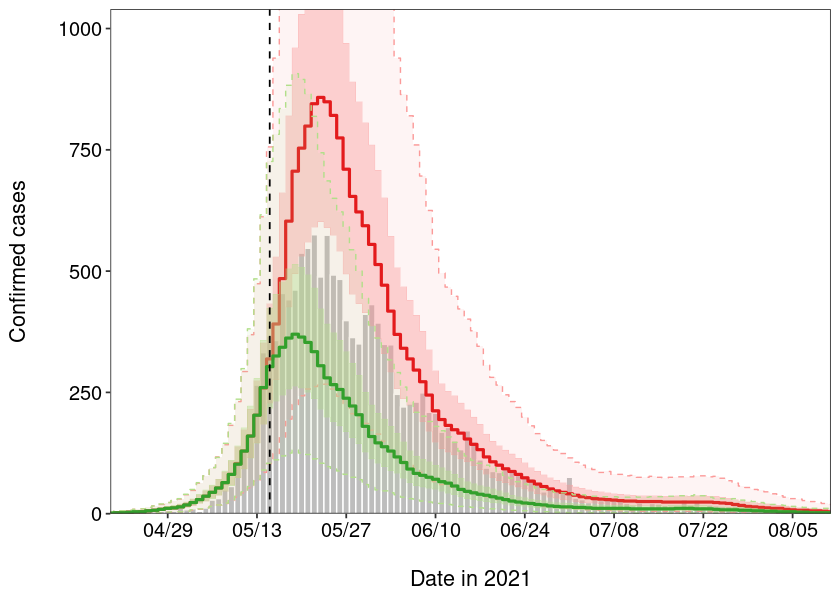

In [154]:
cs = c(7, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

output_cases_baseline_projected |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_cases_baseline_projected_
output_cases_baseline_projected_ |> tail(1) |> mutate(Onset = Onset + 7) |>
    rbind(output_cases_baseline_projected) |> arrange(Onset) -> output_cases_baseline_projected_

output_cases_scenario_projected |> filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) -> output_cases_scenario_projected_
output_cases_scenario_projected |> tail(1) |> mutate(Onset = Onset + 7) |>
    rbind(output_cases_scenario_projected) |> arrange(Onset) -> output_cases_scenario_projected_

shift_left = -2
shift_right = 2

clrs_shade = c("#b2df8a", "#bdbdbd", "#fb9a99") #"#cab2d6"
#clrs_shade = c("#1b9e77", "#7570b3")
clrs_line = c("#33a02c", "black", "#e31a1c")
#clrs_line = clrs_shade

output_cases_baseline_ |> 
    filter(Onset>=mindate_Rt, Onset<=maxdate_Rt) |>
    ggplot(aes(x=Onset-0.5)) +
        geom_bar(data = df_cases_backprj |> filter(d <= maxdate_incidence), 
                 aes(x=d, y=(n+median)), stat='identity', 
                 fill="#bdbdbd", color='white', size=.4, alpha=1, width=1) +
        #geom_bar(data = df_cases, aes(x=d, y=n),color="white", stat='identity', size=.4, width=1, fill=clr_[2], alpha=1) +

        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_scenario_projected_ |> filter(shift==shift_right), 
                  aes(ymax=IQR_upper, ymin=IQR_lower), fill=clrs_shade[3], alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_scenario_projected_ |> filter(shift==shift_right), 
                  aes(ymax=upper, ymin=lower), fill=clrs_shade[3], alpha = 0.1) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_right), 
                  aes(y=upper), color=clrs_shade[3], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_right), 
                  aes(y=lower), color=clrs_shade[3], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_right), 
                  aes(y=IQR_upper), color=clrs_shade[3], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_right), 
                  aes(y=IQR_lower), color=clrs_shade[3], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_right), 
                  aes(y=median), color=clrs_line[3], size=.9, alpha=1) +

        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_scenario_projected_ |> filter(shift==shift_left), 
                  aes(ymax=IQR_upper, ymin=IQR_lower), fill=clrs_shade[1], alpha = 0.4) +
        RcmdrPlugin.KMggplot2::geom_stepribbon(data = output_cases_scenario_projected_ |> filter(shift==shift_left), 
                  aes(ymax=upper, ymin=lower), fill=clrs_shade[1], alpha = 0.1) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_left), 
                  aes(y=upper), color=clrs_shade[1], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_left), 
                  aes(y=lower), color=clrs_shade[1], linetype="dashed", size=.4, alpha=1) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_left), 
                  aes(y=IQR_upper), color=clrs_shade[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_left), 
                  aes(y=IQR_lower), color=clrs_shade[1], linetype="solid", size=.1, alpha=.6) +
        geom_step(data = output_cases_scenario_projected_ |> filter(shift==shift_left), 
                  aes(y=median), color=clrs_line[1], size=.9, alpha=1) +

        geom_vline(xintercept=date_ref_scenario, size=.5, linetype='dashed') +

        labs(x="\nDate in 2021", y="Confirmed cases\n") +
        theme_bw() + 
        scale_x_date(date_labels="%m/%d",date_breaks  = "14 days") +
        coord_cartesian(ylim=c(0,ymax+400), xlim=c(mindate_Rt, maxdate_Rt), expand=0) +
        scale_fill_brewer(palette="Set2") + 
        theme(text = element_text(size=13, family="sans", color="black"),
            axis.text = element_text(size=12, family="sans", color="black"),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> plt

plt

if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/two_scenarios.",filetype_))
}

In [155]:
date_max = as.Date('2021-08-14')
options(warn=-1) 
as_draws_df(mod_Rt_mixture_changepoint_prj$draws("cases_baseline")) |> 
    select(starts_with("cases"), .draw) |>
    gather(variable, cases, -.draw) |> separate(variable, c("variable", "index"), sep = "([\\[,\\]])", extra = "drop") |>
    select(-variable) |> mutate(index = as.numeric(index), Onset = index + mindate) |> 
    filter(Onset < date_max) |> group_by(.draw) |> summarize(cases = sum(cases)) |>
    mutate(shift = 0, timing = 'Baseline') |> select(-.draw) -> df_sumcases
options(warn=0)
df_sumcases |> head()

cases shift timing  
1  9531 0     Baseline
2 12145 0     Baseline
3  9064 0     Baseline
4 18222 0     Baseline
5 23231 0     Baseline
6  8877 0     Baseline

In [156]:
date_max = as.Date('2021-08-14')
for (shift_ in abs(shifts)) {
    message(shift_)
    options(warn=-1) 
    as_draws_df(mod_Rt_mixture_changepoint_prj$draws("cases_scenario_right")) |> 
        select(starts_with(paste0("cases_scenario_right[",shift_,",")), .draw) |>
        gather(variable, cases, -.draw) |> separate(variable, c("variable", "shift", "index"), sep = "([\\[,\\]])", extra = "drop") |>
        select(-variable, -shift) |> mutate(index = as.numeric(index), Onset = index + mindate) |> 
        filter(Onset < date_max) |> group_by(.draw) |> summarize(cases = sum(cases)) |>
        mutate(shift = shift_, timing = 'Later') |> select(-.draw) -> df_out_
    df_sumcases = rbind(df_sumcases, df_out_)
    options(warn=0)
}
df_sumcases |> head()

1

2

3

4

5

6

7

8



cases shift timing  
1  9531 0     Baseline
2 12145 0     Baseline
3  9064 0     Baseline
4 18222 0     Baseline
5 23231 0     Baseline
6  8877 0     Baseline

In [157]:
for (shift_ in abs(shifts)) {
    message(shift_)
    options(warn=-1) 
    as_draws_df(mod_Rt_mixture_changepoint_prj$draws("cases_scenario_left")) |> 
        select(starts_with(paste0("cases_scenario_left[",shift_,",")), .draw) |>
        gather(variable, cases, -.draw) |> separate(variable, c("variable", "shift", "index"), sep = "([\\[,\\]])", extra = "drop") |>
        select(-variable, -shift) |> mutate(index = as.numeric(index), Onset = index + mindate) |> 
        filter(Onset < date_max) |> group_by(.draw) |> summarize(cases = sum(cases)) |>
        mutate(shift = -shift_, timing = 'Earlier') |> select(-.draw) -> df_out_
    df_sumcases = rbind(df_sumcases, df_out_)
    options(warn=0)
}
df_sumcases |> tail()

1

2

3

4

5

6

7

8



cases shift timing 
1 3084  -8    Earlier
2 4459  -8    Earlier
3 1788  -8    Earlier
4 4630  -8    Earlier
5 2448  -8    Earlier
6 4373  -8    Earlier

In [158]:
as_draws_df(mod_Rt_mixture_changepoint_prj$draws("cases_predicted")) |> 
    select(starts_with("cases"), .draw) |>
    gather(variable, cases, -.draw) |> separate(variable, c("variable", "index"), sep = "([\\[,\\]])", extra = "drop") |>
    select(-variable) |> mutate(index = as.numeric(index), Onset = index + mindate) |> 
    filter(Onset < date_max) |> group_by(.draw) |> summarize(cases = sum(cases)) |>
    select(-.draw) -> df_sumcases_data
df_sumcases_data |> tail()

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


cases
1 14414
2 14413
3 14412
4 14415
5 14414
6 14413

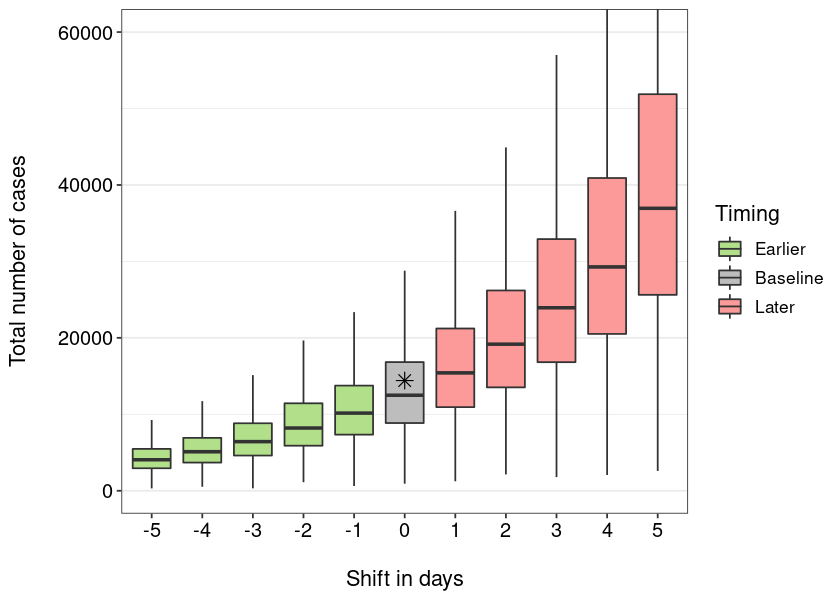

In [159]:
cs = c(7, 5)
options(repr.plot.width=cs[1], repr.plot.height=cs[2])

df_sumcases |>
    filter(abs(shift) <= 5) |> mutate(shift = as.factor(shift), Timing = factor(timing, levels=c("Earlier", "Baseline", "Later"))) |>
    ggplot(aes(y=cases, x=shift, group=shift, fill=Timing)) +
    geom_boxplot(outlier.shape = NA) +
    geom_point(data = data.frame(shift=c(0) |> as.factor(), Timing='Baseline', cases=median(df_sumcases_data$cases)), 
               size=3, pch=8, show.legend = FALSE) +
    labs(x="\nShift in days", y="Total number of cases\n") +
    guides(point = "none") +
    theme_bw() + 
    coord_cartesian(ylim=c(0,60000)) +
    #scale_fill_brewer(palette="Set2") + 
    scale_fill_manual(values=clrs_shade) +
    theme(text = element_text(size=13, family="sans", color="black"),
        axis.text = element_text(size=12, family="sans", color="black"),
        panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank()) -> plt

plt

if (generateFigures) { 
    for (filetype_ in c("png", "pdf"))
        ggsave(plot=plt, width=cs[1], height=cs[2], device = filetype_,
               filename=paste0(figures_dir,"/scenarios_epidemic_size.",filetype_))
}

In [160]:
df_sumcases |> filter(timing=='Earlier', shift==-3) |> select(cases) |>
    summarize(median=median(cases), lower=quantile(cases, probs=c(.025)), upper=quantile(cases, probs=c(.975))) |> round(-2)

median lower upper
1 6400   2200  15600

In [161]:
df_sumcases |> filter(timing=='Later', shift==3) |> select(cases) |>
    summarize(median=median(cases), lower=quantile(cases, probs=c(.025)), upper=quantile(cases, probs=c(.975))) |> round(-2)

median lower upper
1 23900  7900  61500

In [162]:
df_sumcases |> filter(timing=='Baseline') |> select(cases) |>
    summarize(median=median(cases), lower=quantile(cases, probs=c(.025)), upper=quantile(cases, probs=c(.975))) |> round(-2)

median lower upper
1 12500  4000  29800

In [163]:
#data
median(df_sumcases_data$cases)

[1] 14414